<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-and-functions" data-toc-modified-id="Data-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data and functions</a></span><ul class="toc-item"><li><span><a href="#Use-my-flexible-correlation-function" data-toc-modified-id="Use-my-flexible-correlation-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Use my flexible correlation function</a></span><ul class="toc-item"><li><span><a href="#Get-the-required-packages" data-toc-modified-id="Get-the-required-packages-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Get the required packages</a></span></li><li><span><a href="#Load-the-flexible-correlation-script" data-toc-modified-id="Load-the-flexible-correlation-script-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Load the flexible correlation script</a></span></li></ul></li><li><span><a href="#Function-to-plot-per-ROI" data-toc-modified-id="Function-to-plot-per-ROI-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Function to plot per ROI</a></span></li></ul></li><li><span><a href="#PSC/SIF-correlations-per-ROI" data-toc-modified-id="PSC/SIF-correlations-per-ROI-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PSC/SIF correlations per ROI</a></span><ul class="toc-item"><li><span><a href="#No-Think" data-toc-modified-id="No-Think-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No-Think</a></span></li><li><span><a href="#Think" data-toc-modified-id="Think-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Think</a></span></li><li><span><a href="#Think---No-Think" data-toc-modified-id="Think---No-Think-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Think - No-Think</a></span></li></ul></li><li><span><a href="#PSC/SIF-correlations-per-dataset-and-per-ROI" data-toc-modified-id="PSC/SIF-correlations-per-dataset-and-per-ROI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PSC/SIF correlations per dataset and per ROI</a></span><ul class="toc-item"><li><span><a href="#No-Think" data-toc-modified-id="No-Think-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>No-Think</a></span></li><li><span><a href="#Think" data-toc-modified-id="Think-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Think</a></span></li><li><span><a href="#Think-No-Think" data-toc-modified-id="Think-No-Think-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Think-No-Think</a></span></li></ul></li></ul></div>

# Data and functions

In [1]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(suppressWarnings(library(ggplot2)))   # for plotting results
shhh(suppressWarnings(library(gridExtra))) # for adding plots together
shhh(suppressWarnings(library(grid)))      # for plot grid title formatting

# Suppress function output
# =======================================================
# I got it from here https://stackoverflow.com/questions/2723034/suppress-output-of-a-function 
hush <- function(code){
  sink("NUL") # use /dev/null in UNIX
  tmp = code
  sink()
  return(tmp)
}

In [2]:
# Load percent-signal-change data
data_psc <- read.csv('data/psc.csv')
data_psc$roi <- as.factor(data_psc$roi)
data_psc$subid <- as.factor(data_psc$subid)
data_psc$stid <- as.factor(data_psc$stid)
# Load behavioural data
data_beh <- read.csv('data/behavioural.csv')
data_beh$subid <- as.factor(data_beh$subid)
data_beh$stid <- as.factor(data_beh$stid)

# SIF data only from the behavioural
data_sif <- subset(data_beh[c(1:5)])
data_sif  <- data_sif [complete.cases(data_sif ),]

# Intrusion data only from the behavioural
data_intr <- subset(data_beh[c(1:3,7:ncol(data_beh))])
data_intr  <- data_intr [complete.cases(data_intr ),]

# Merge SIF and Intrusion data
data_sif.intr <- merge(data_sif, data_intr[c(3:ncol(data_intr))], by = 'subid')

# Merge SIF and PSC data
data_sif.psc <- merge(data_sif, data_psc[c(3:ncol(data_psc))], by = 'subid')

# Merge Intrusion and PSC data
data_intr.psc <- merge(data_intr, data_psc[c(3:ncol(data_psc))], by = 'subid')

## Use my flexible correlation function

In [6]:
source("https://raw.githubusercontent.com/dcdace/R_functions/main/flexible-correlations/flexible_correlations.r")

Warning message:
"package 'aplpack' was built under R version 4.0.5"
Warning message:
"package 'WRS2' was built under R version 4.0.5"

Attaching package: 'WRS'


The following objects are masked from 'package:WRS2':

    akp.effect, ancboot, ancova, binband, bwtrim, discANOVA, discmcp,
    discstep, Dqcomhd, lincon, mcp2a, mcp2atm, mcppb20, med1way,
    med2way, medpb2, mest, mestse, mom, msmedse, onesampb, onestep,
    pairdepb, pb2gen, pbad2way, pball, pbcor, Qanova, qcomhd, rmanova,
    rmanovab, rmmcp, rungen, runmbo, runmean, sppba, sppbb, sppbi,
    t1way, t1waybt, t2way, t3way, trimcibt, trimse, tsplit, twocor,
    twopcor, winall, wincor, winmean, winse, winvar, wmcpAKP, yuen,
    yuen.effect.ci, yuenbt, yuend, ZYmediate


The following object is masked from 'package:grid':

    depth


The following objects are masked from 'package:stats':

    cov2cor, ecdf


The following object is masked from 'package:grDevices':

    bmp




## Function to plot per ROI

In [7]:
# Function to plot per ROI
plot_per_roi <- function(data, rois, var1, var2){
    nrois <- length(rois)
    plotlist <- list()
    for (i in 1:nrois) {
        df <- subset(data, data$roi == rois[i])
        x <- df[[var1]]
        y <- df[[var2]]

        p <- plot_correlation(x, y, var1, var2, pthreshold = 0.05) + 
            geom_vline(aes(xintercept = 0), size = 0.1) + 
            geom_hline(aes(yintercept = 0), size = 0.1) + 
            labs(title = rois[i])
        
        plotlist[[i]] <- p
        }
        gridExtra::grid.arrange(grobs = plotlist)
}

# PSC/SIF correlations per ROI

In [8]:
# Get a list of all ROIs
rois <- levels(data_sif.psc$roi)
# plot size
options(repr.plot.width = 14, repr.plot.height = 14, repr.plot.res = 200)

## No-Think

Warning message:
"package 'MASS' was built under R version 4.0.5"

Attaching package: 'MASS'


The following object is masked from 'package:WRS':

    ltsreg




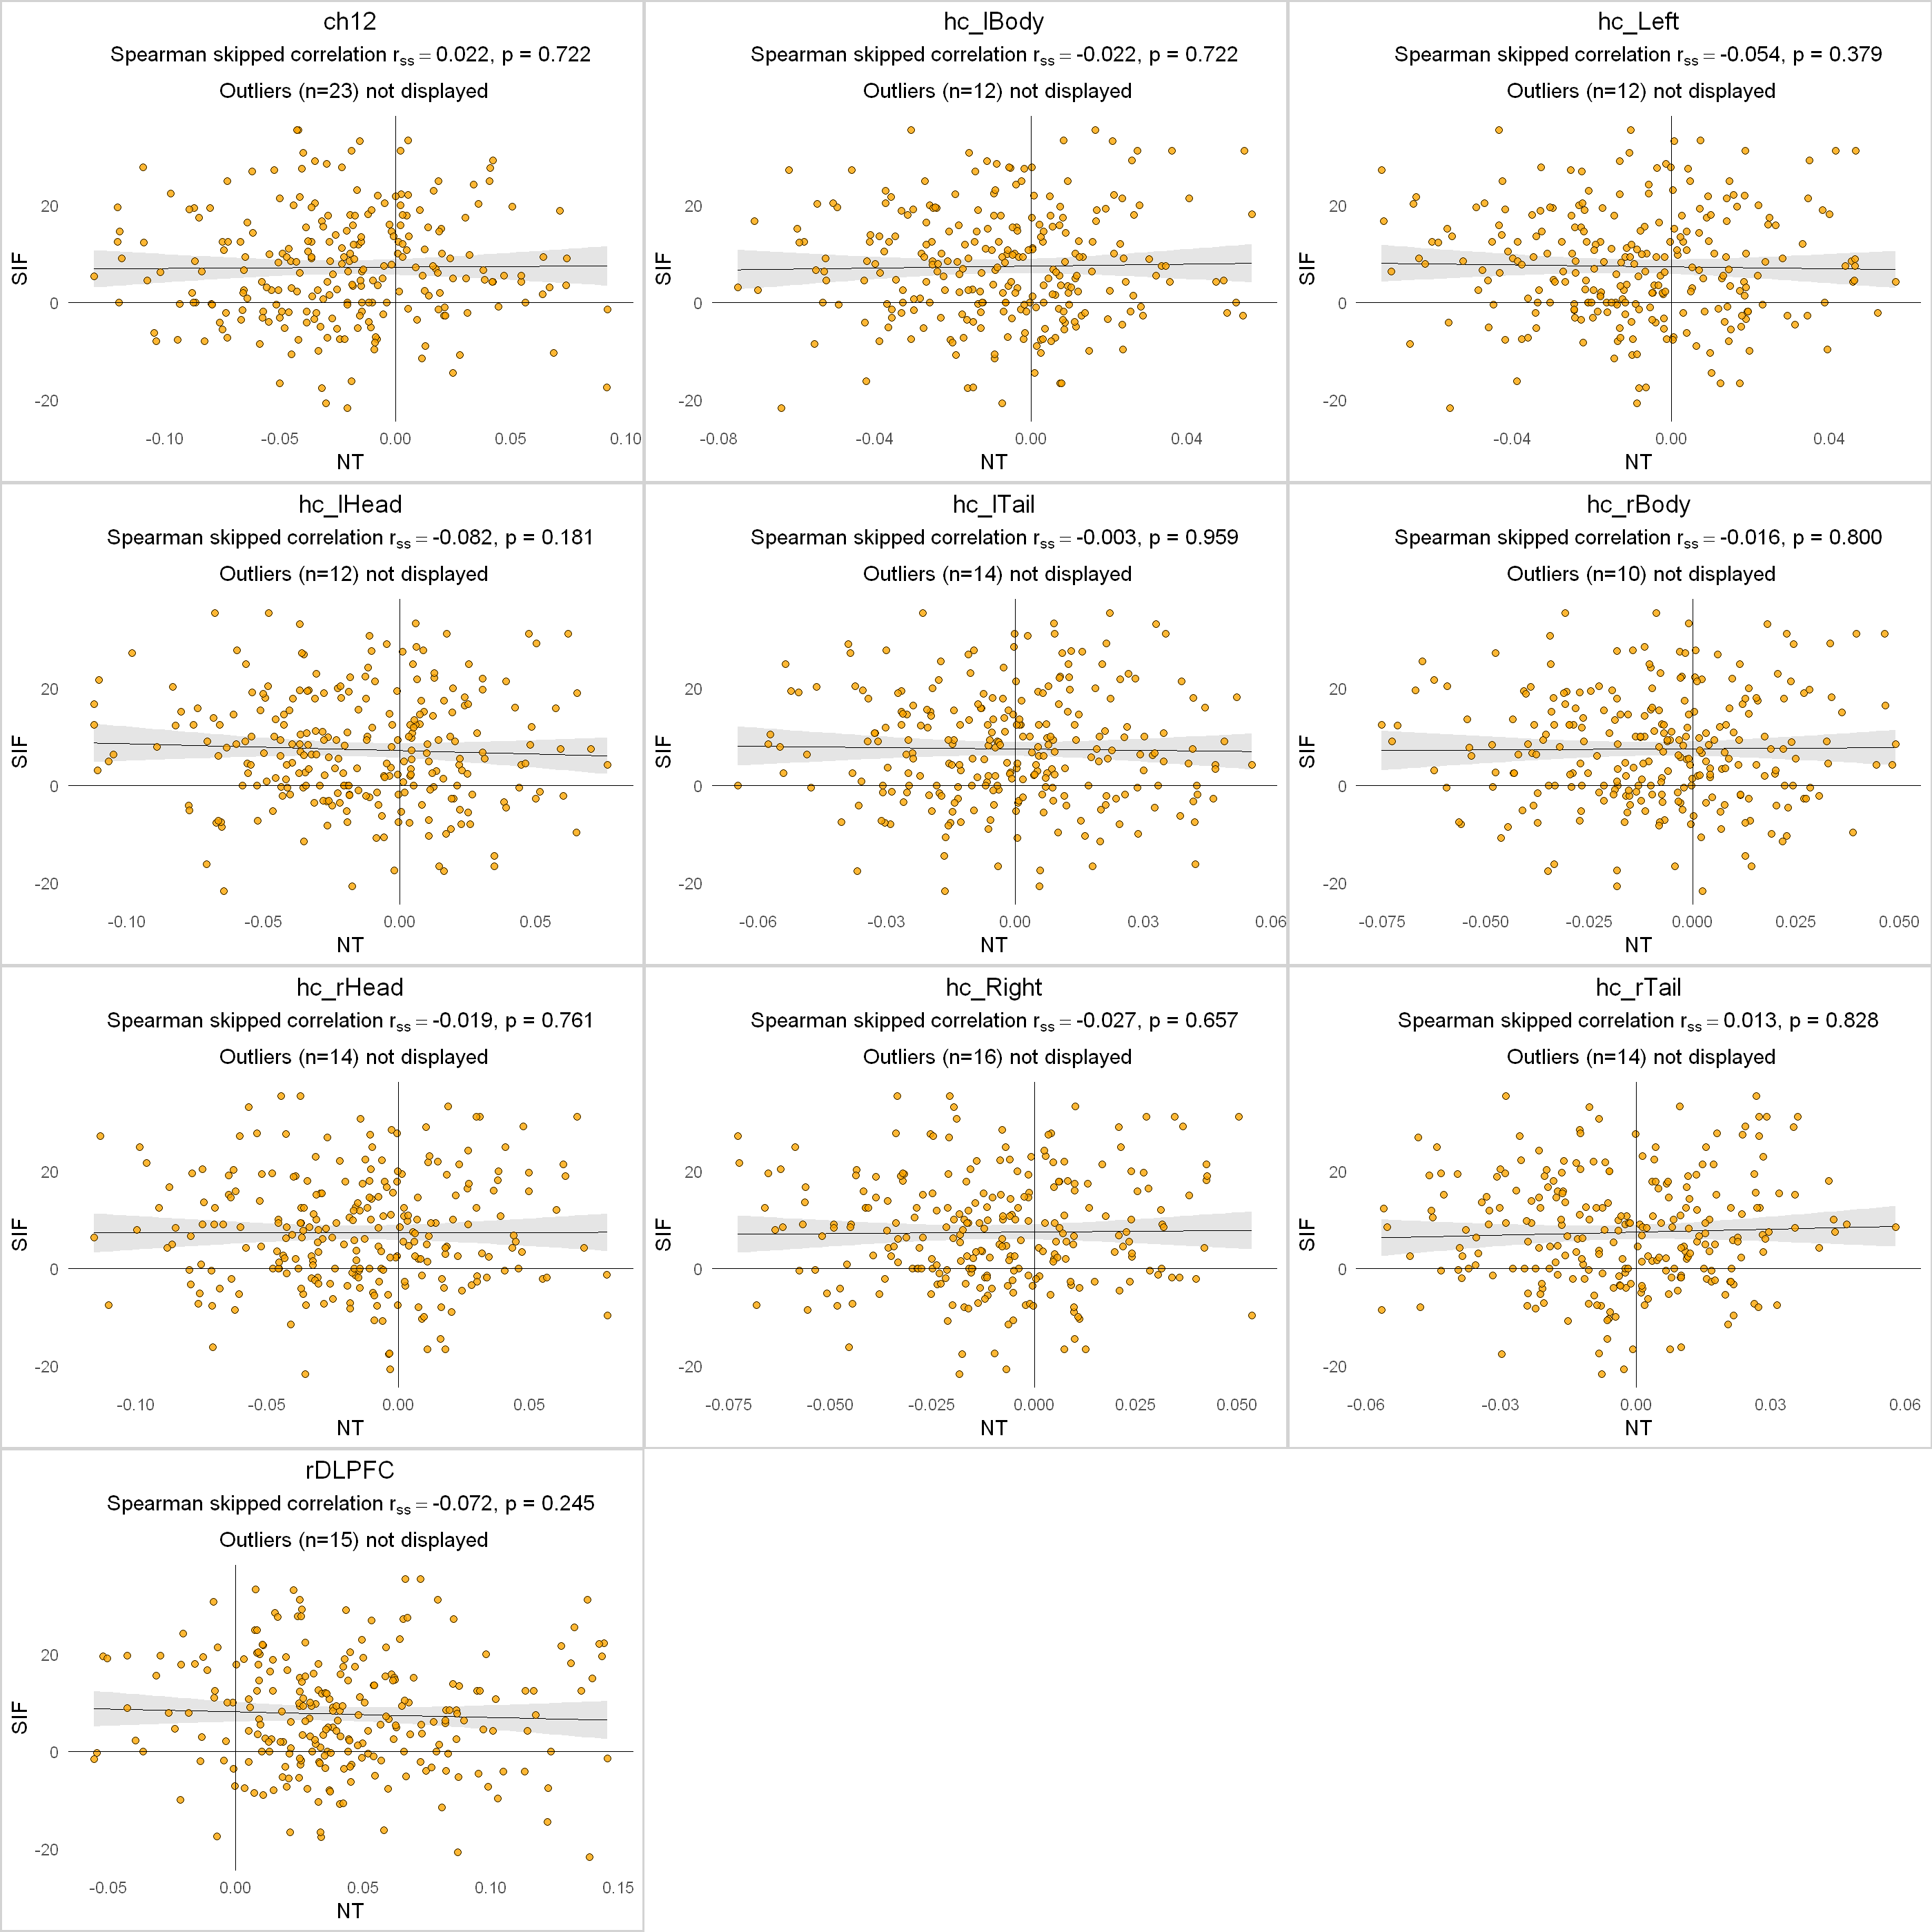

In [9]:
plot_per_roi(data_sif.psc, rois, "NT", "SIF")

## Think

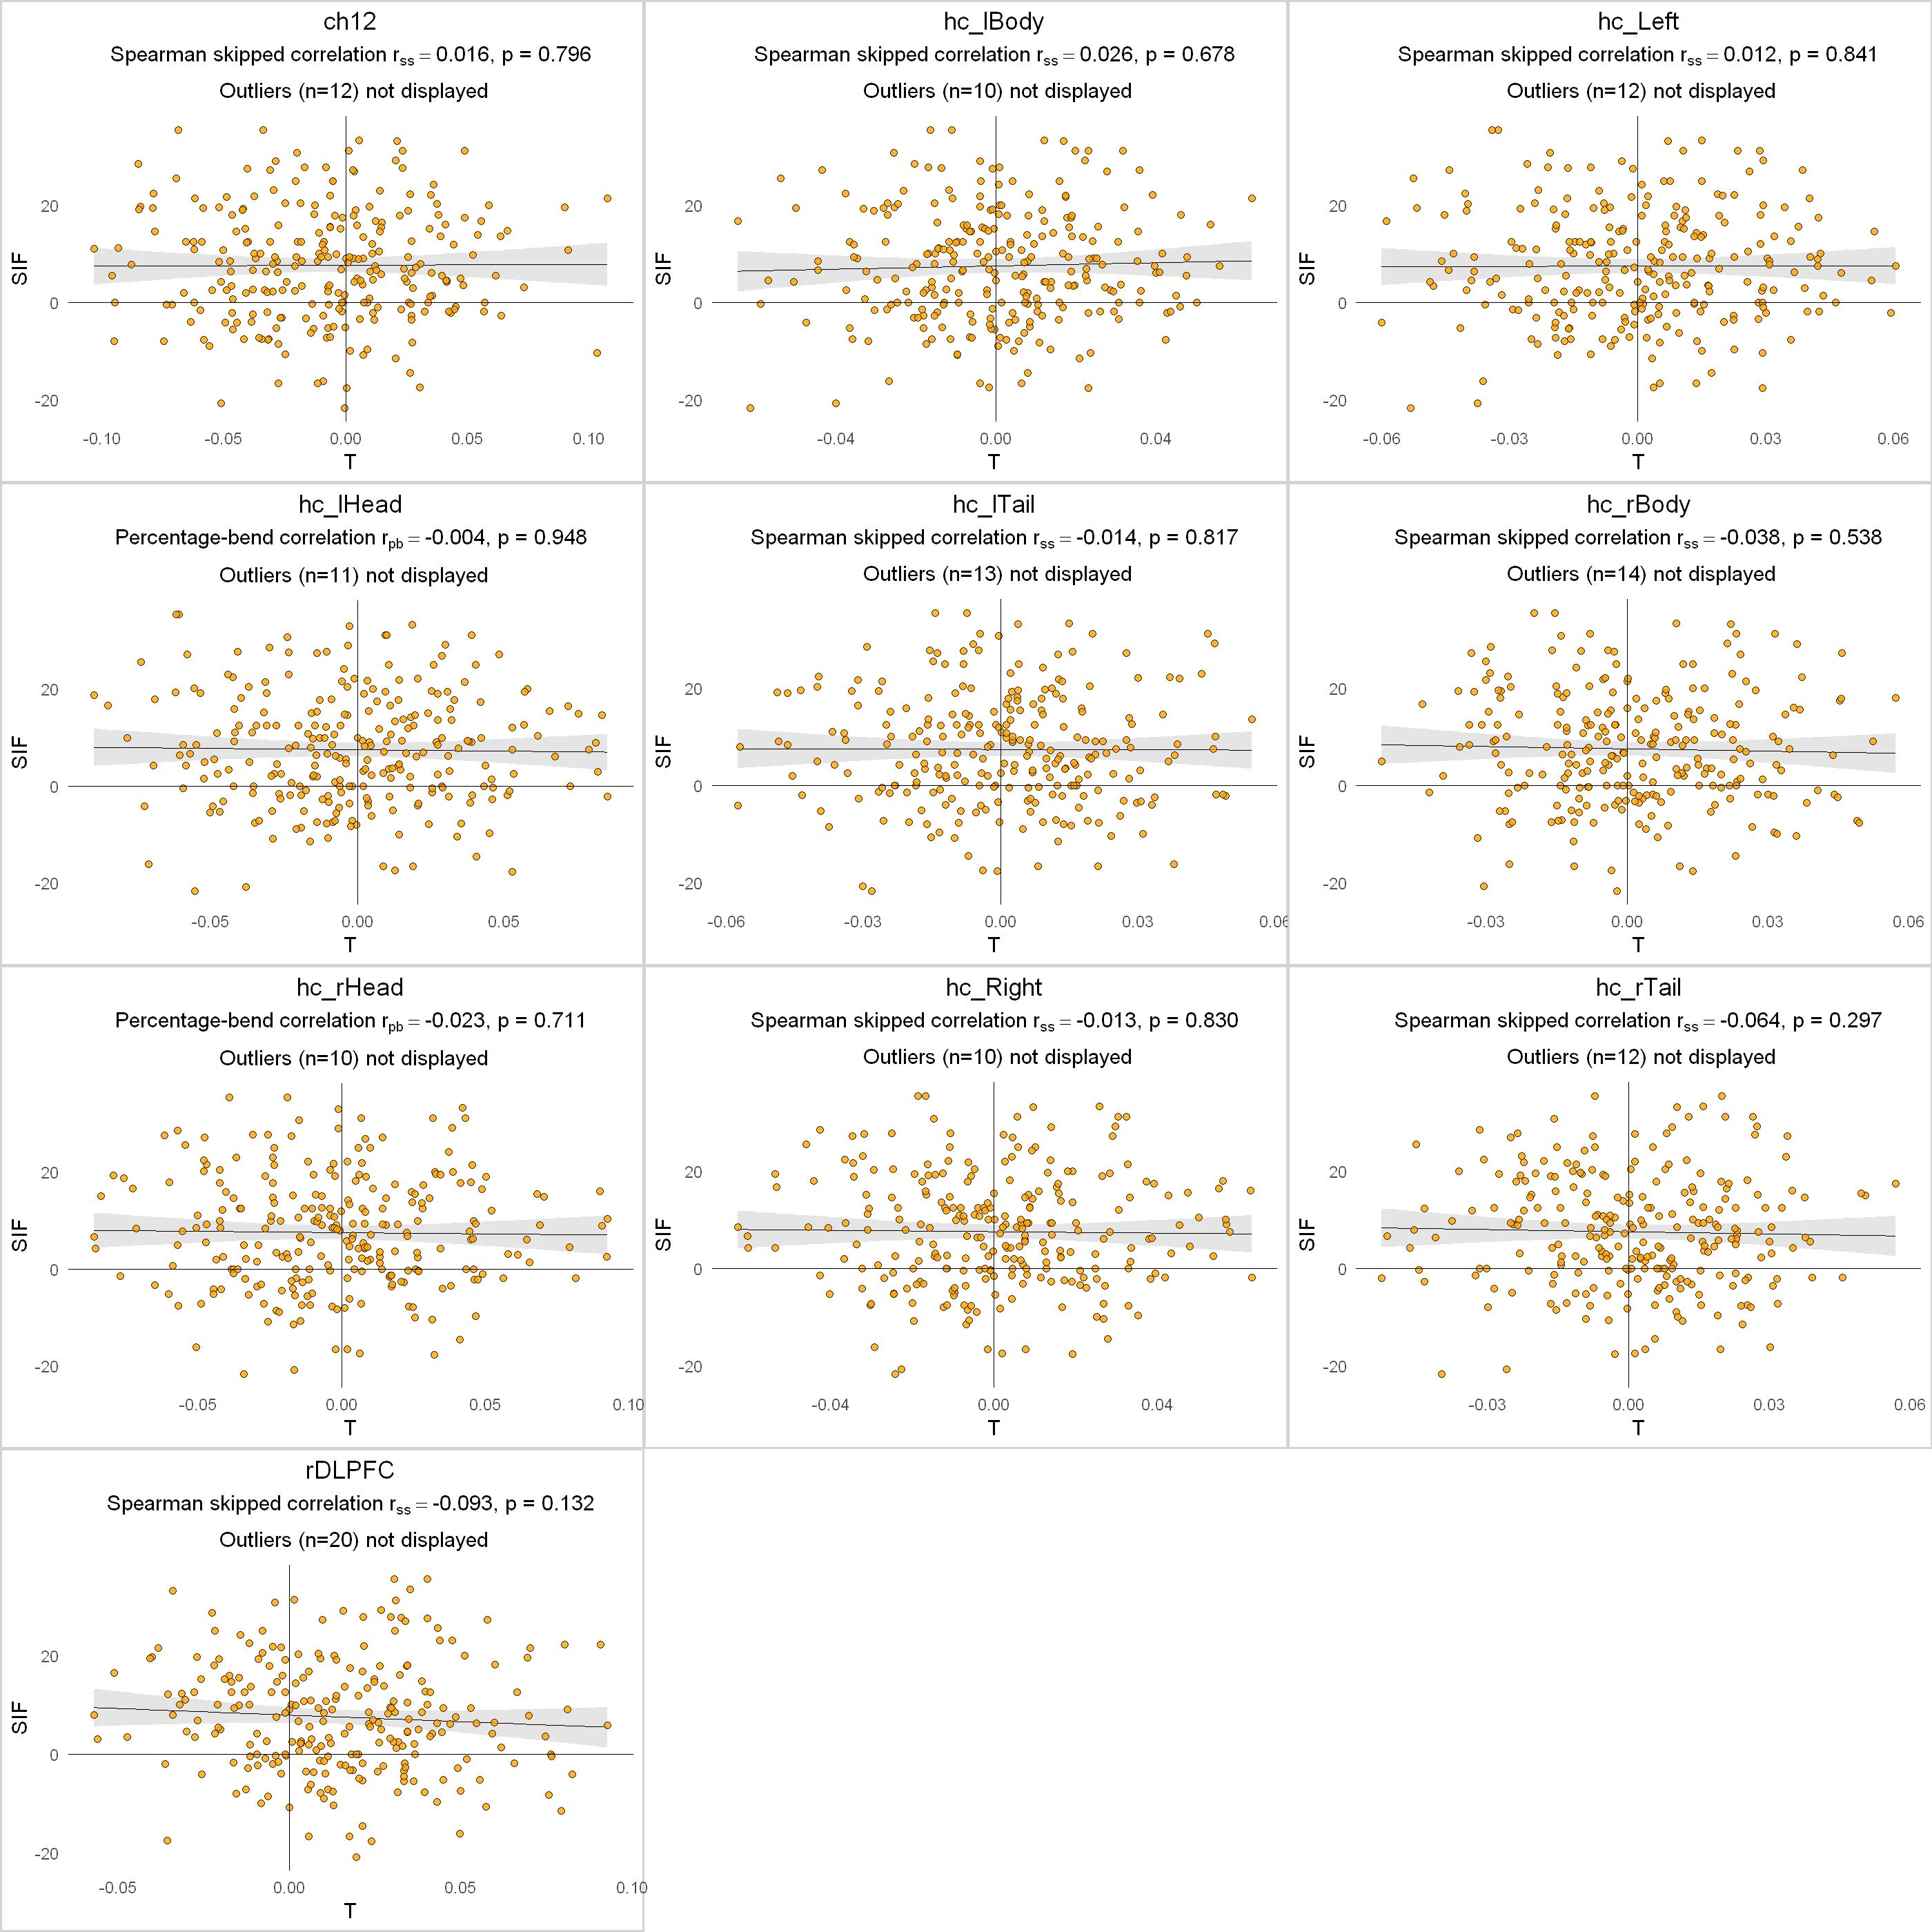

In [10]:
plot_per_roi(data_sif.psc, rois, "T", "SIF")

## Think - No-Think

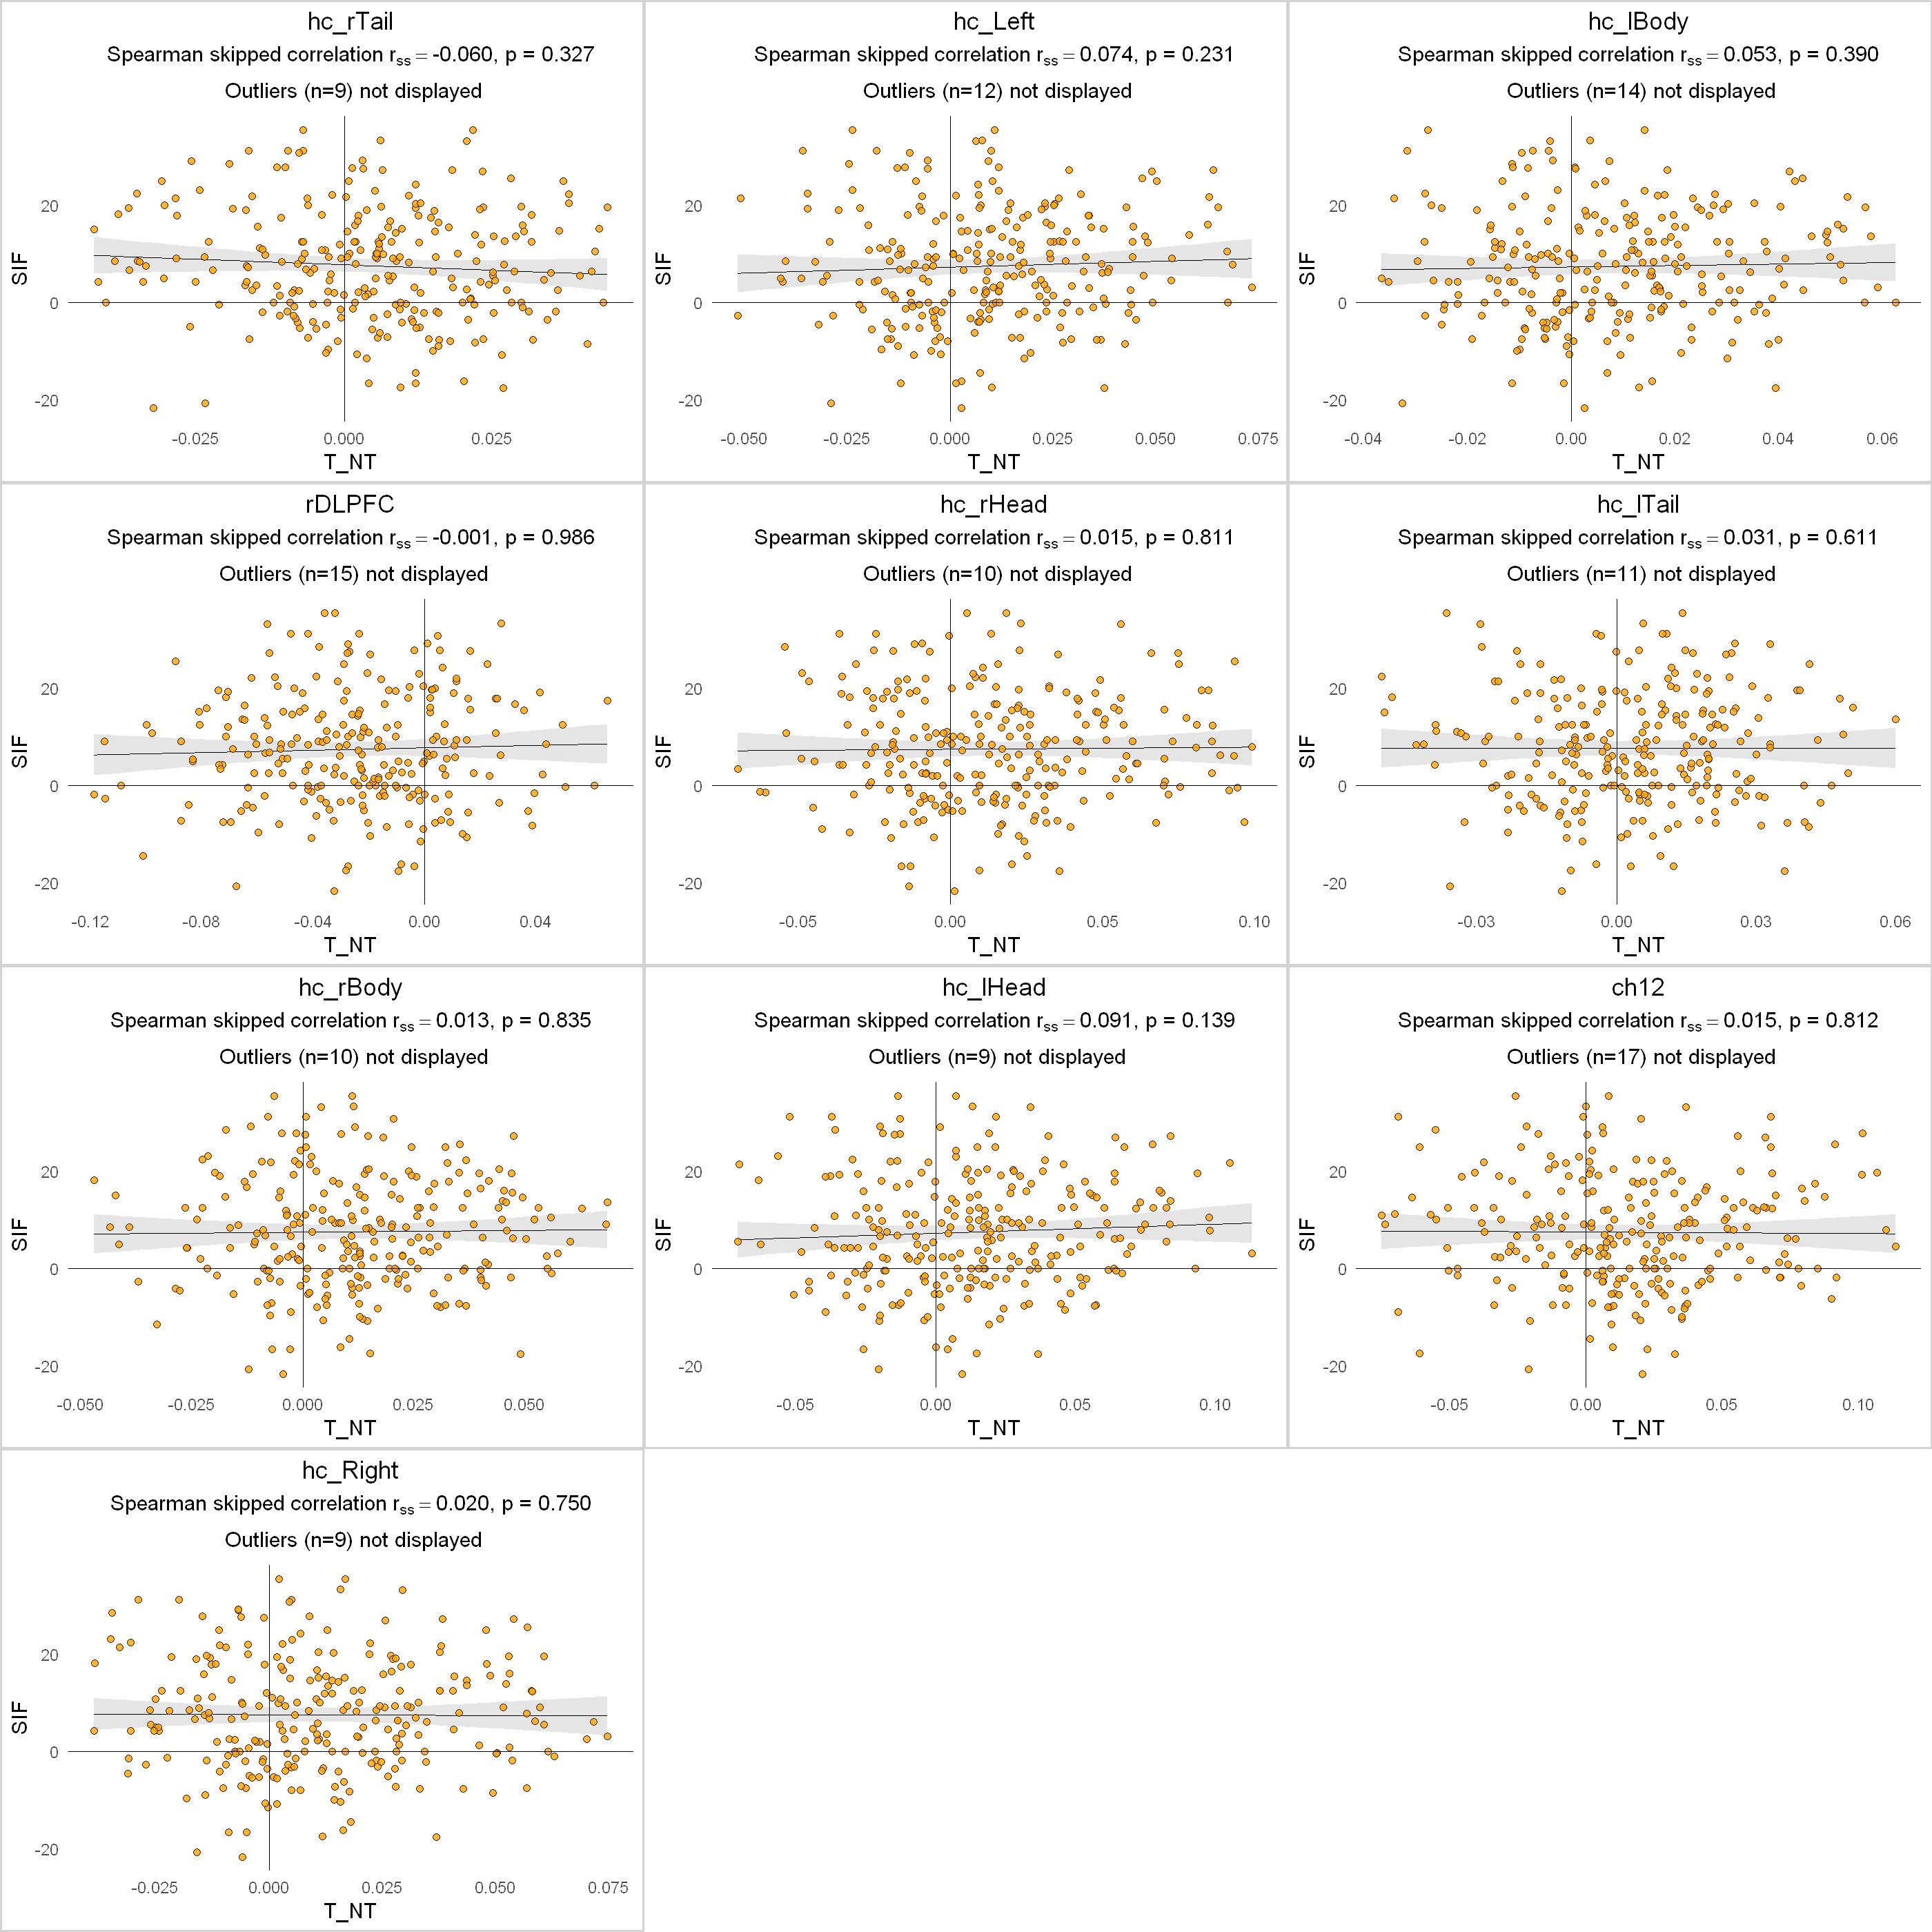

In [46]:
data_sif.psc$T_NT <- data_sif.psc$T-data_sif.psc$NT
plot_per_roi(data_sif.psc, rois, "T_NT", "SIF")

# PSC/SIF correlations per dataset and per ROI

In [69]:
# Get a list of all datasets
datasets <- levels(data_sif.psc$stid)
datasets
length(datasets)

[1] "01_Levy1"        "02_Levy2"        "03_RolandJoCN"   "04_PierreJoN"   
 [5] "05_Yuhua"        "06_RolandNeuron" "07_PierrePNAS"   "08_Taylor"      
 [9] "09_Xu"           "10_Big-TNT"

[1] 10

## No-Think

[1] "01_Levy1"

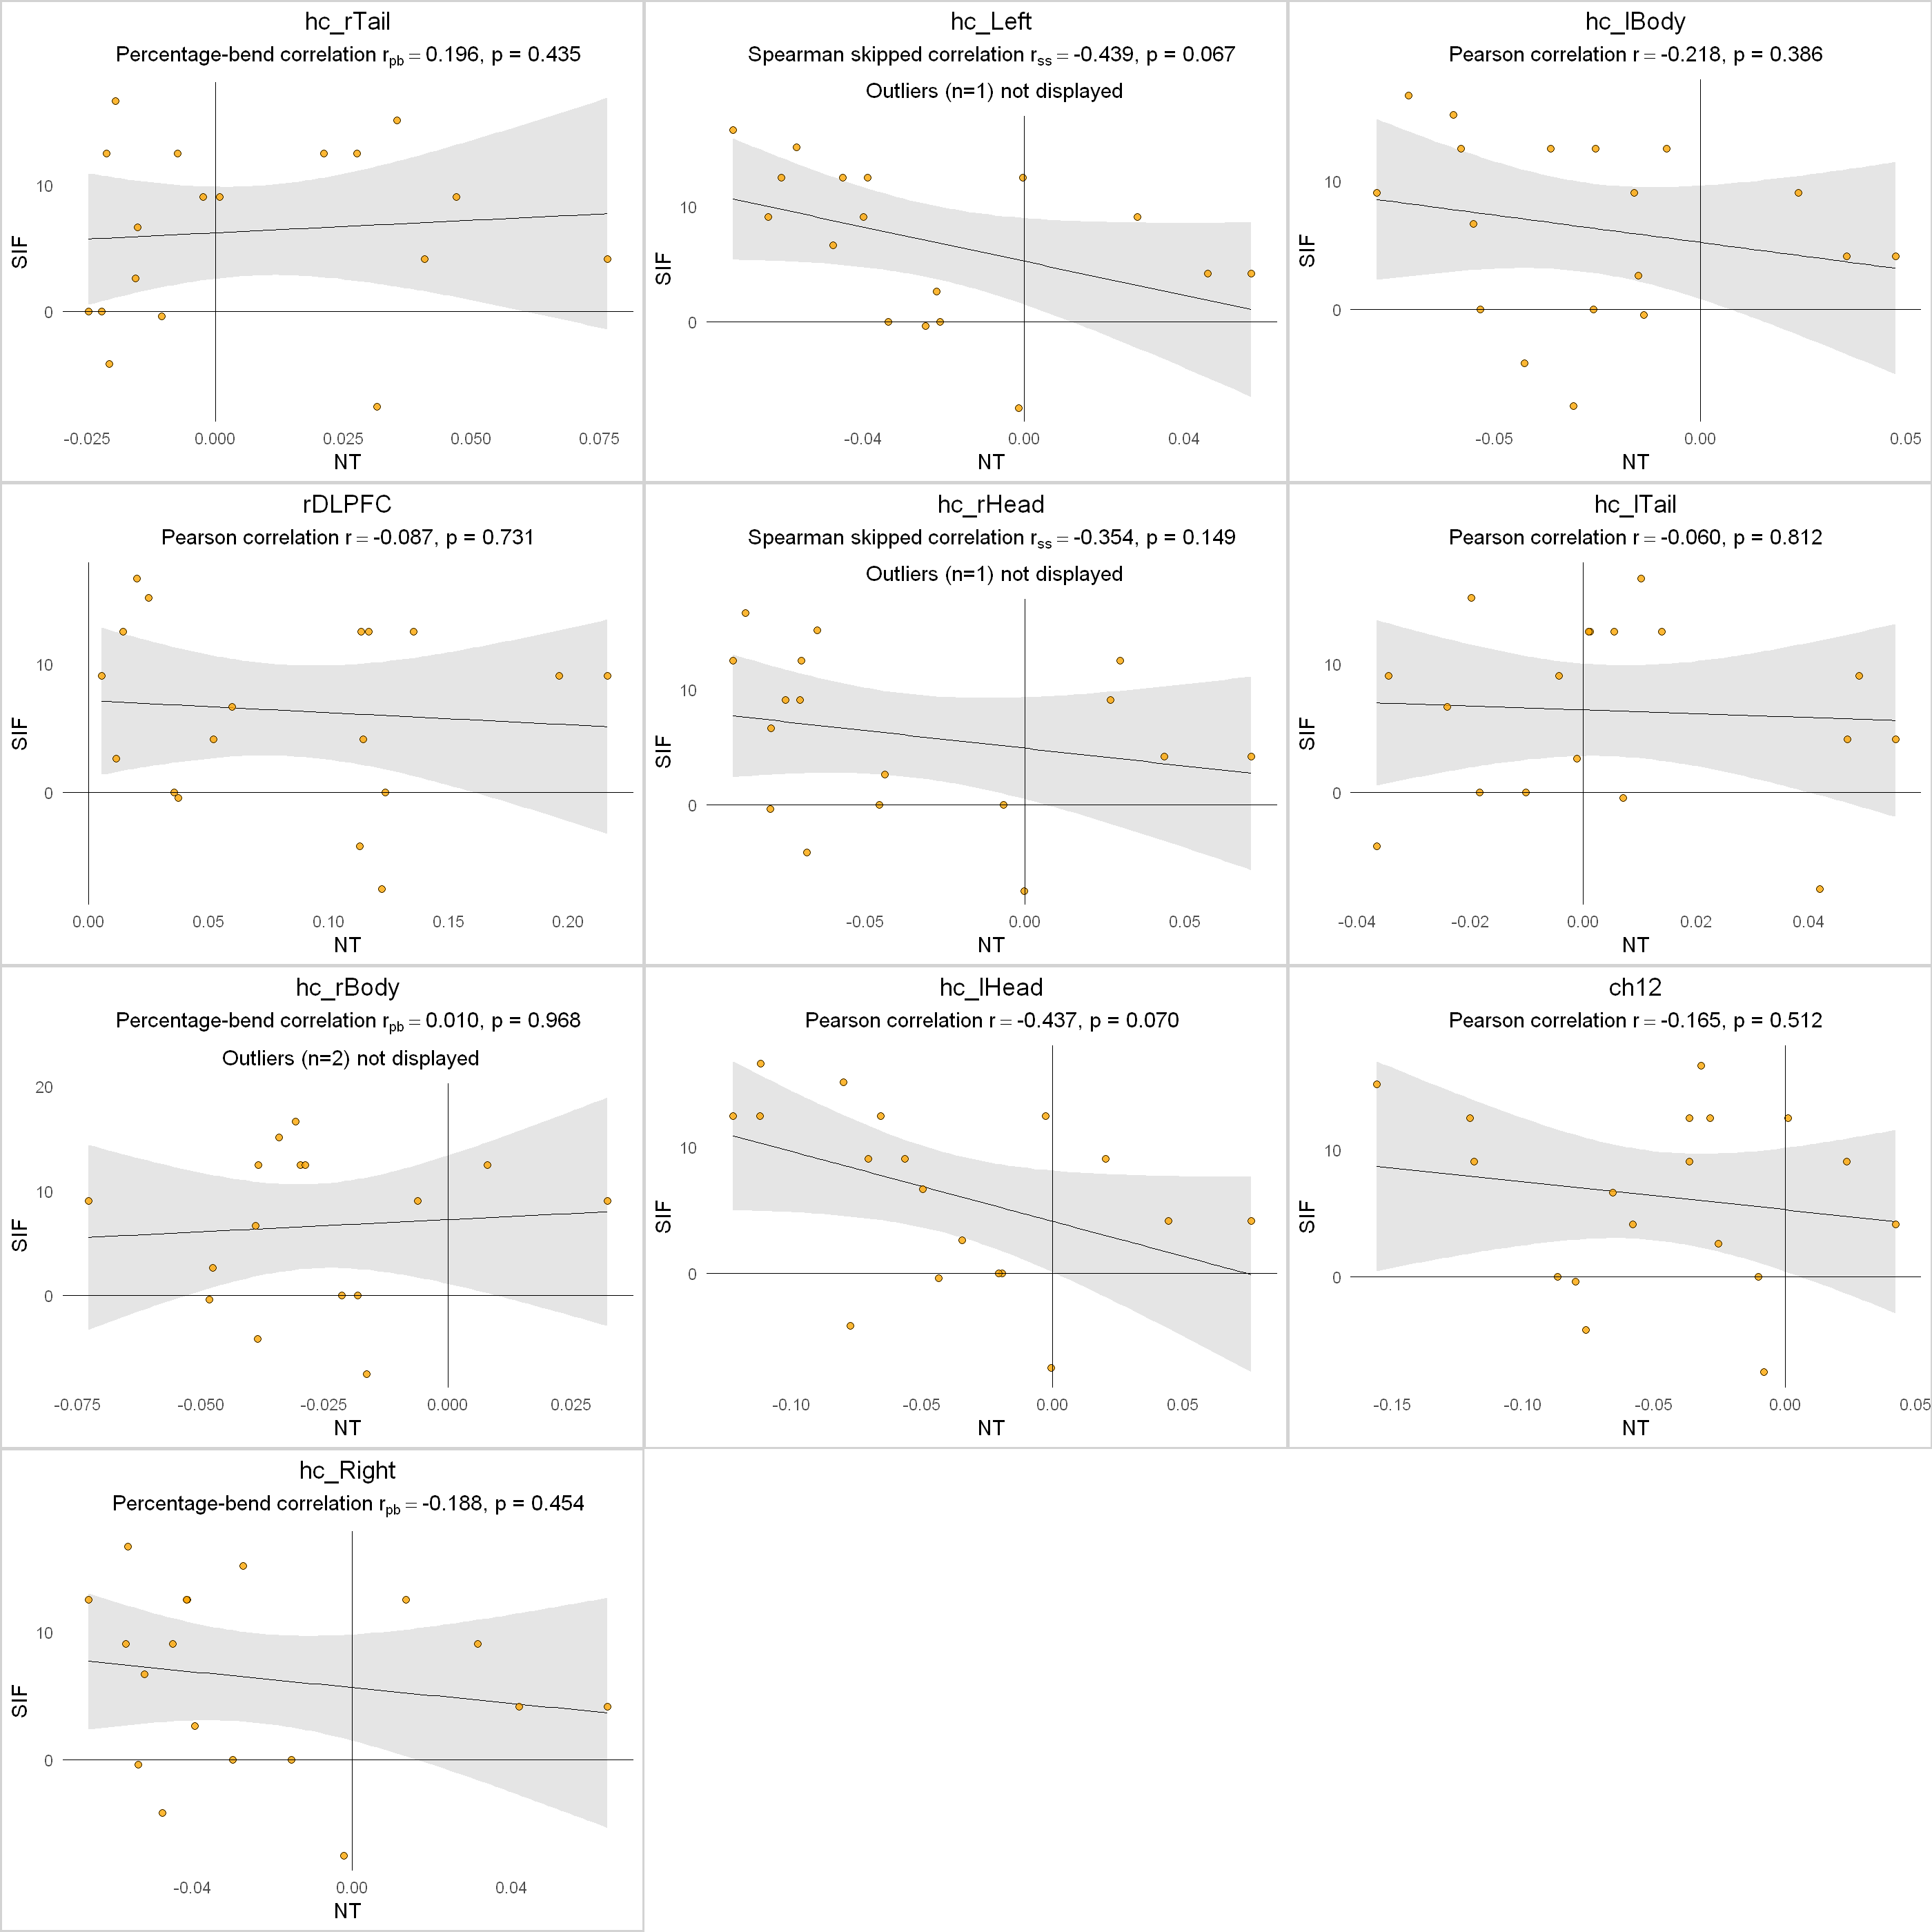

In [70]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "02_Levy2"

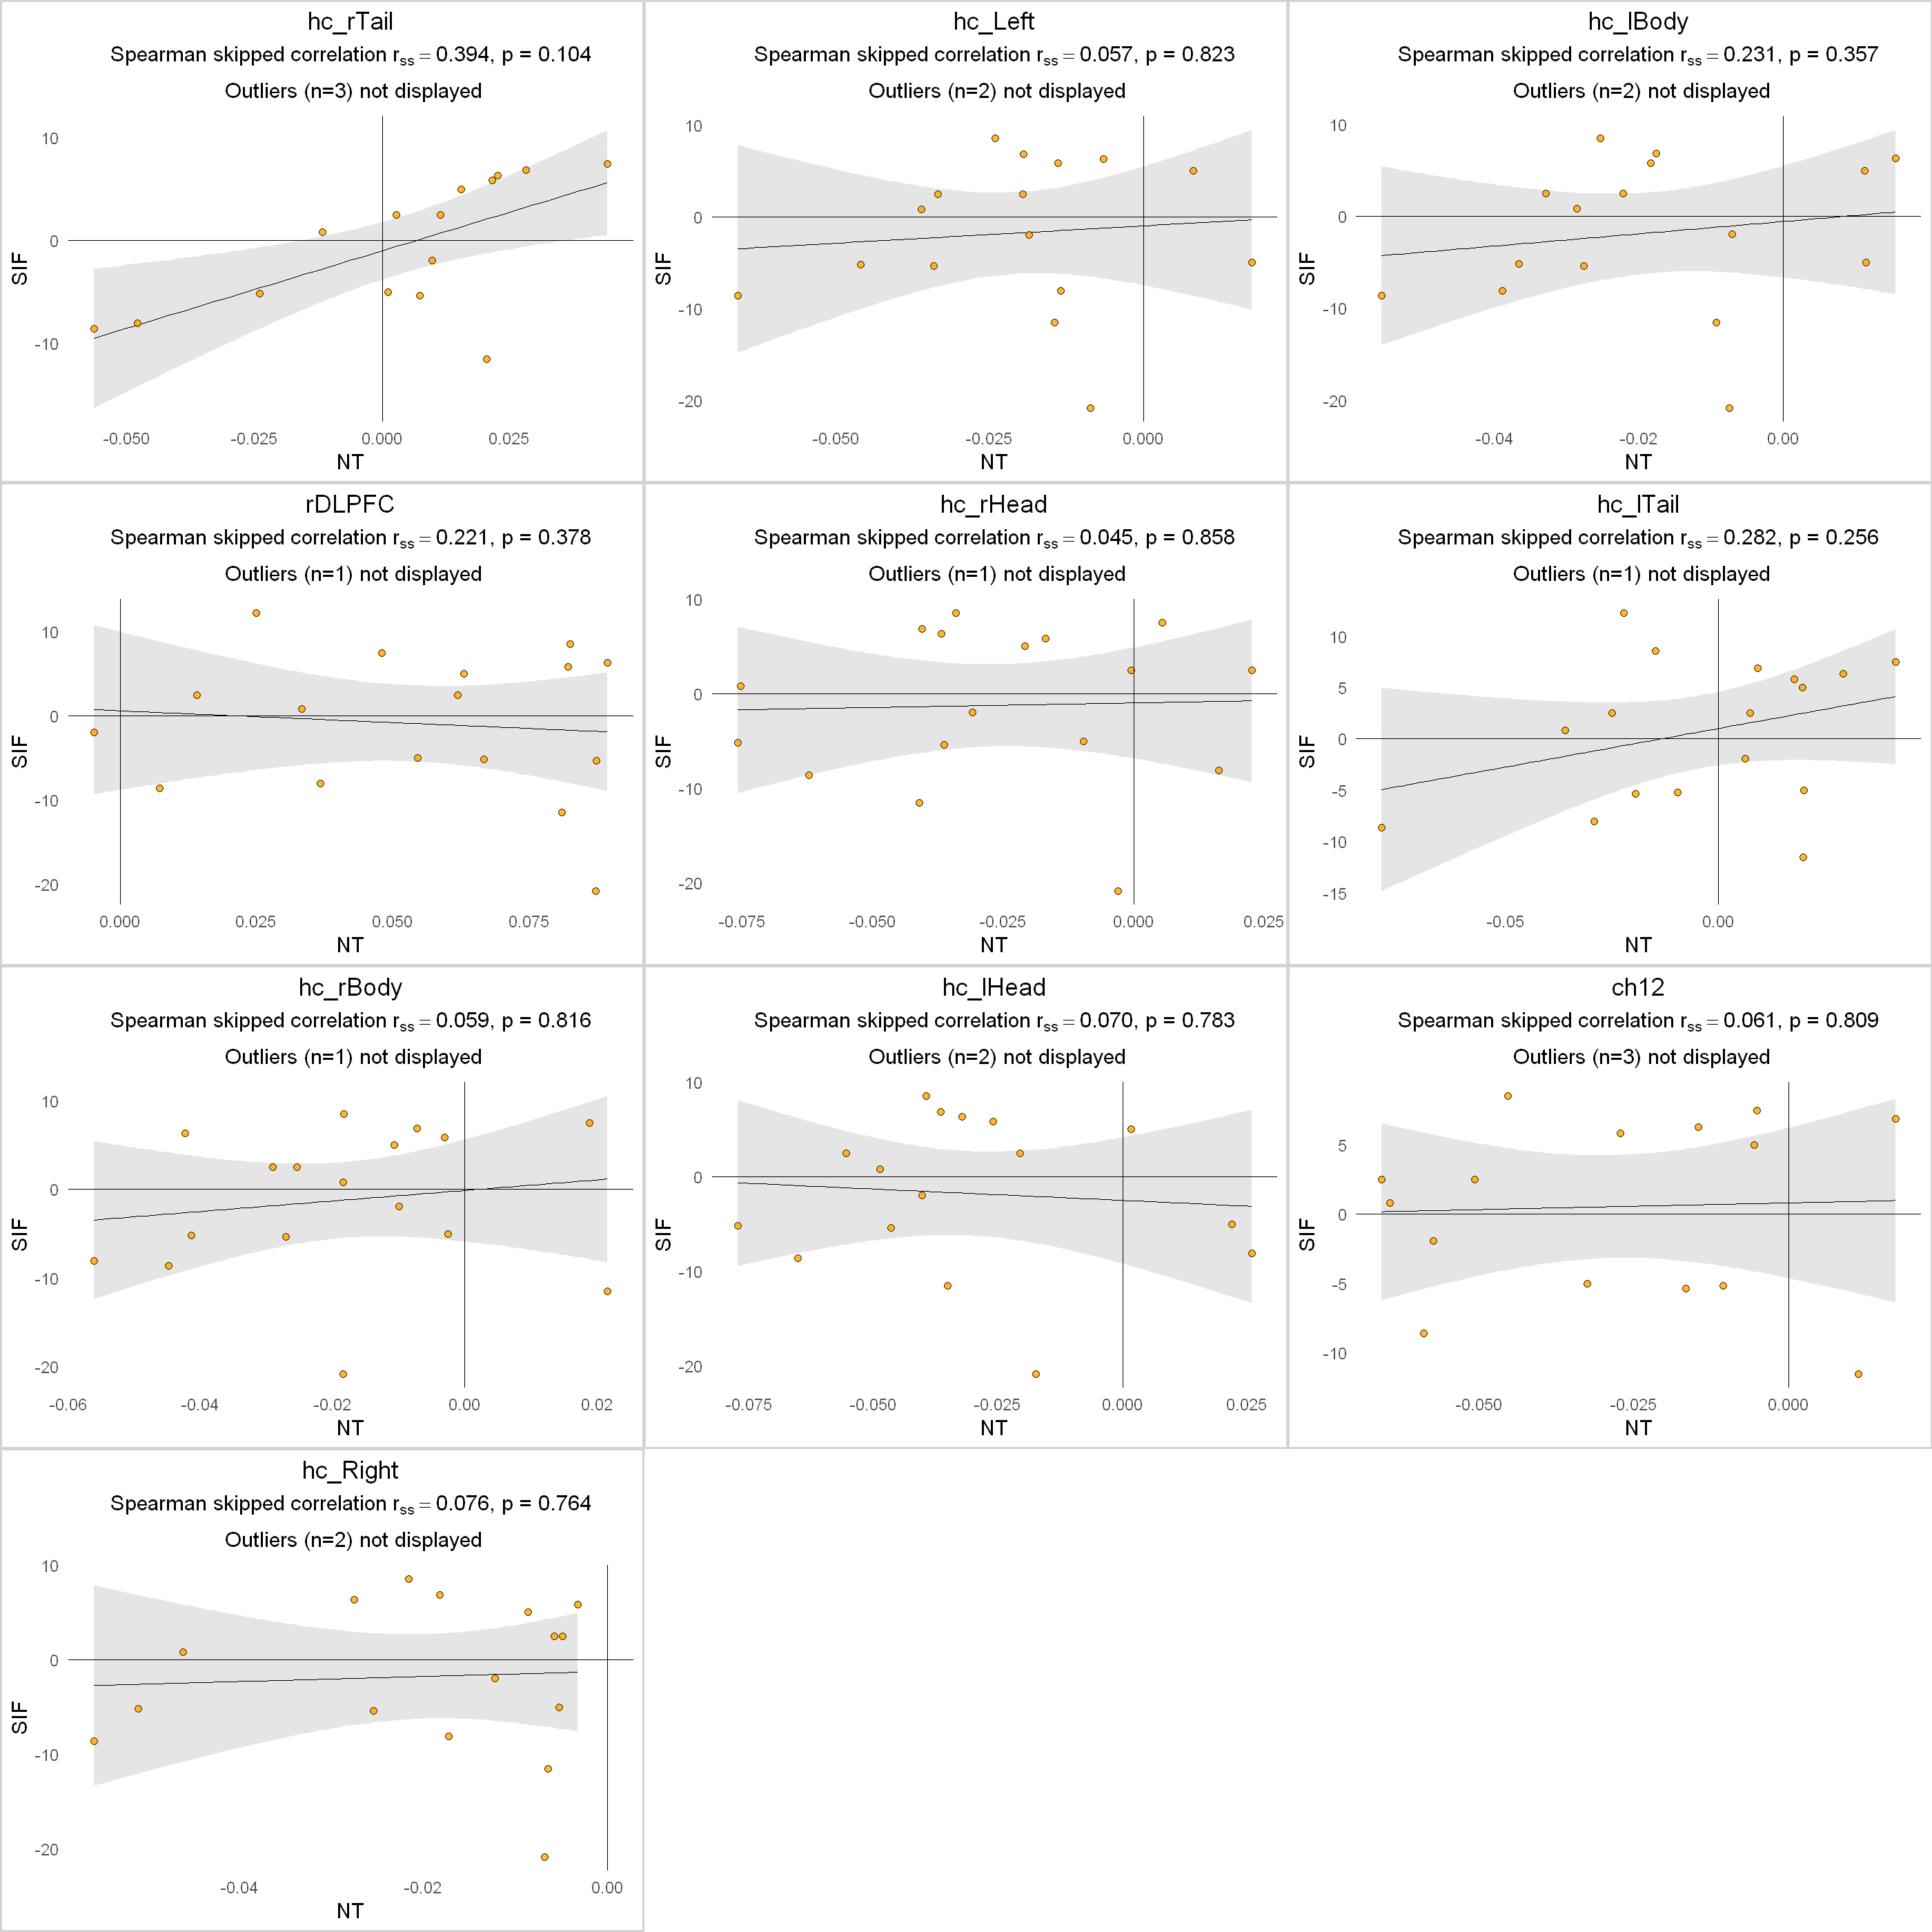

In [71]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "05_Yuhua"

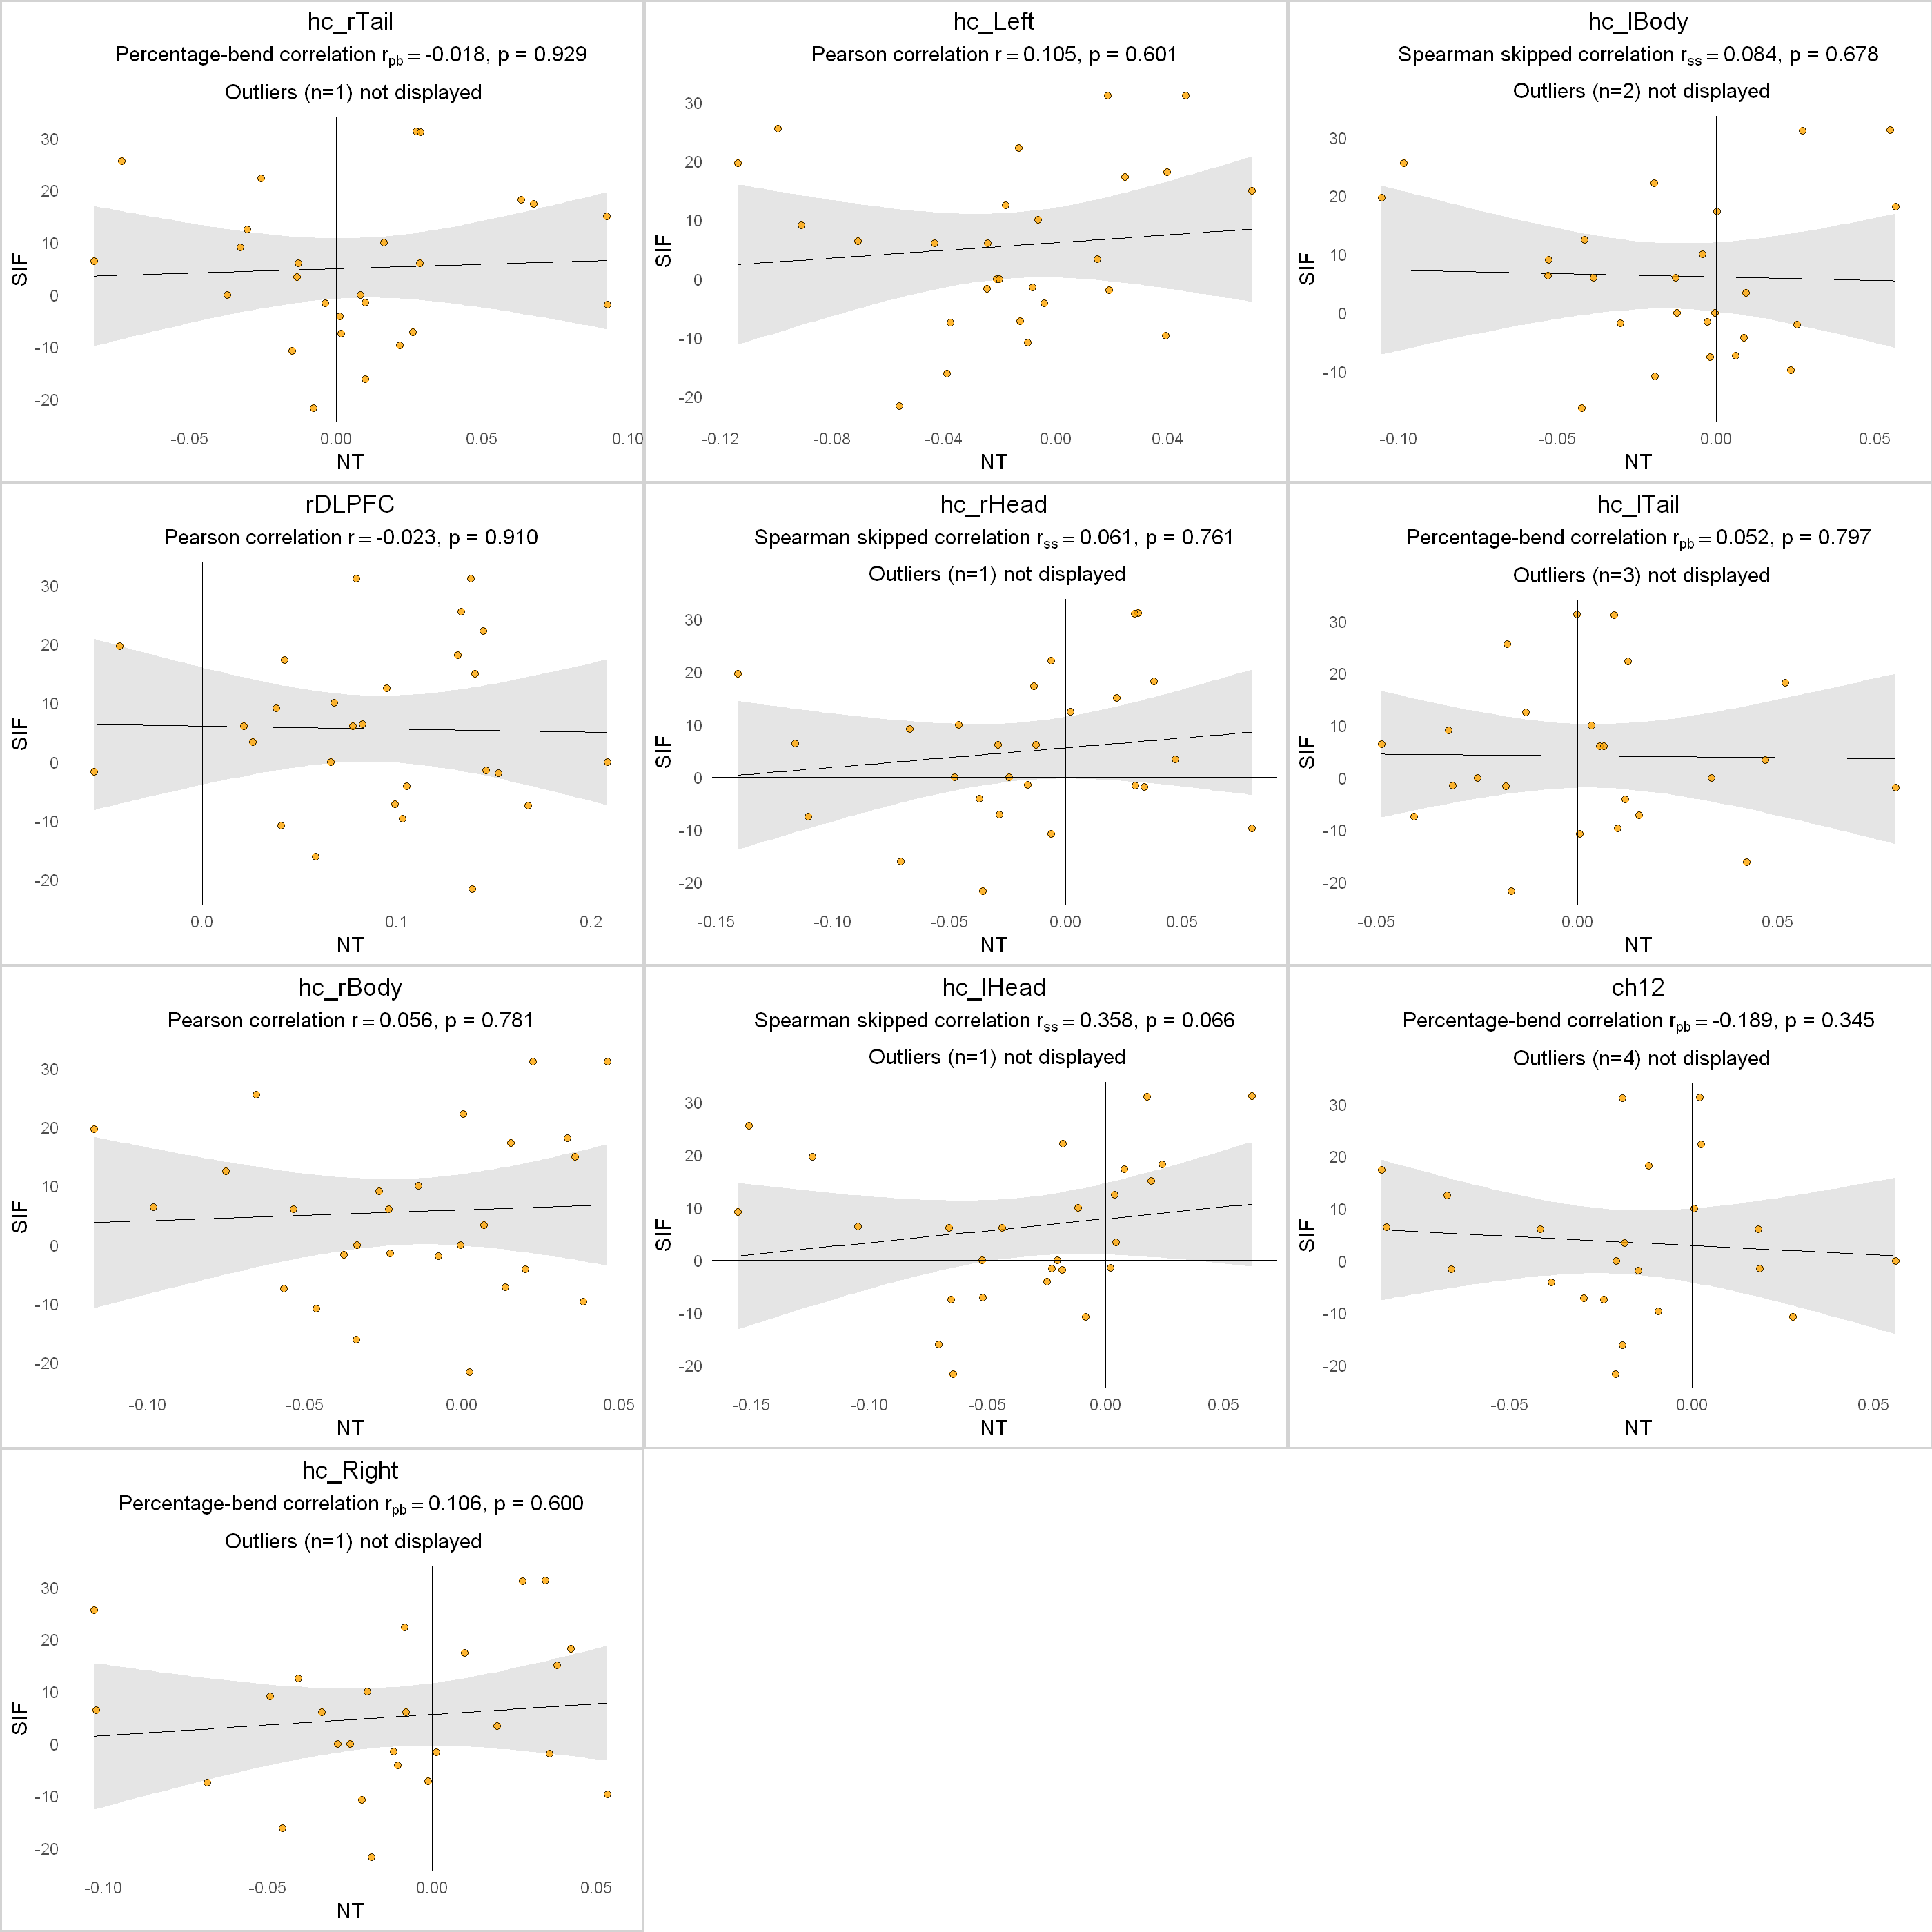

In [50]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "06_RolandNeuron"

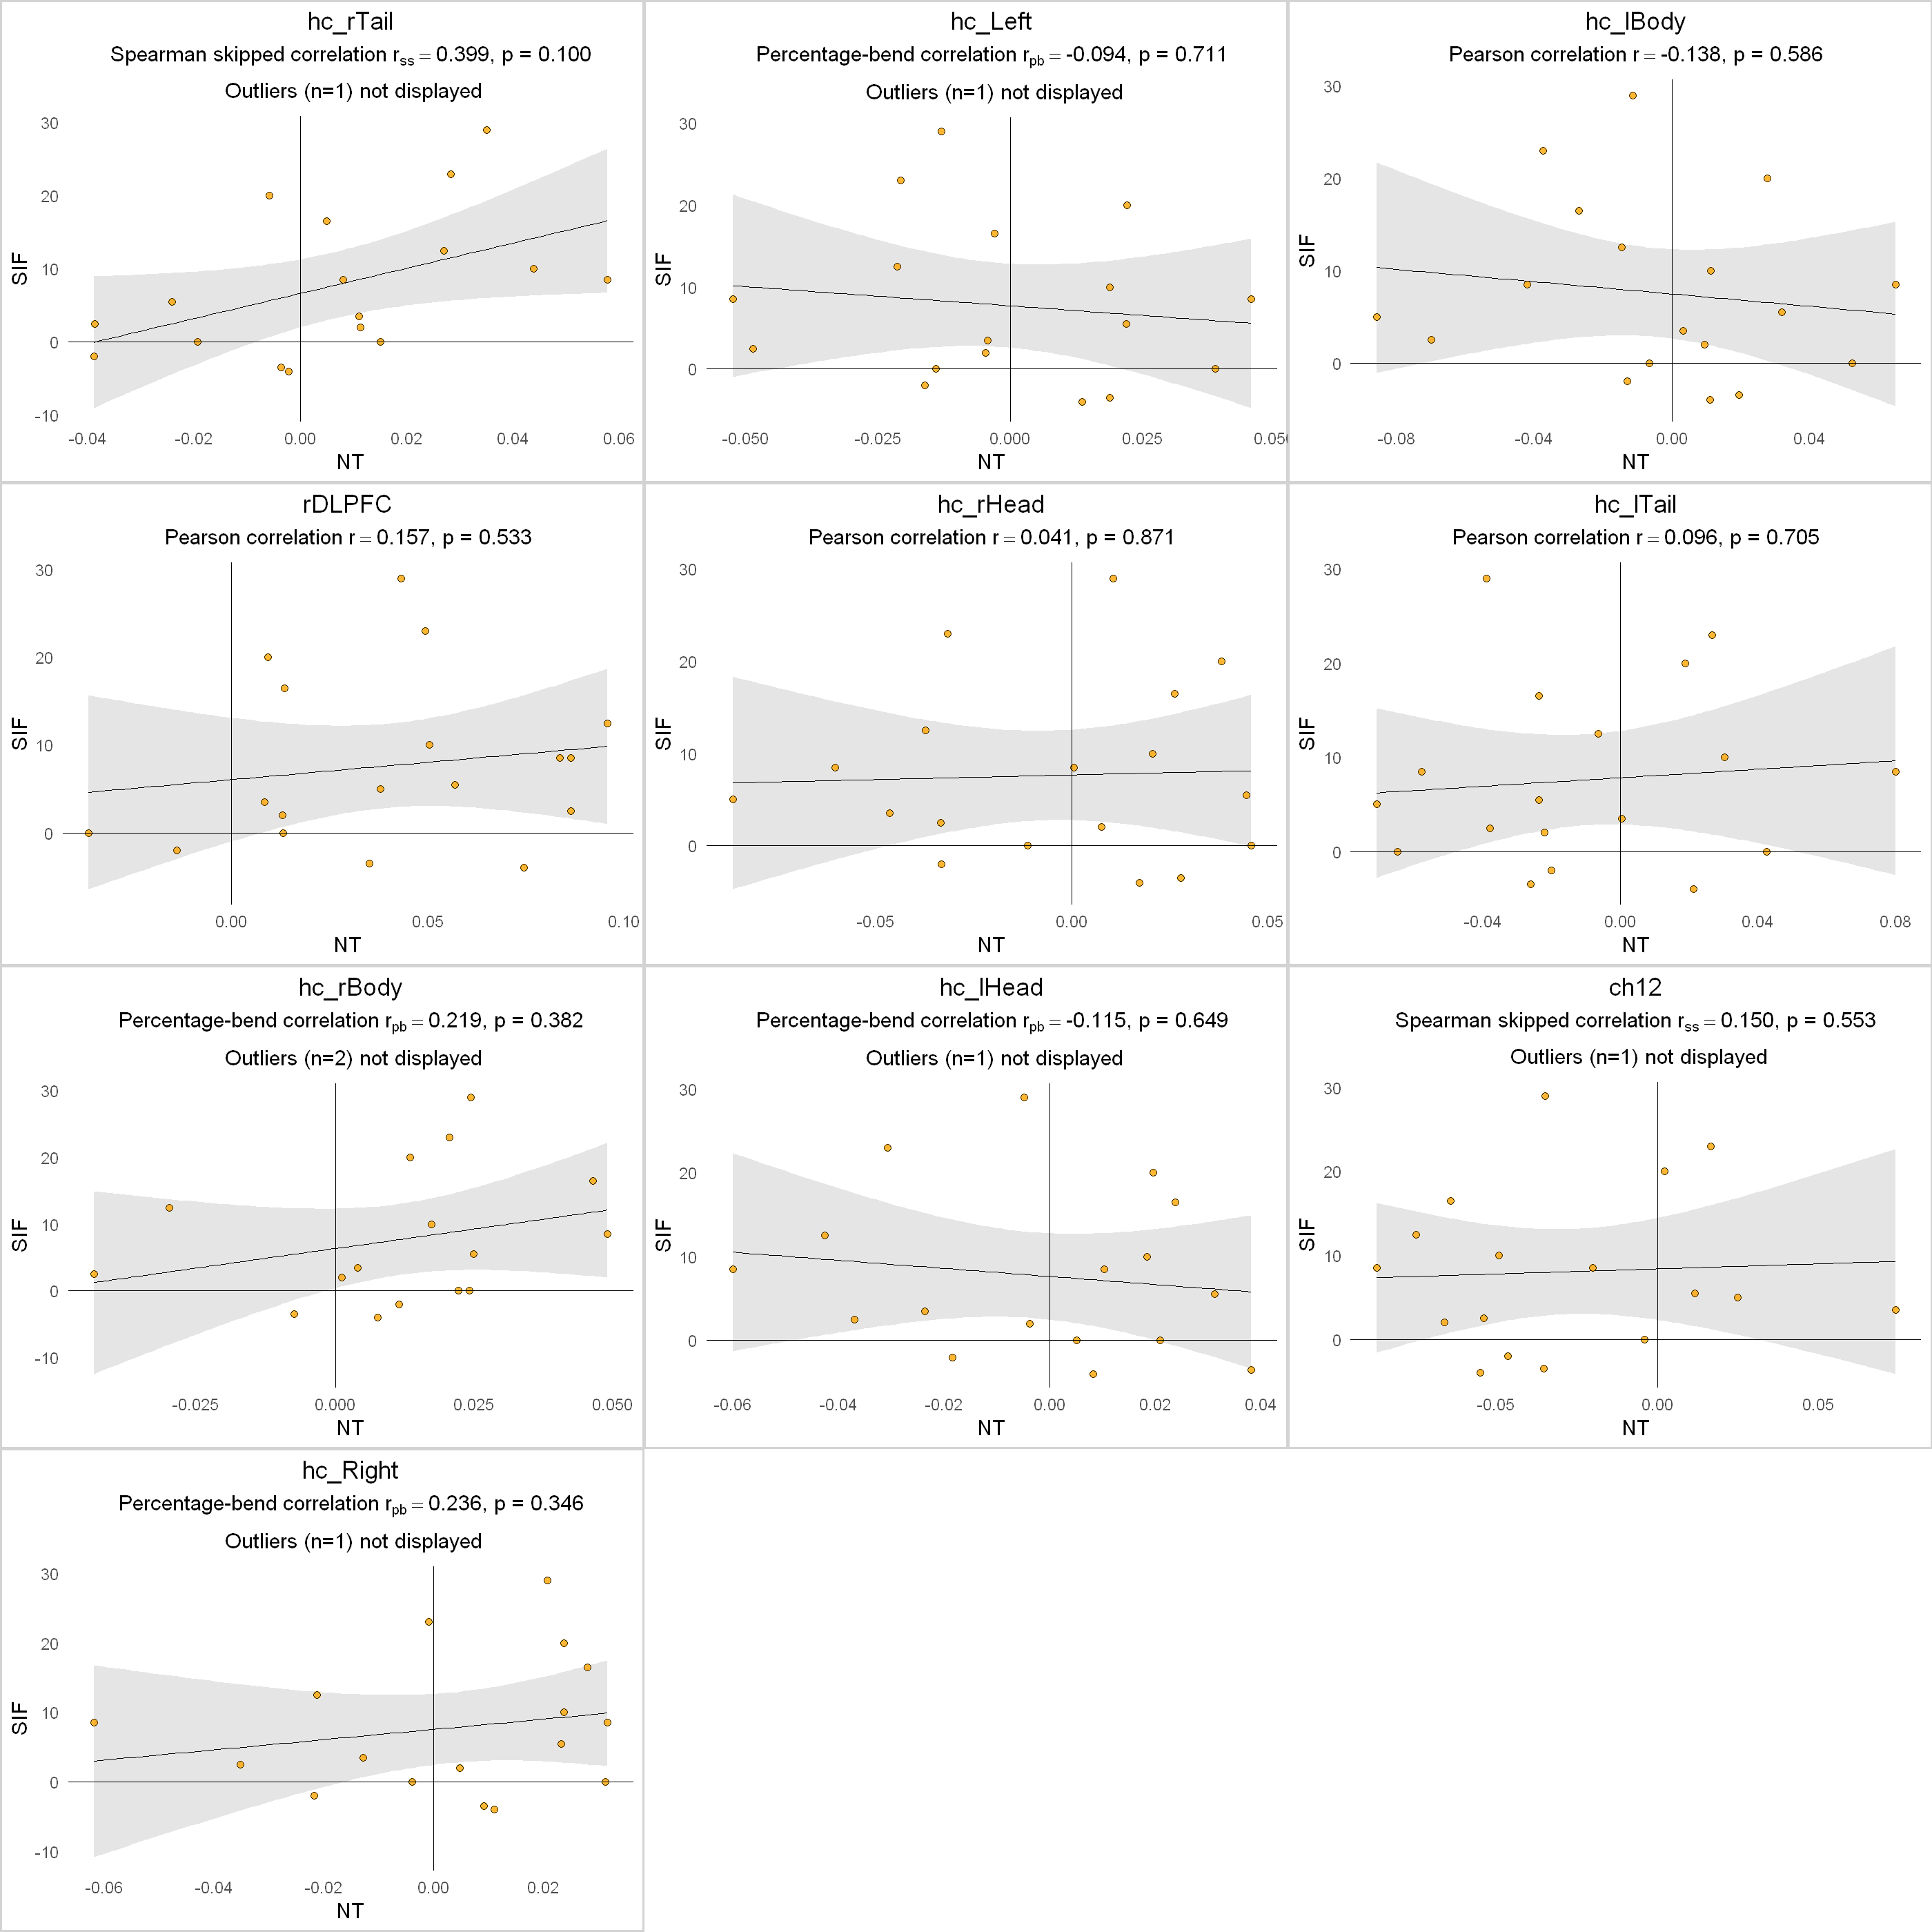

In [51]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "08_Taylor"

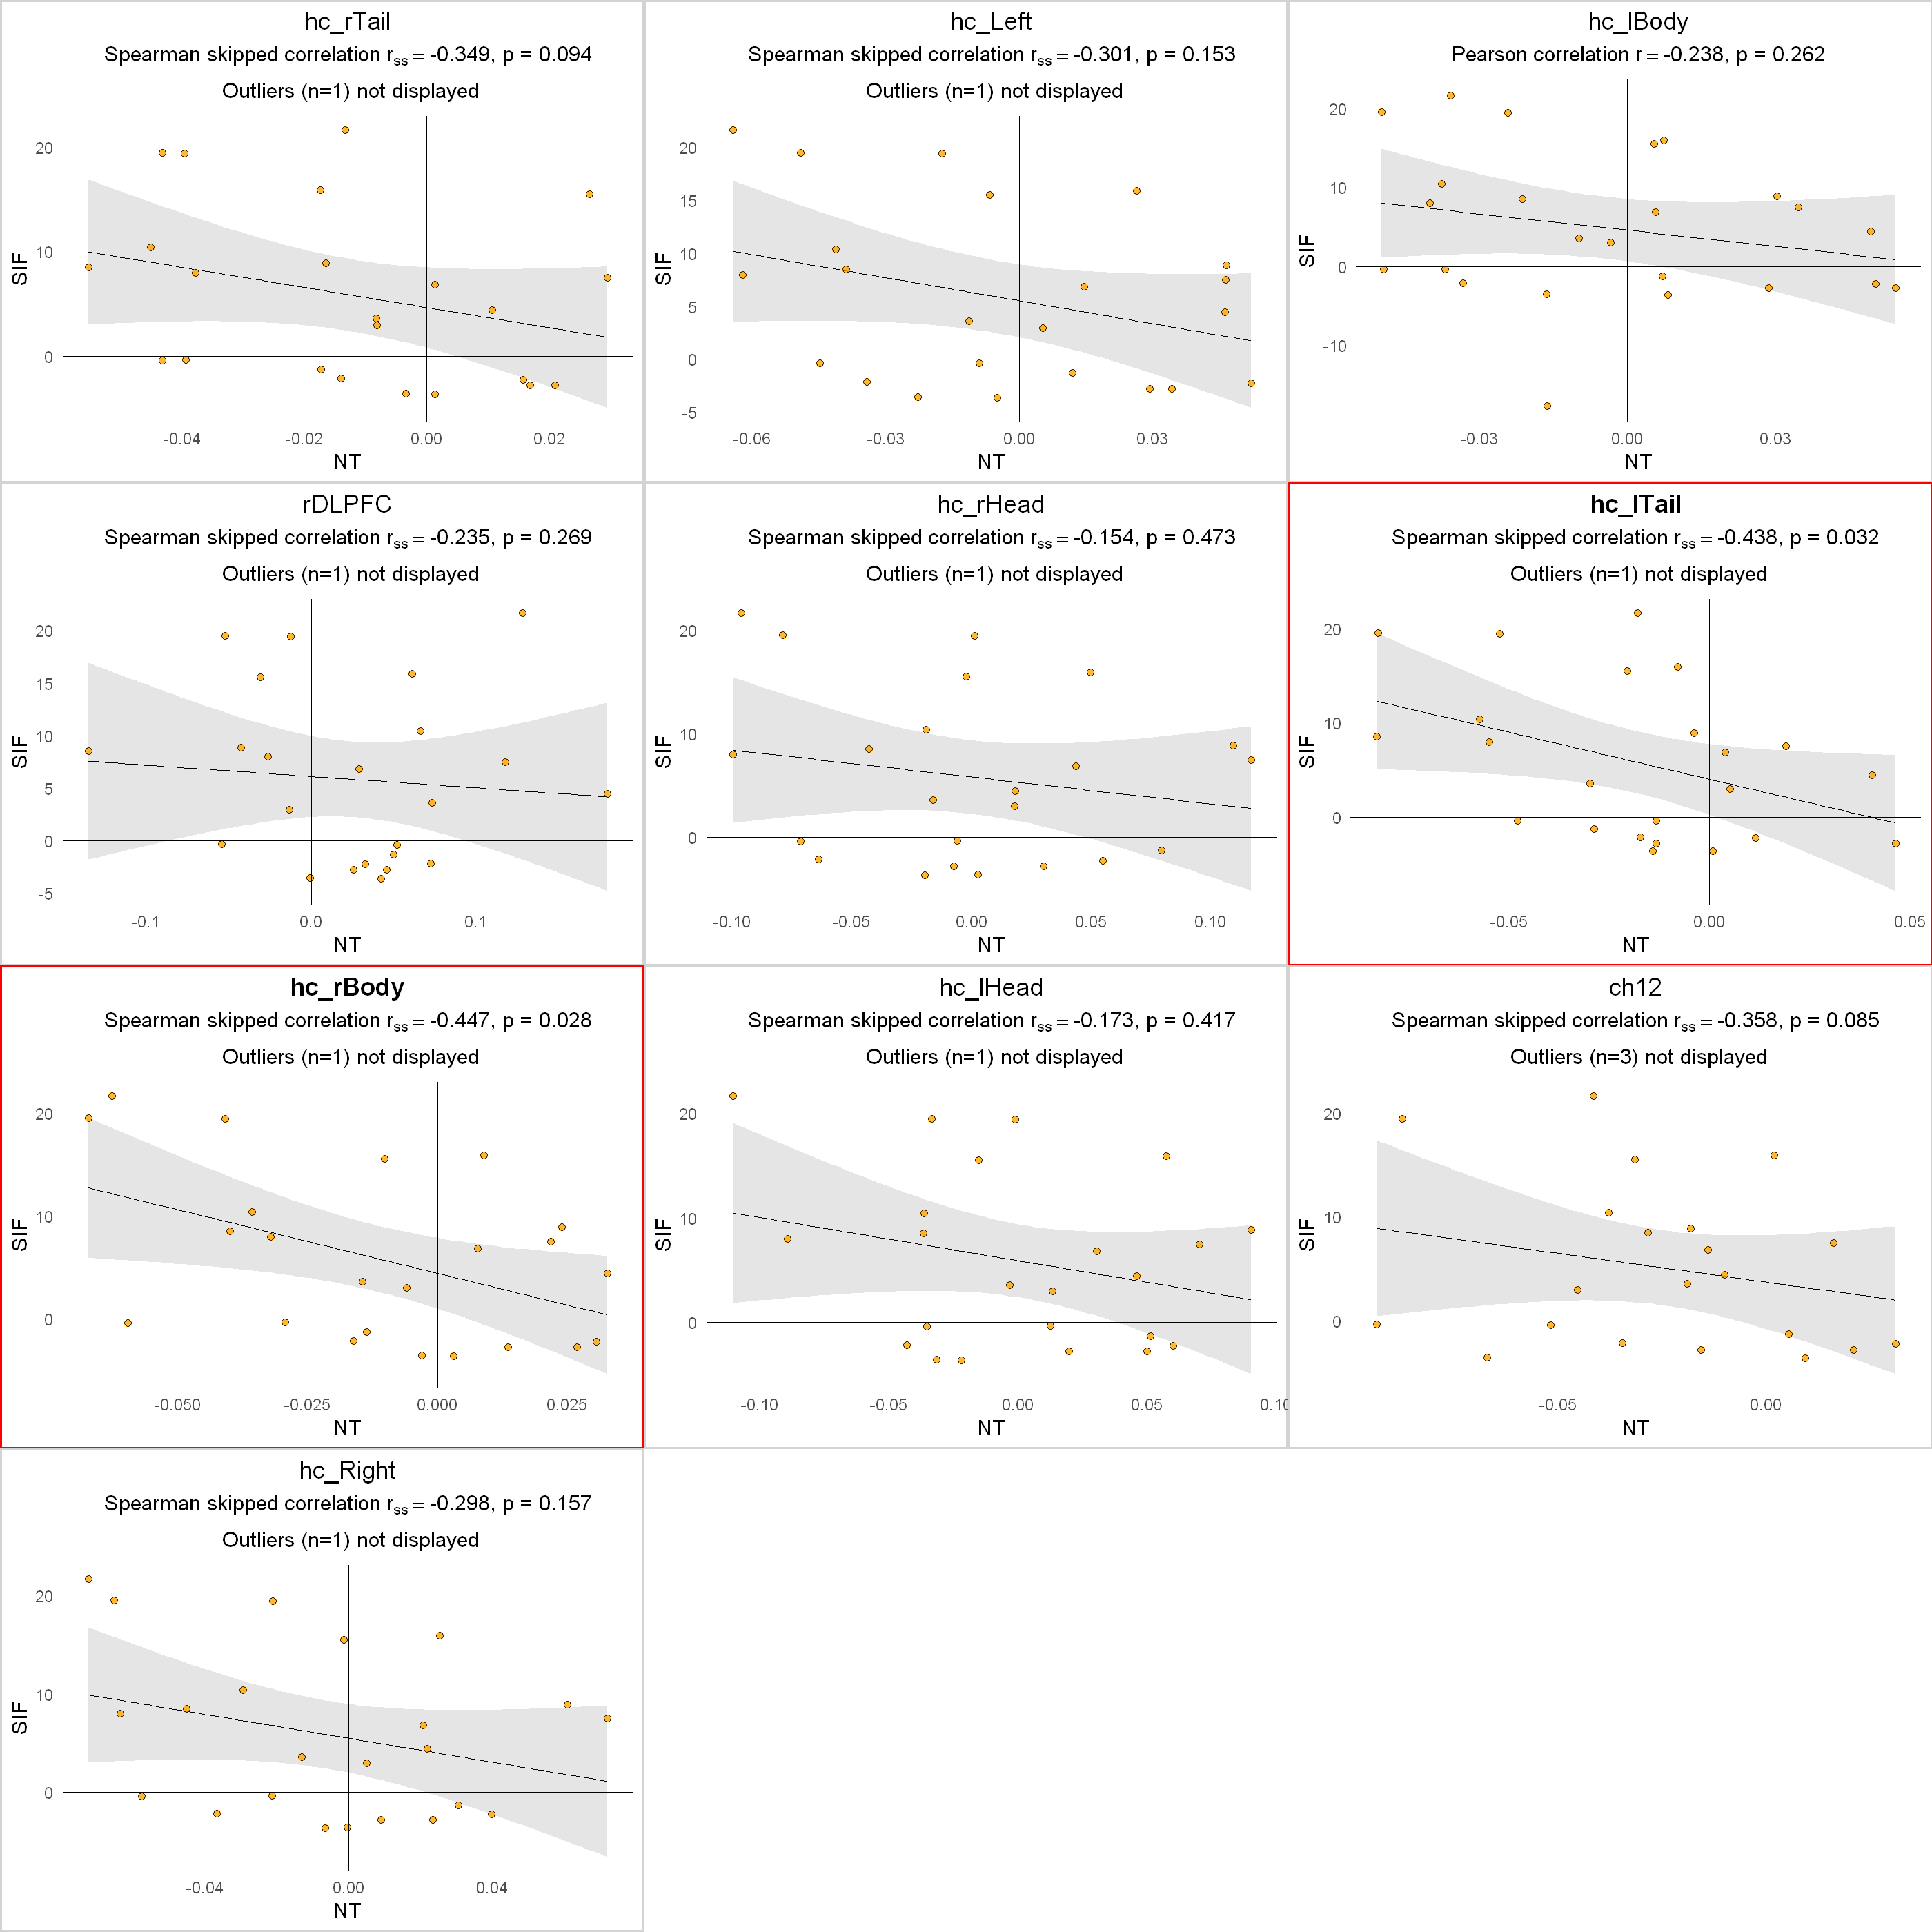

In [52]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "09_Xu"

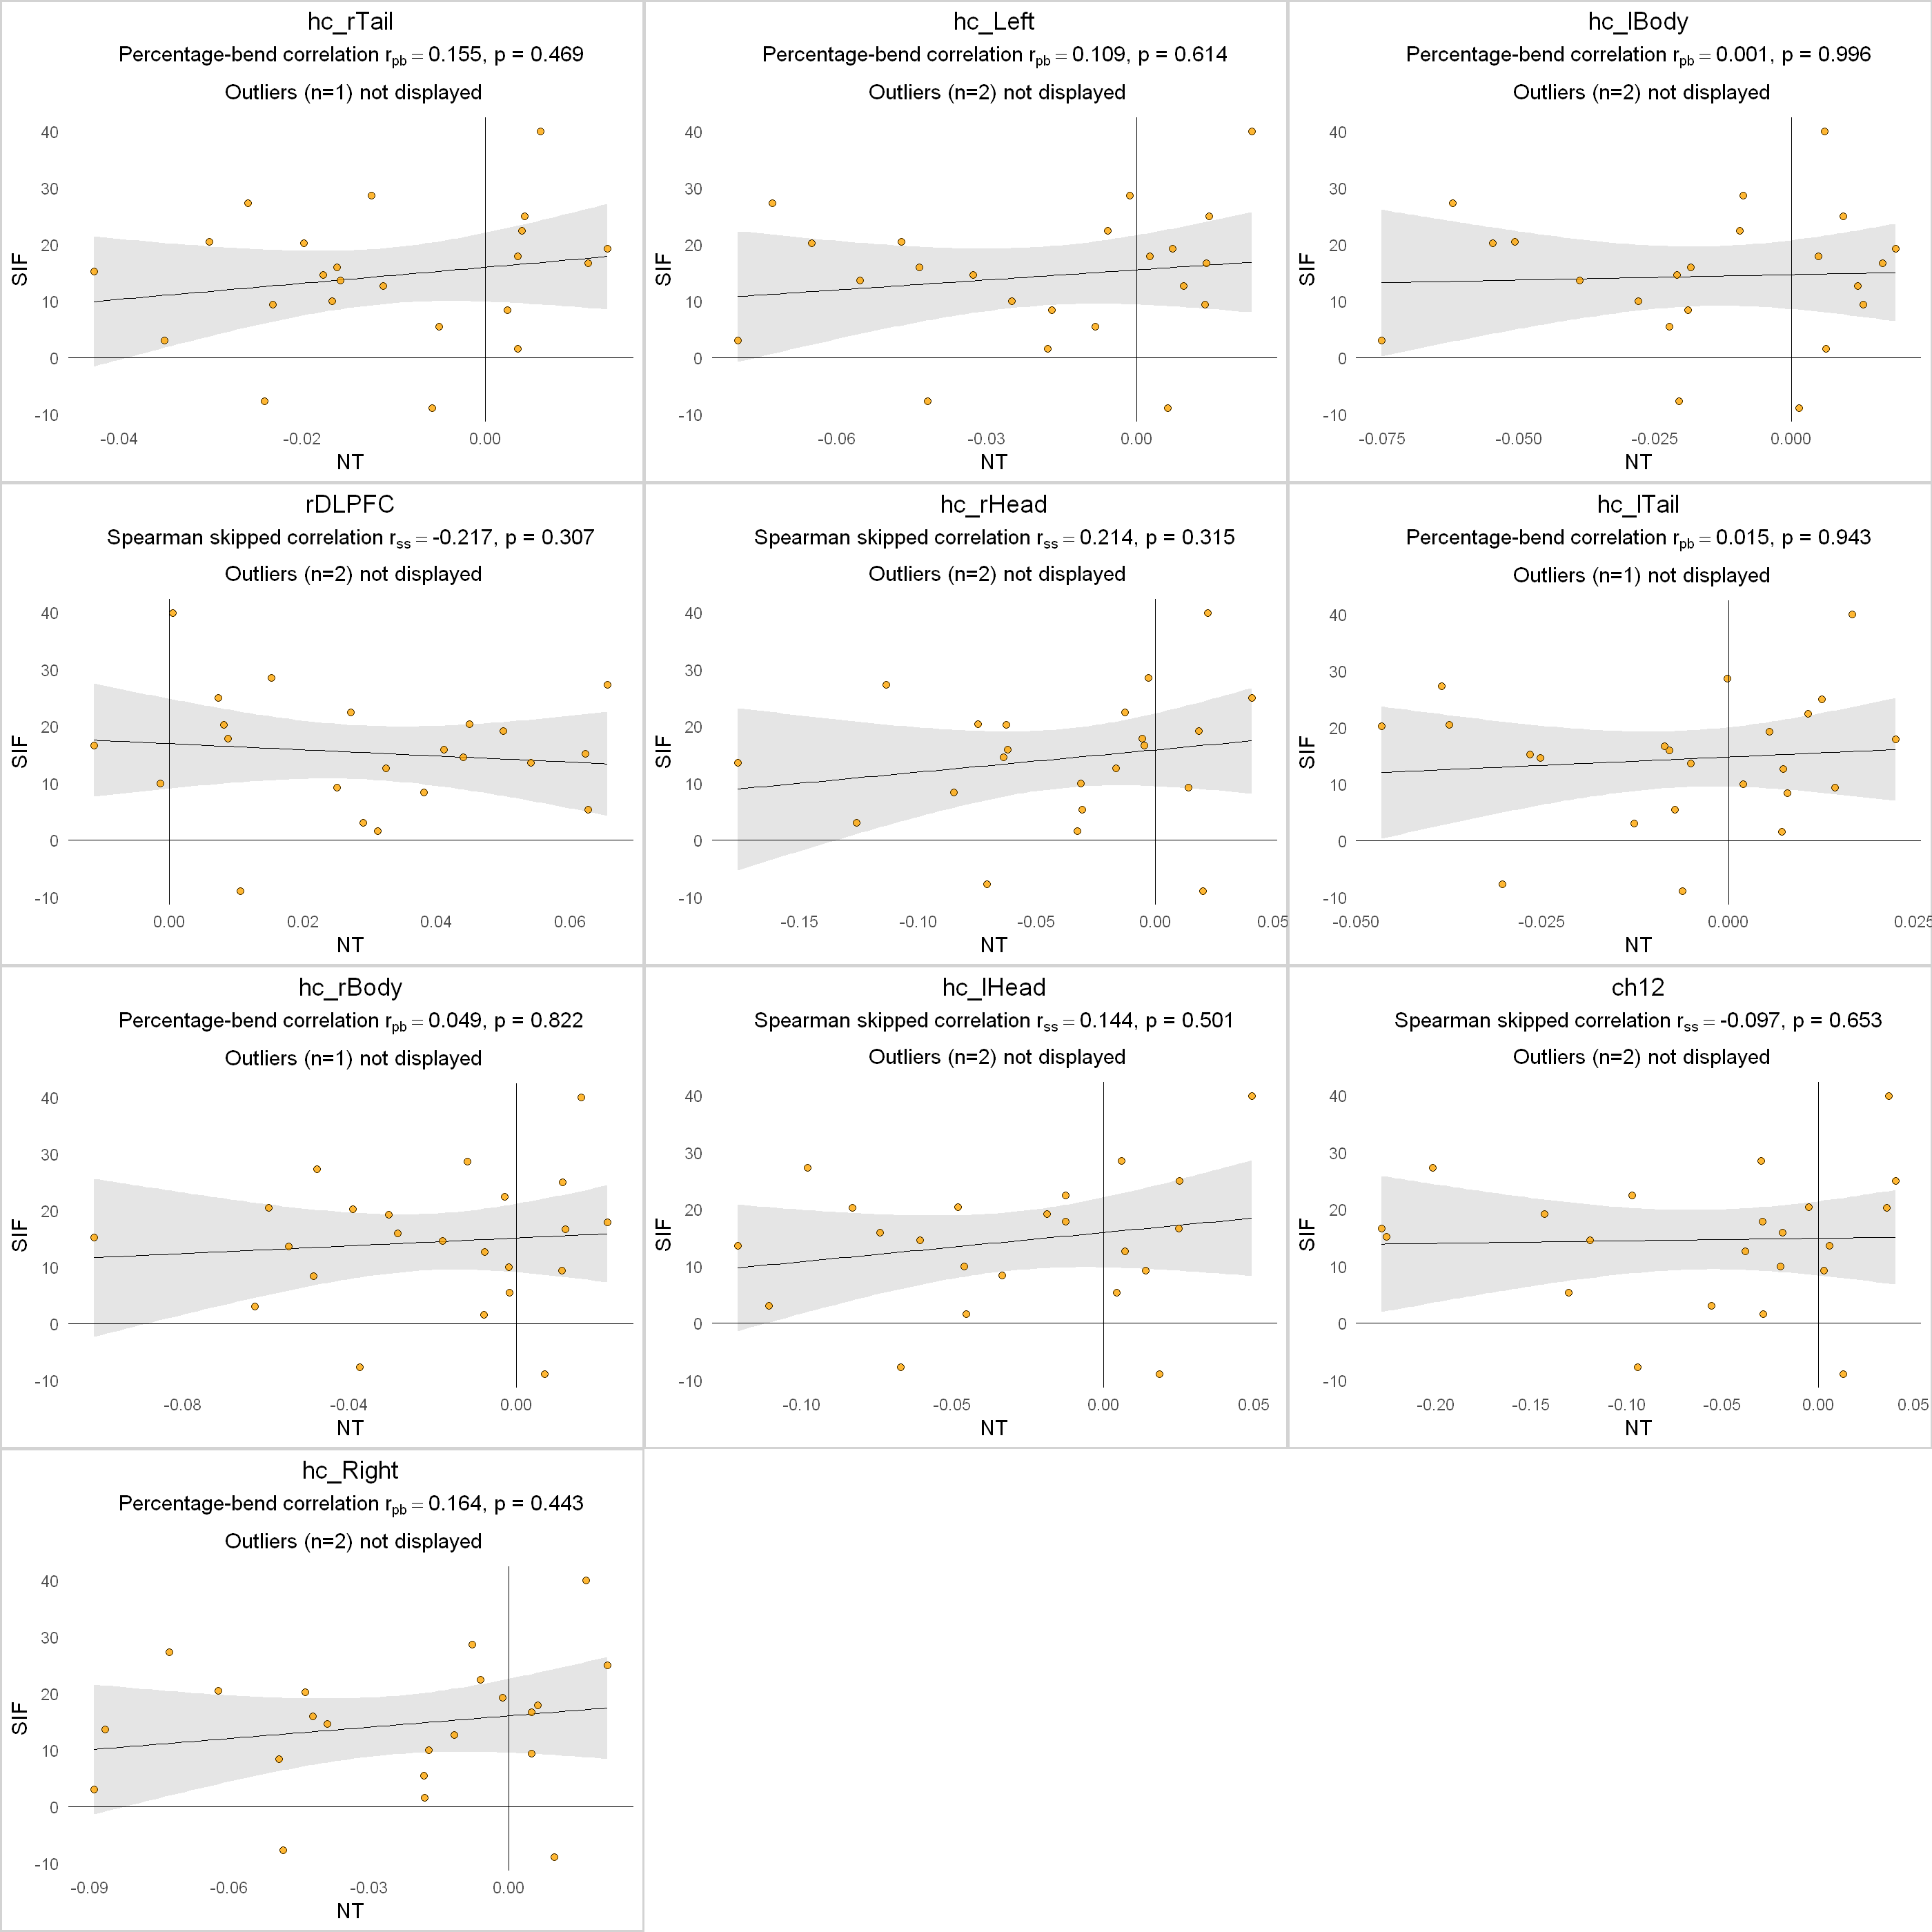

In [53]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "10_Big-TNT"

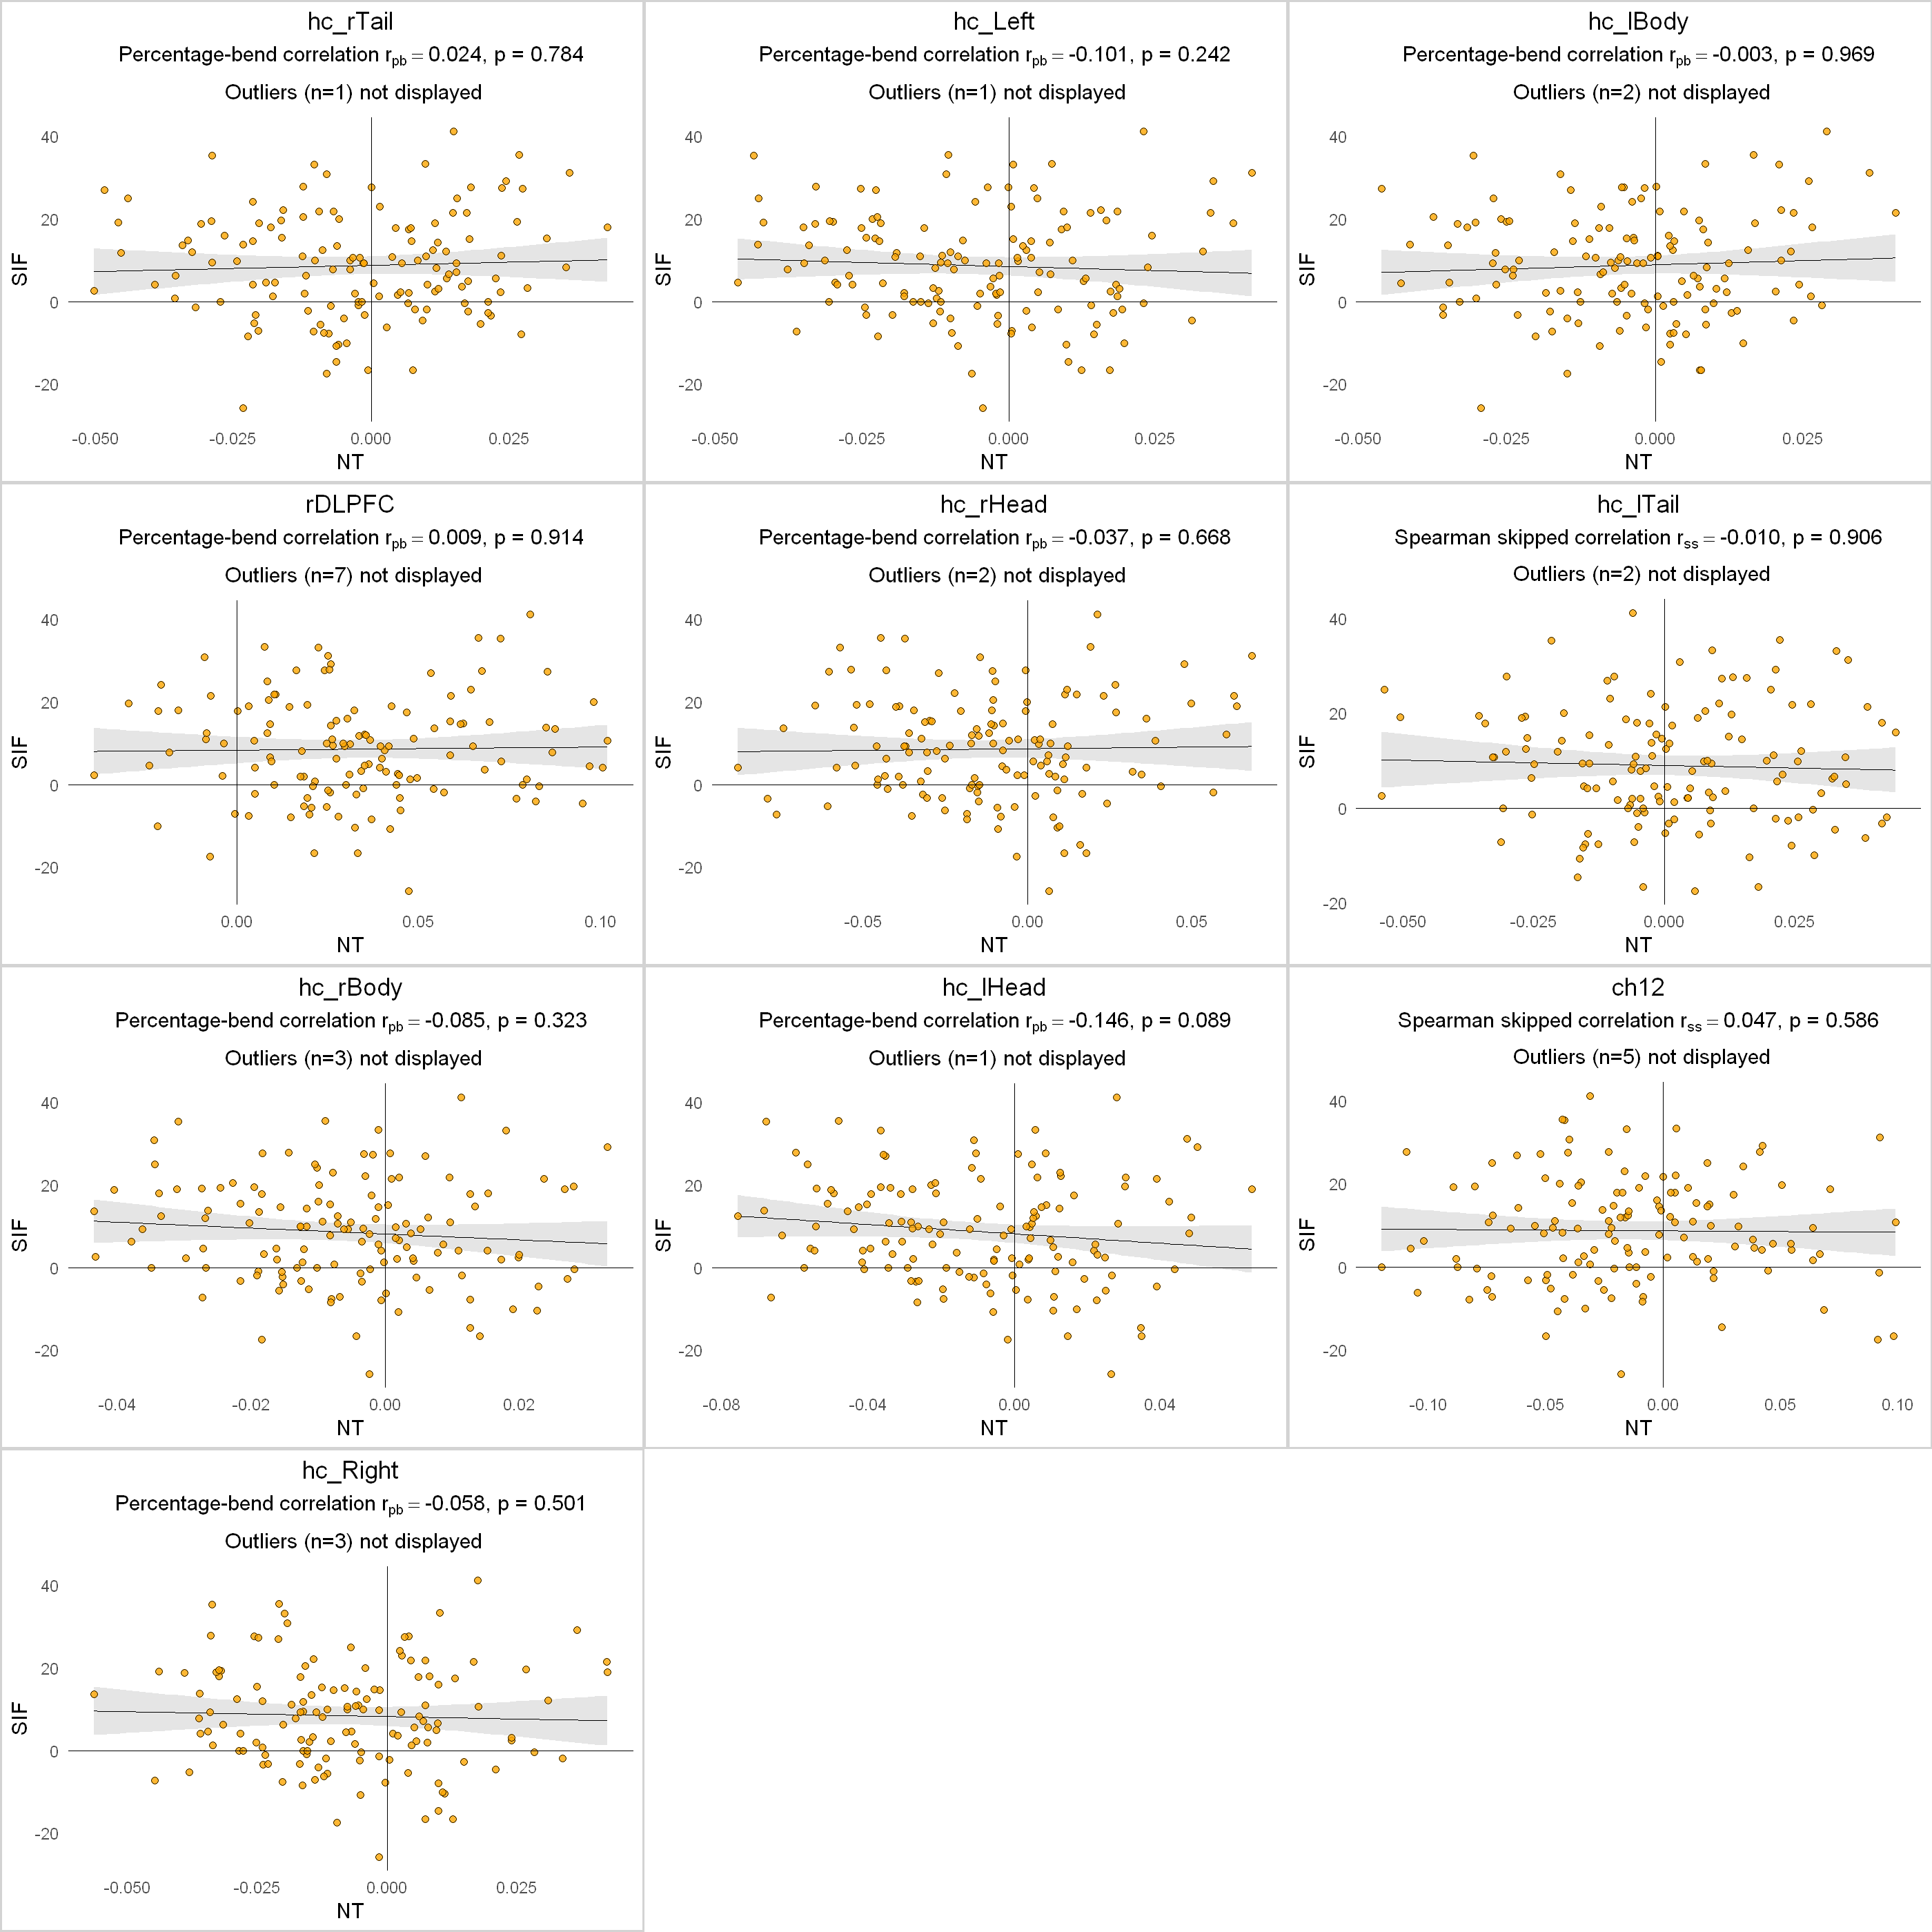

In [54]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

## Think

[1] "01_Levy1"

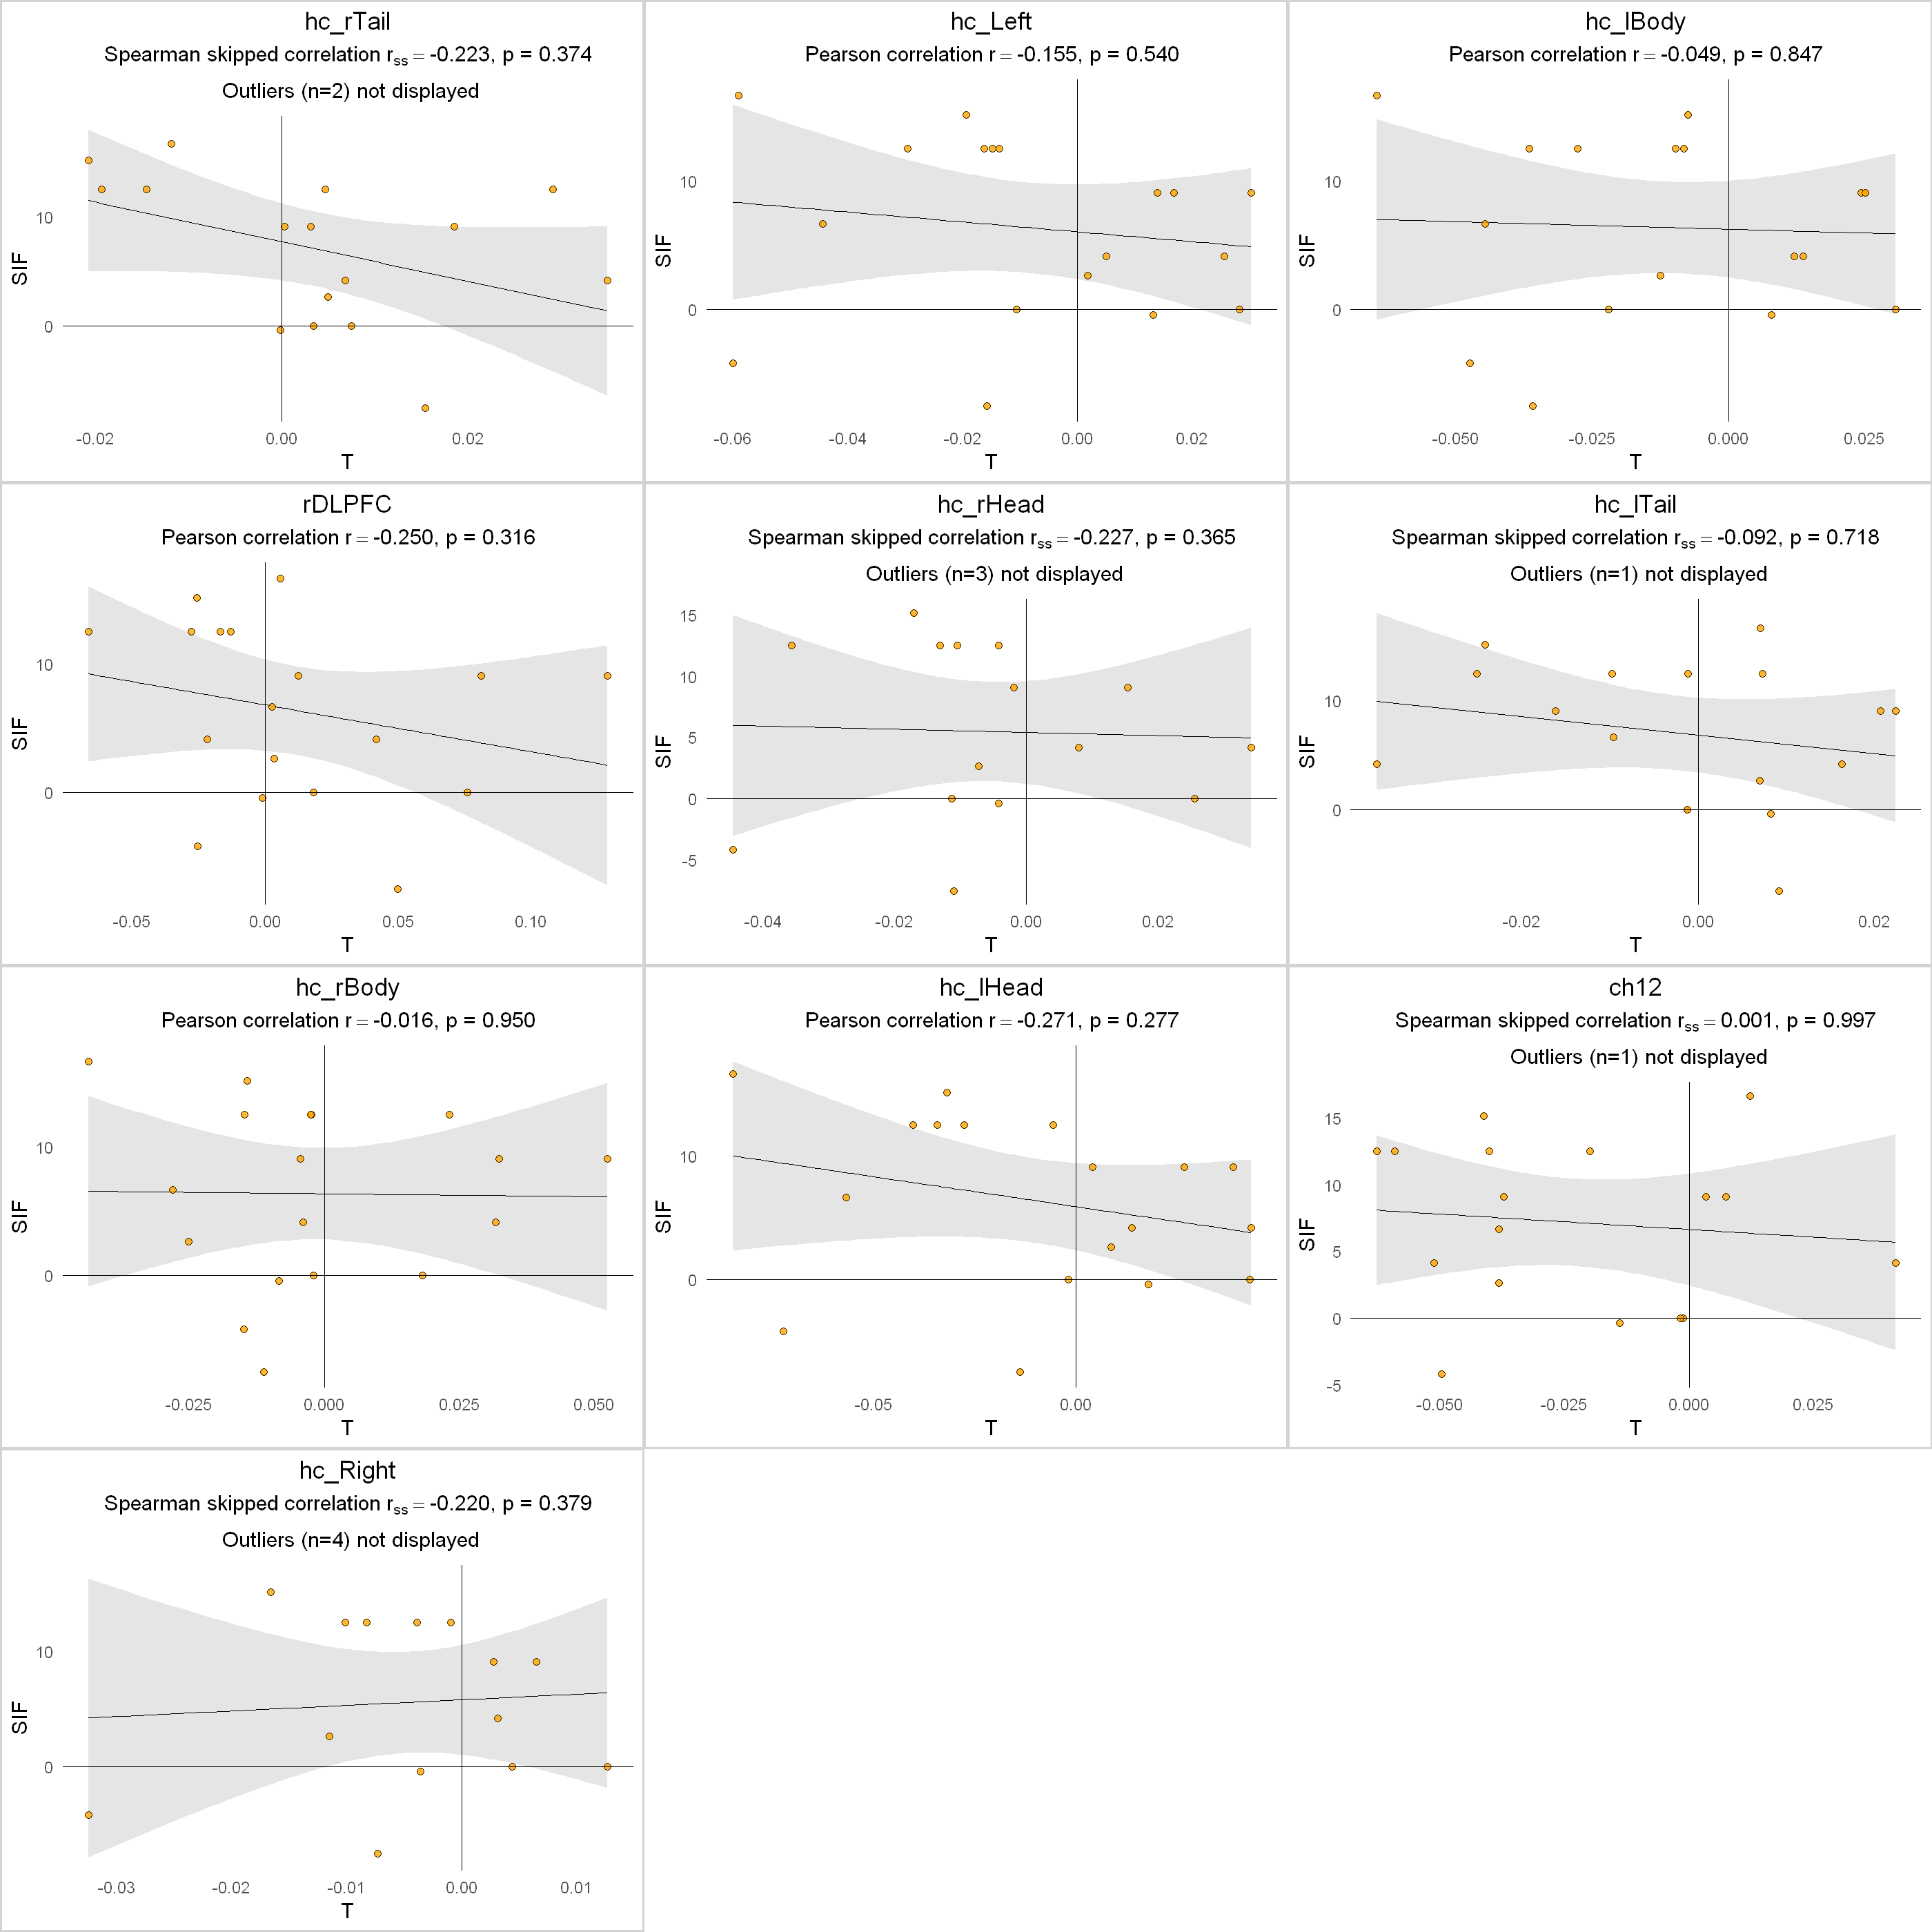

In [55]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "02_Levy2"

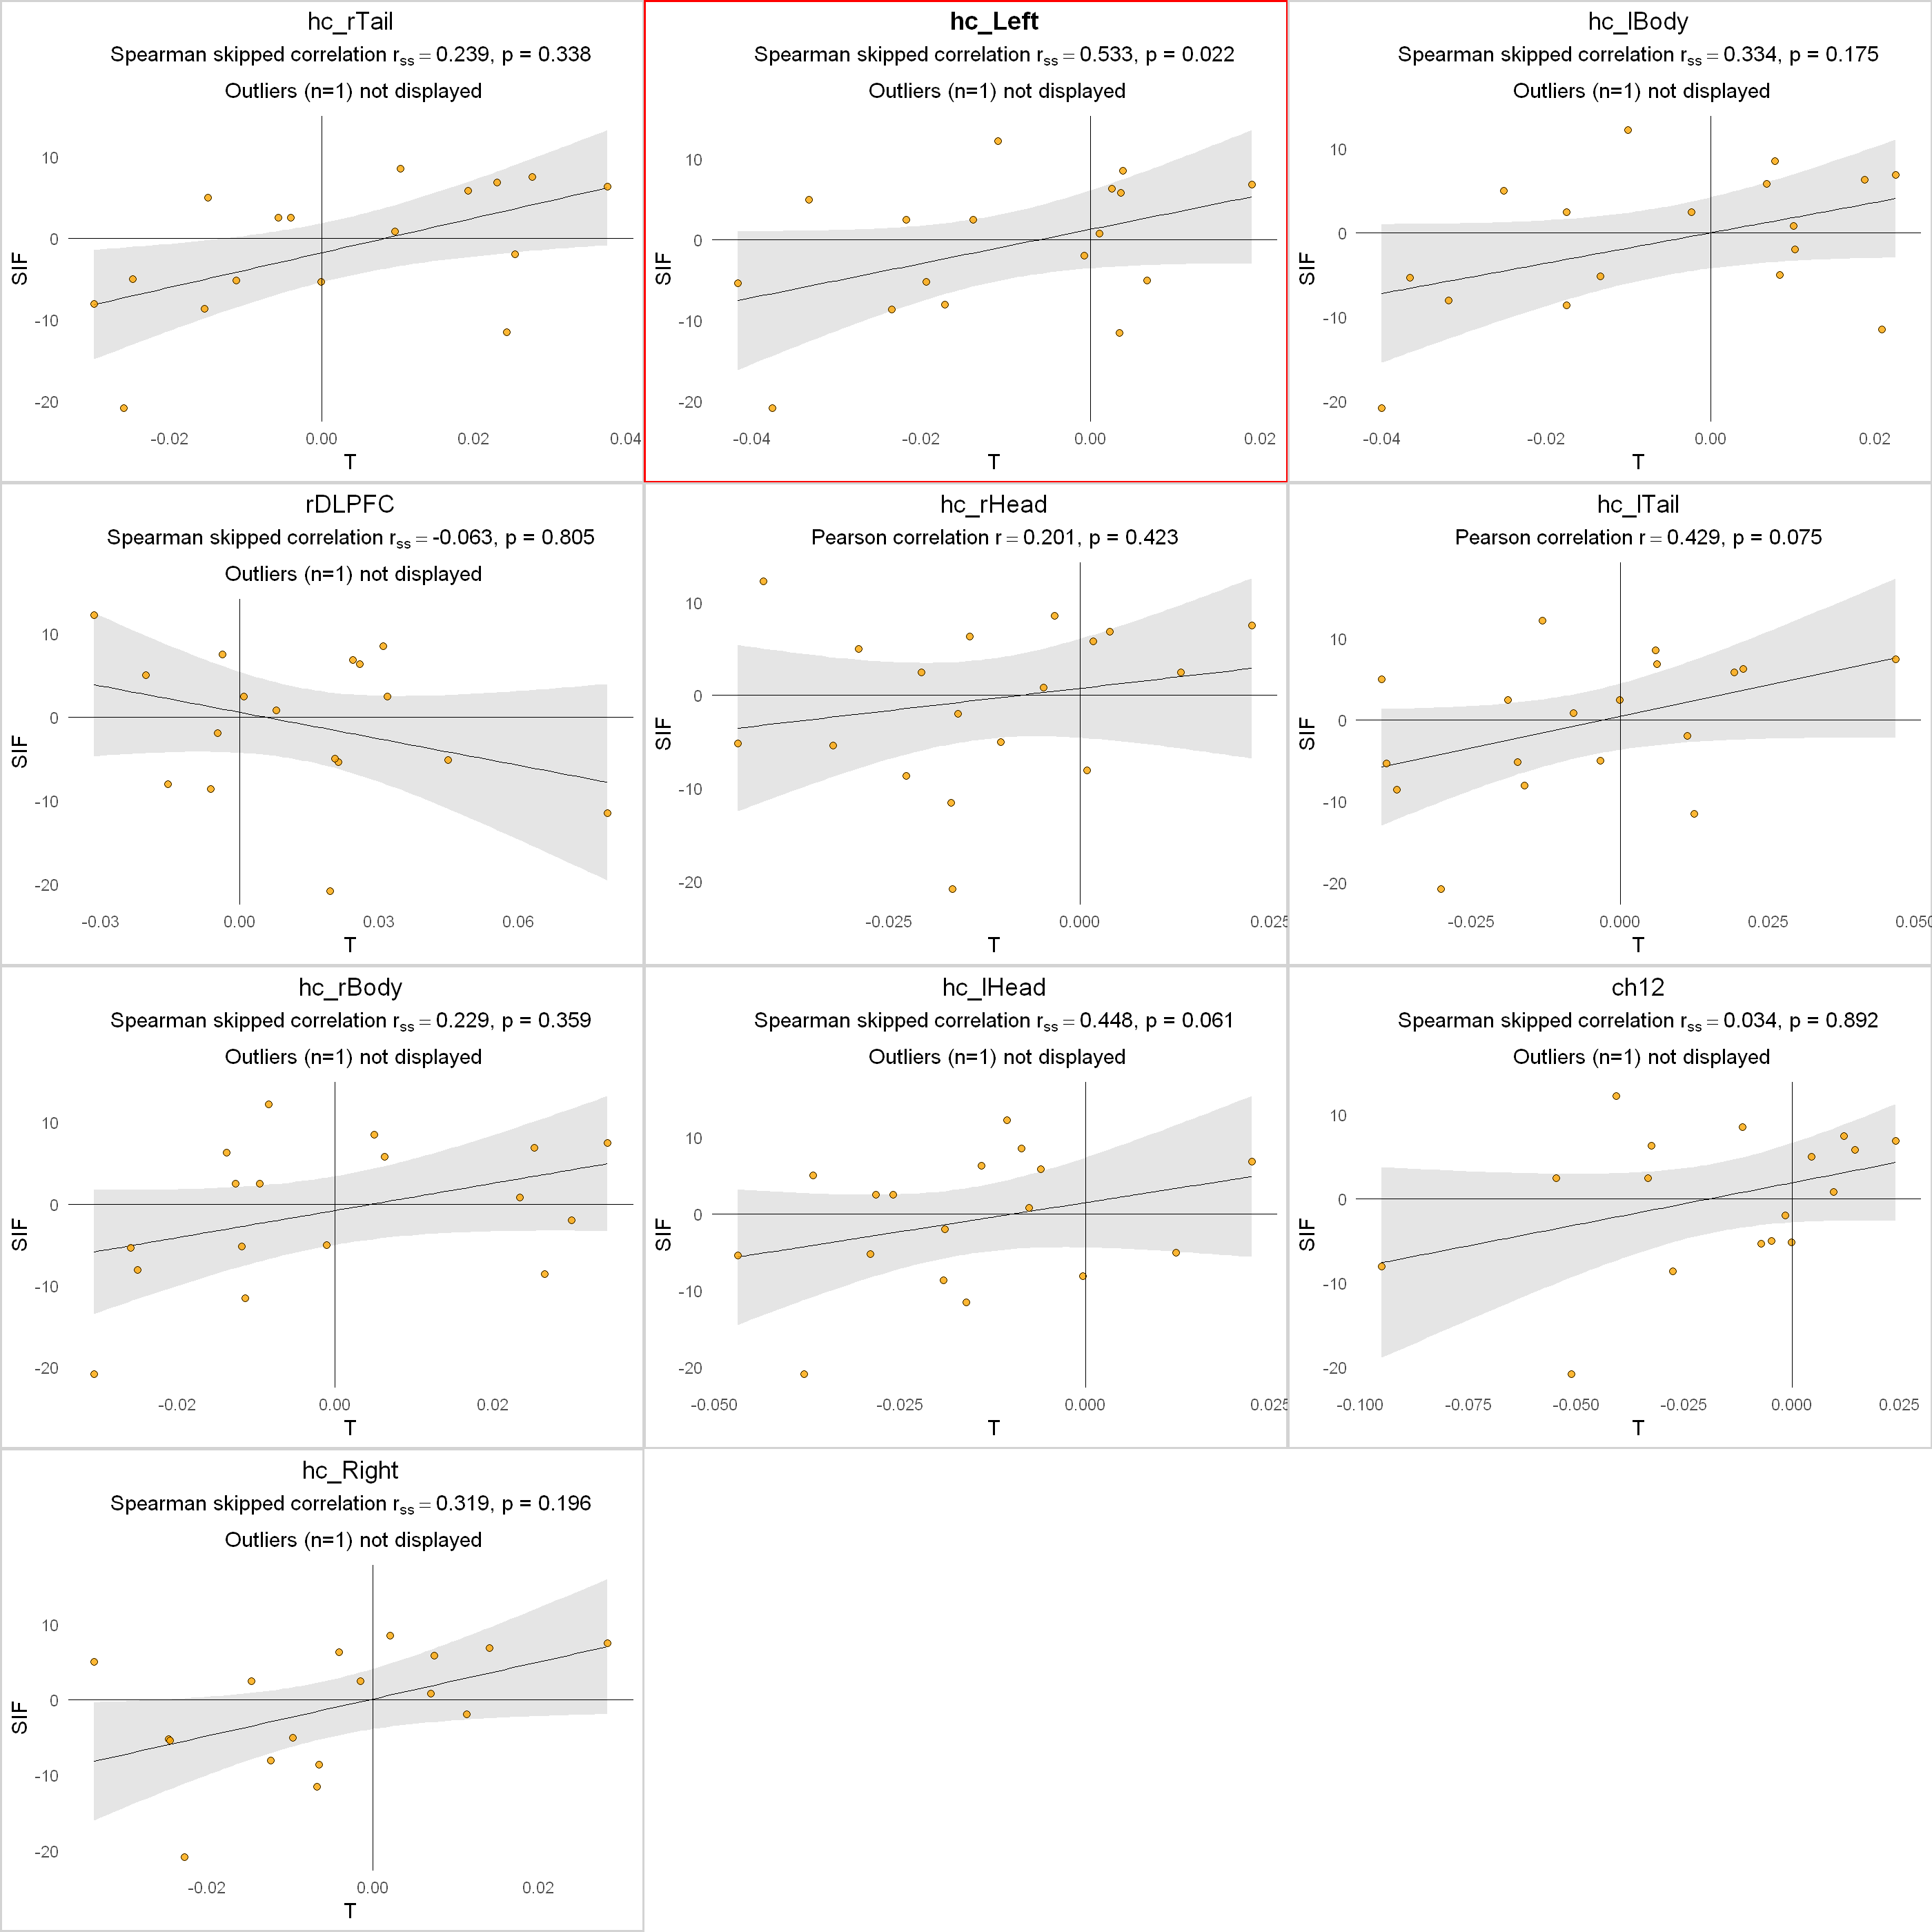

In [56]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "05_Yuhua"

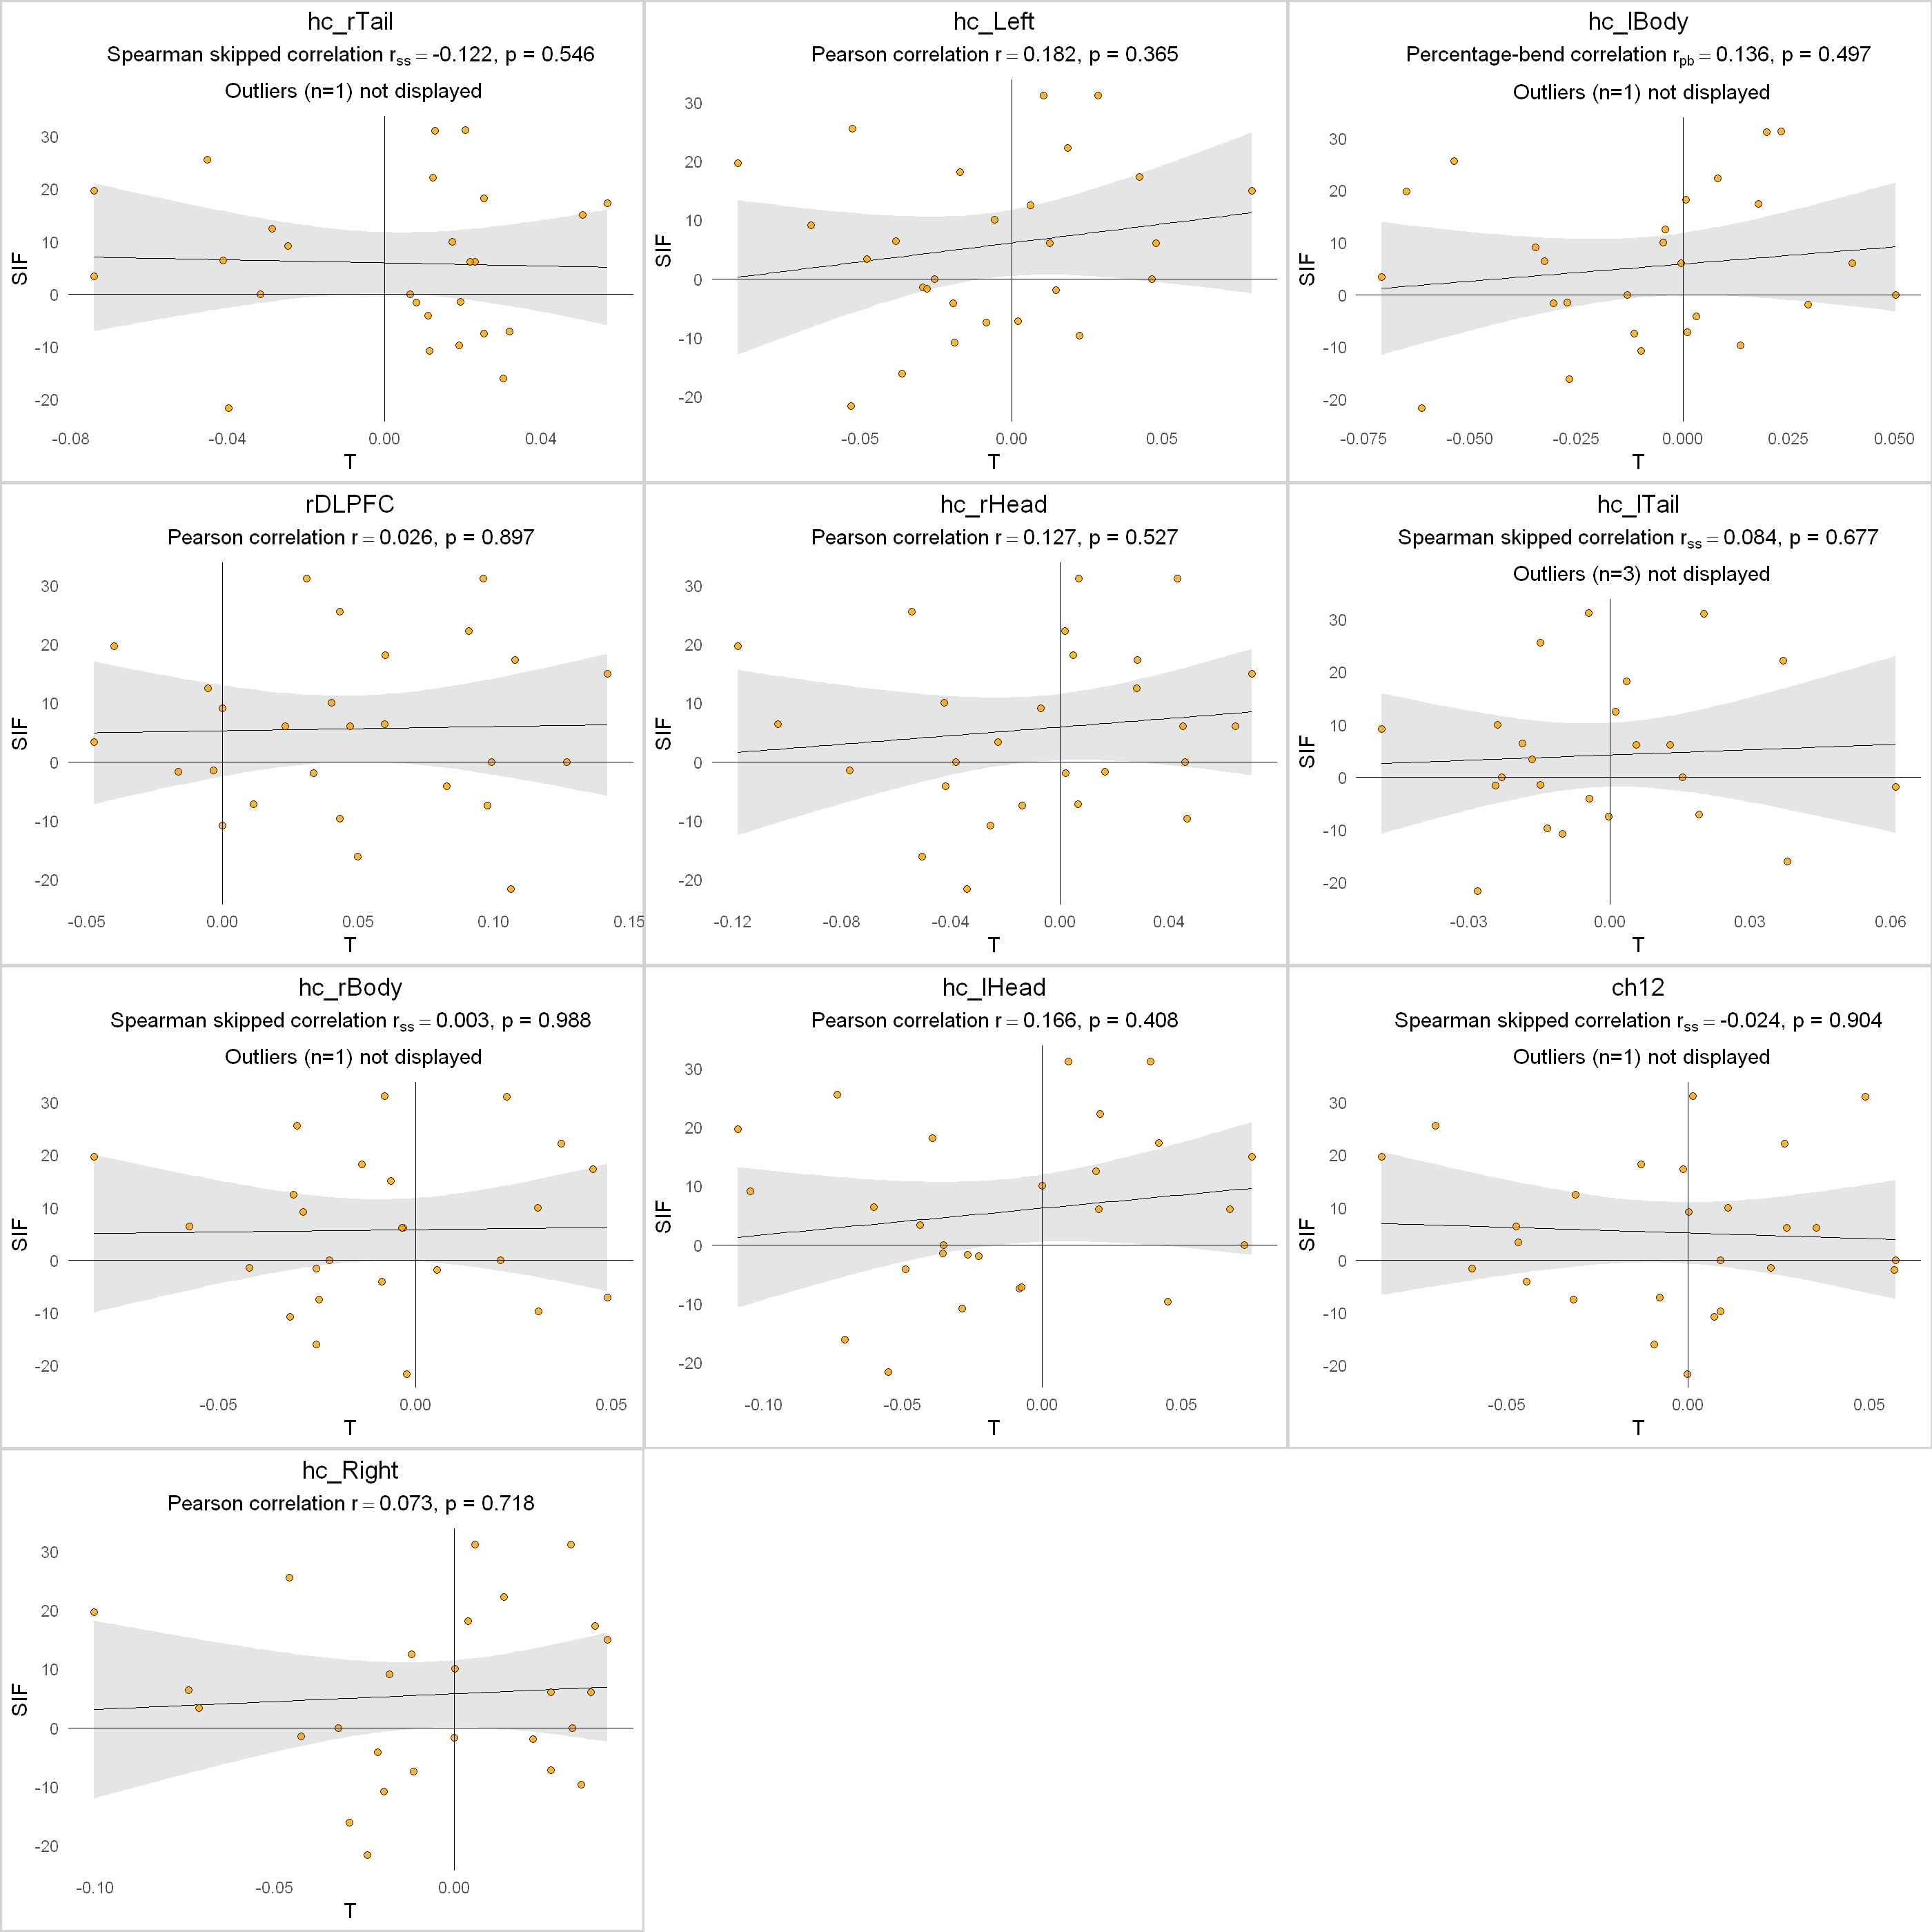

In [57]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "06_RolandNeuron"

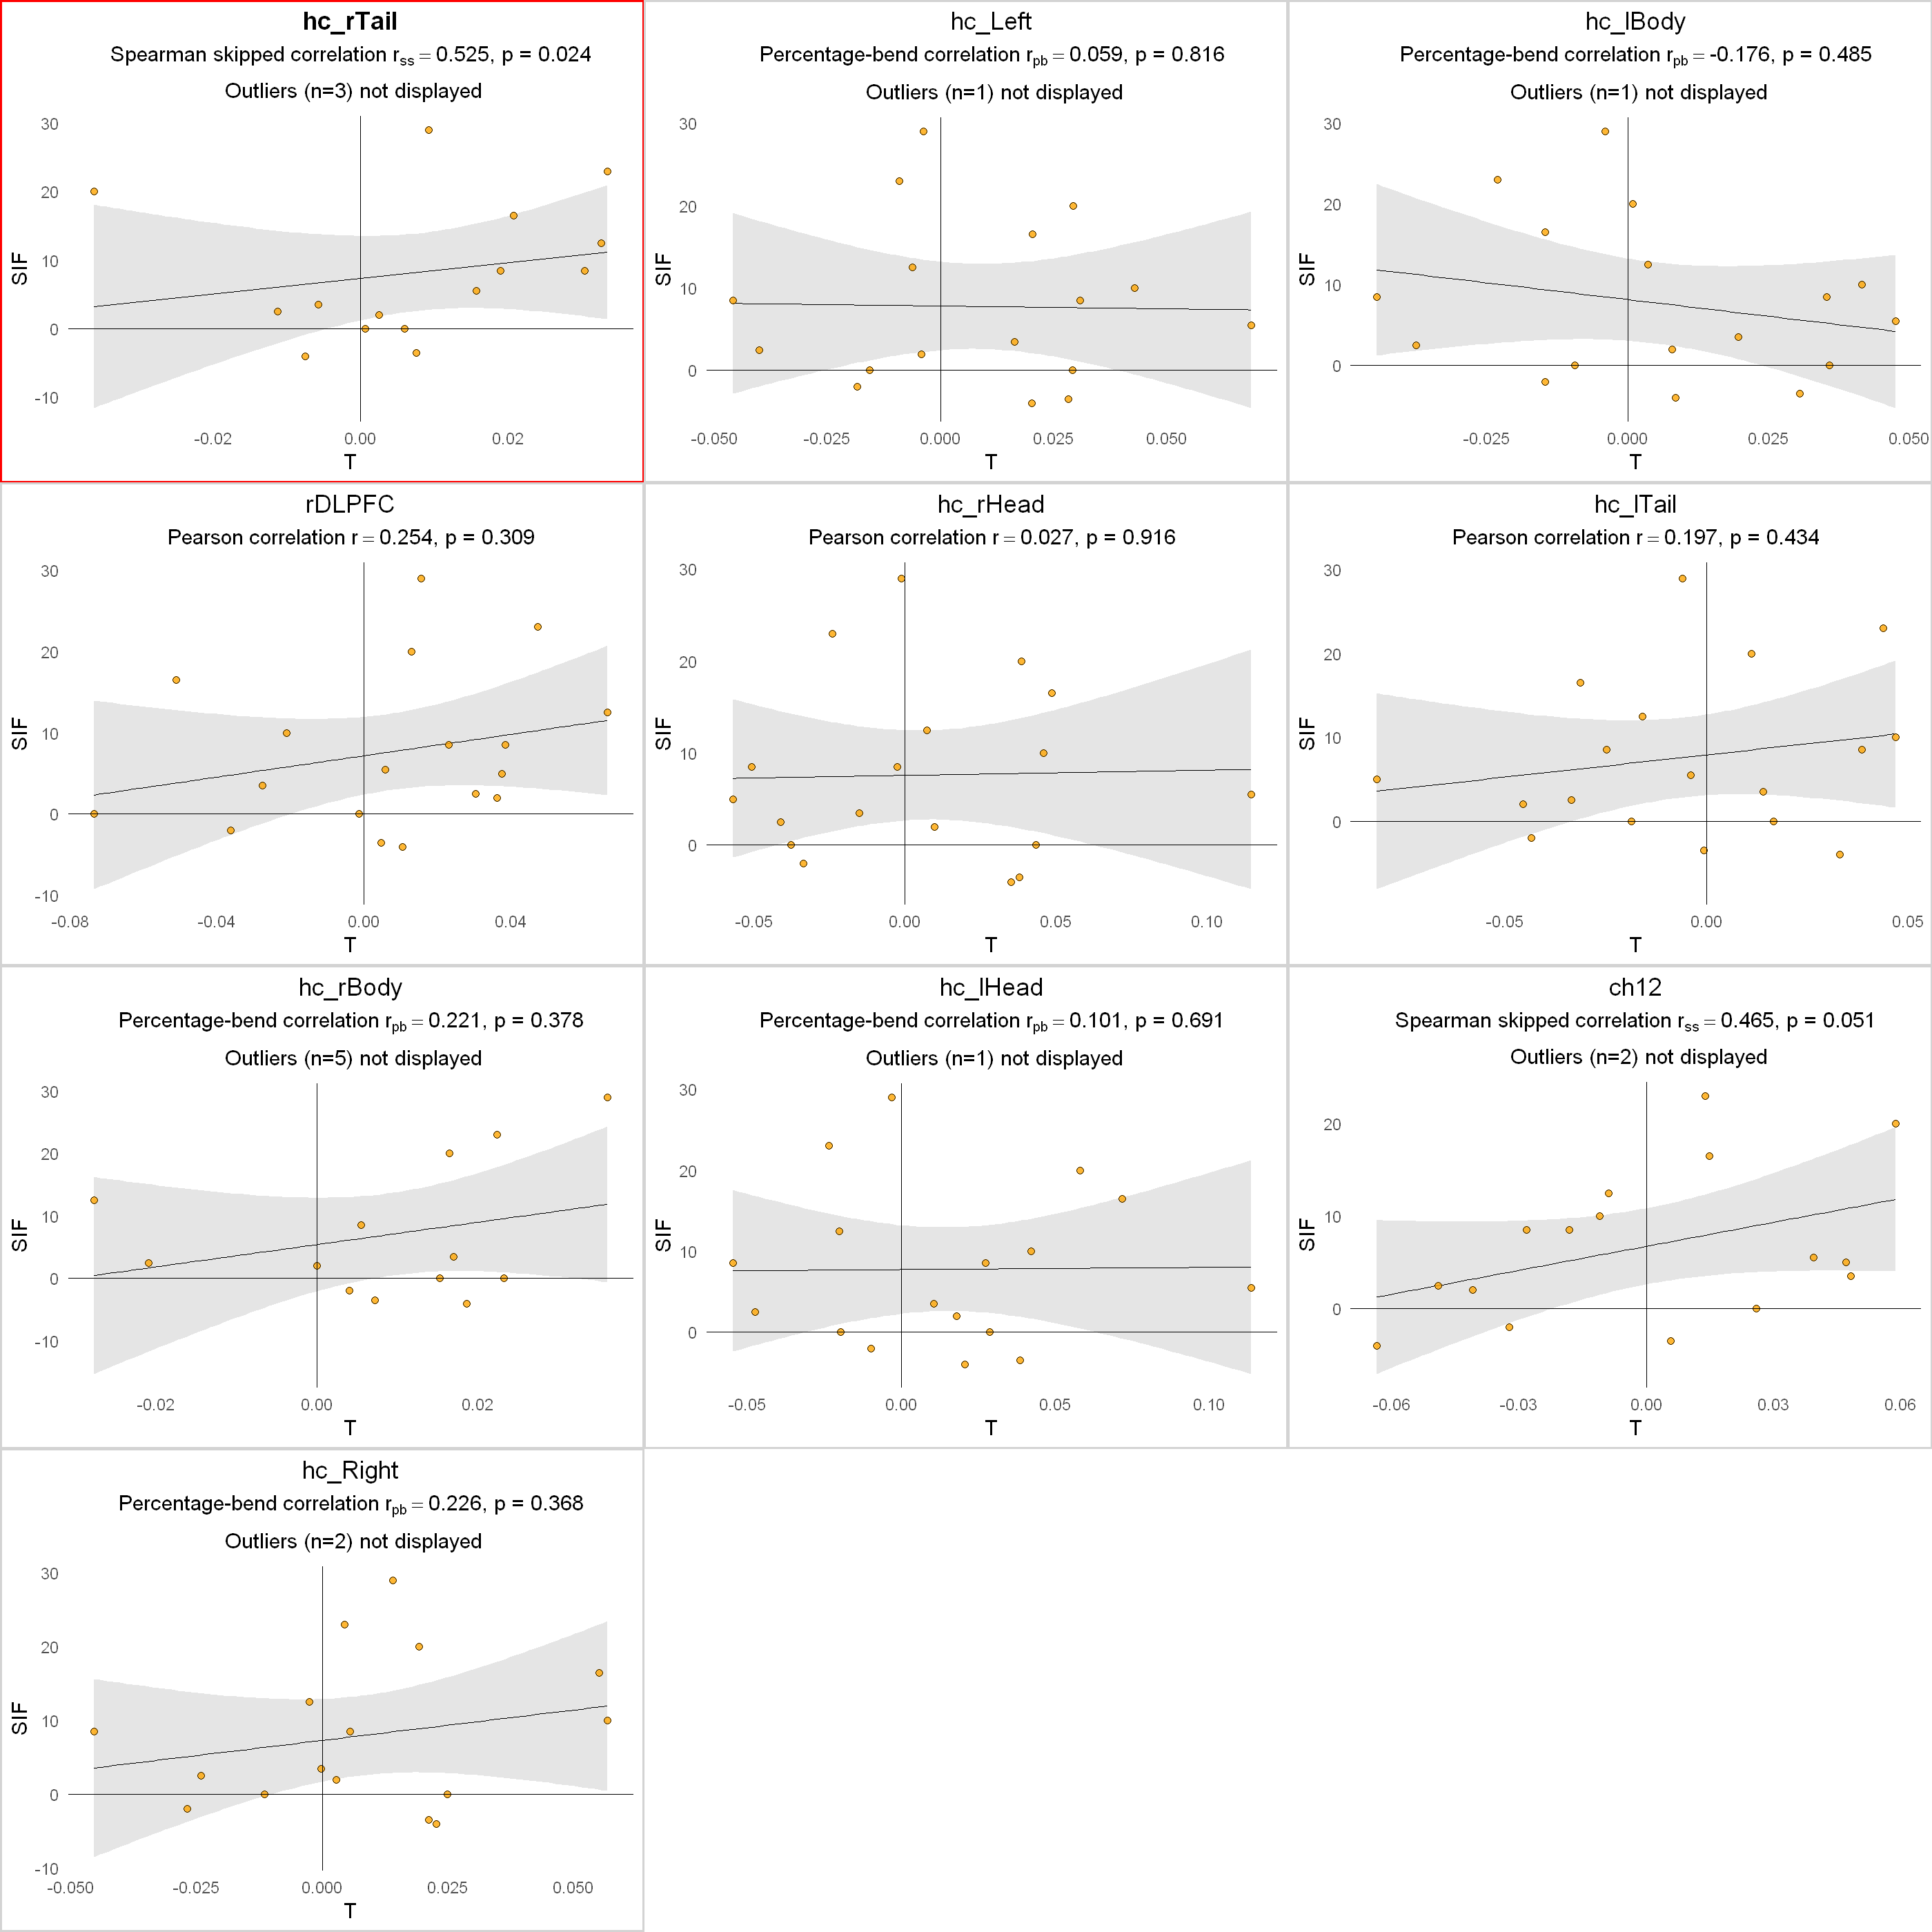

In [58]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "08_Taylor"

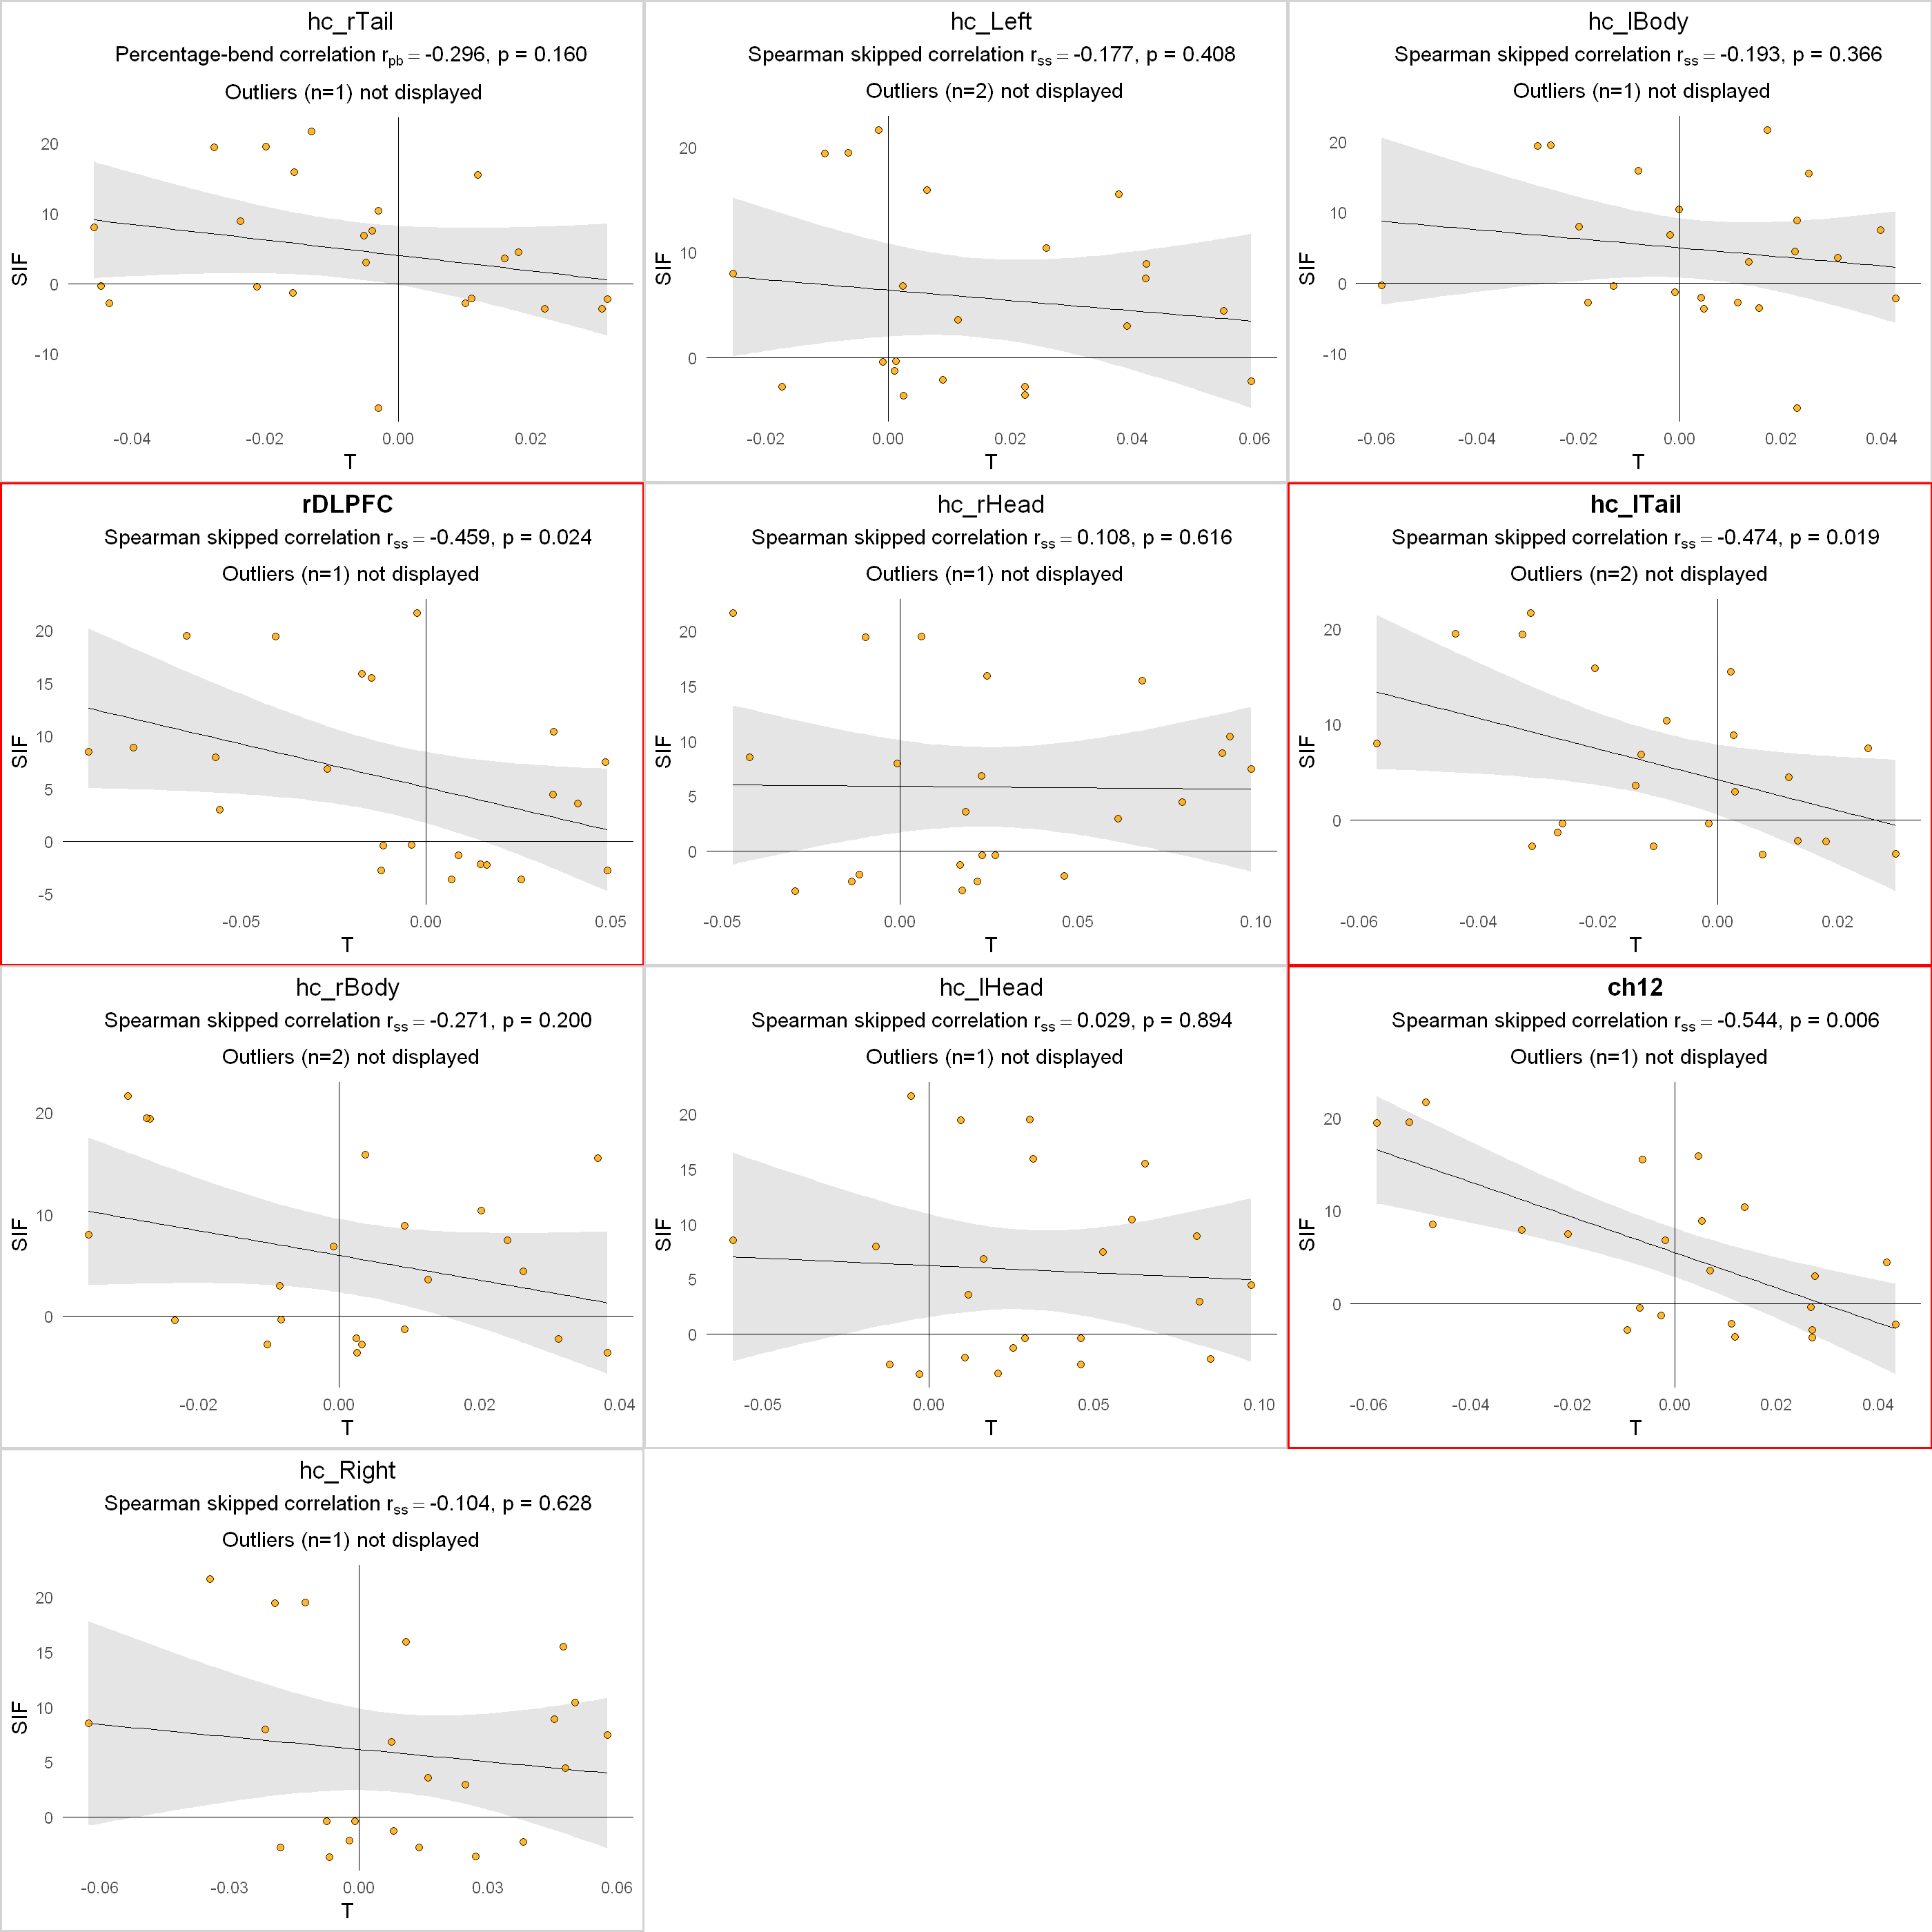

In [59]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "09_Xu"

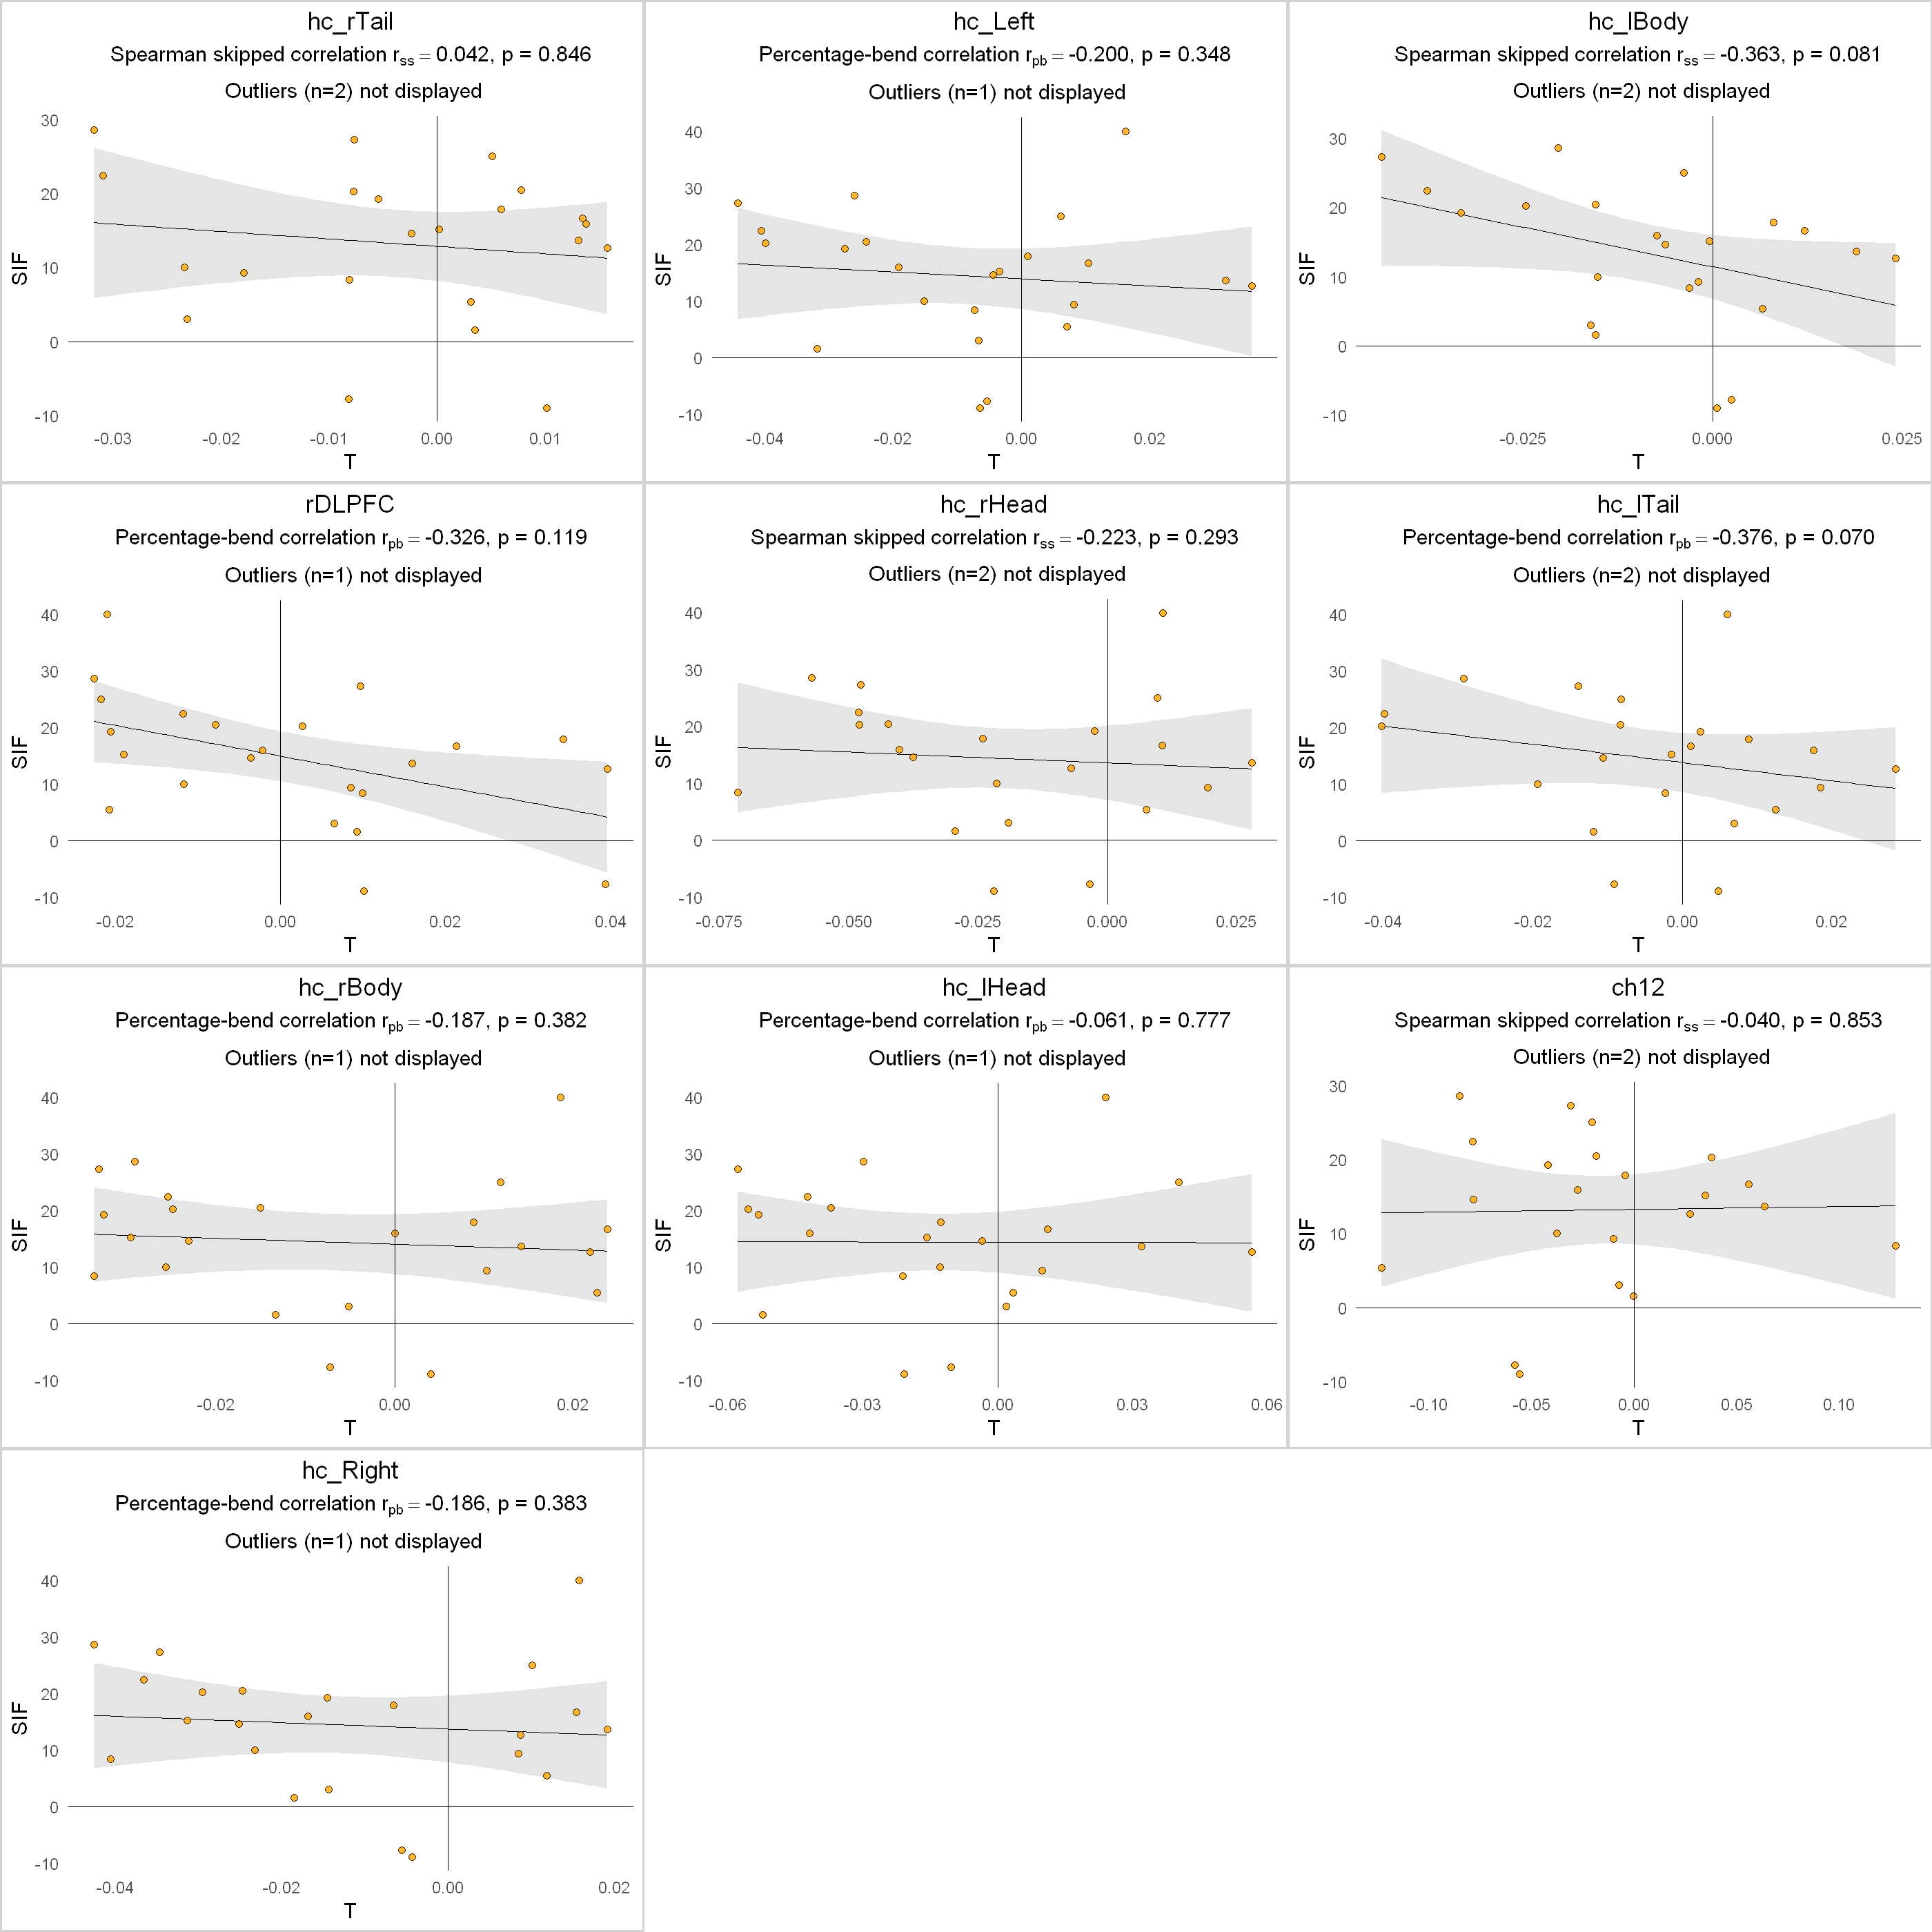

In [60]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "10_Big-TNT"

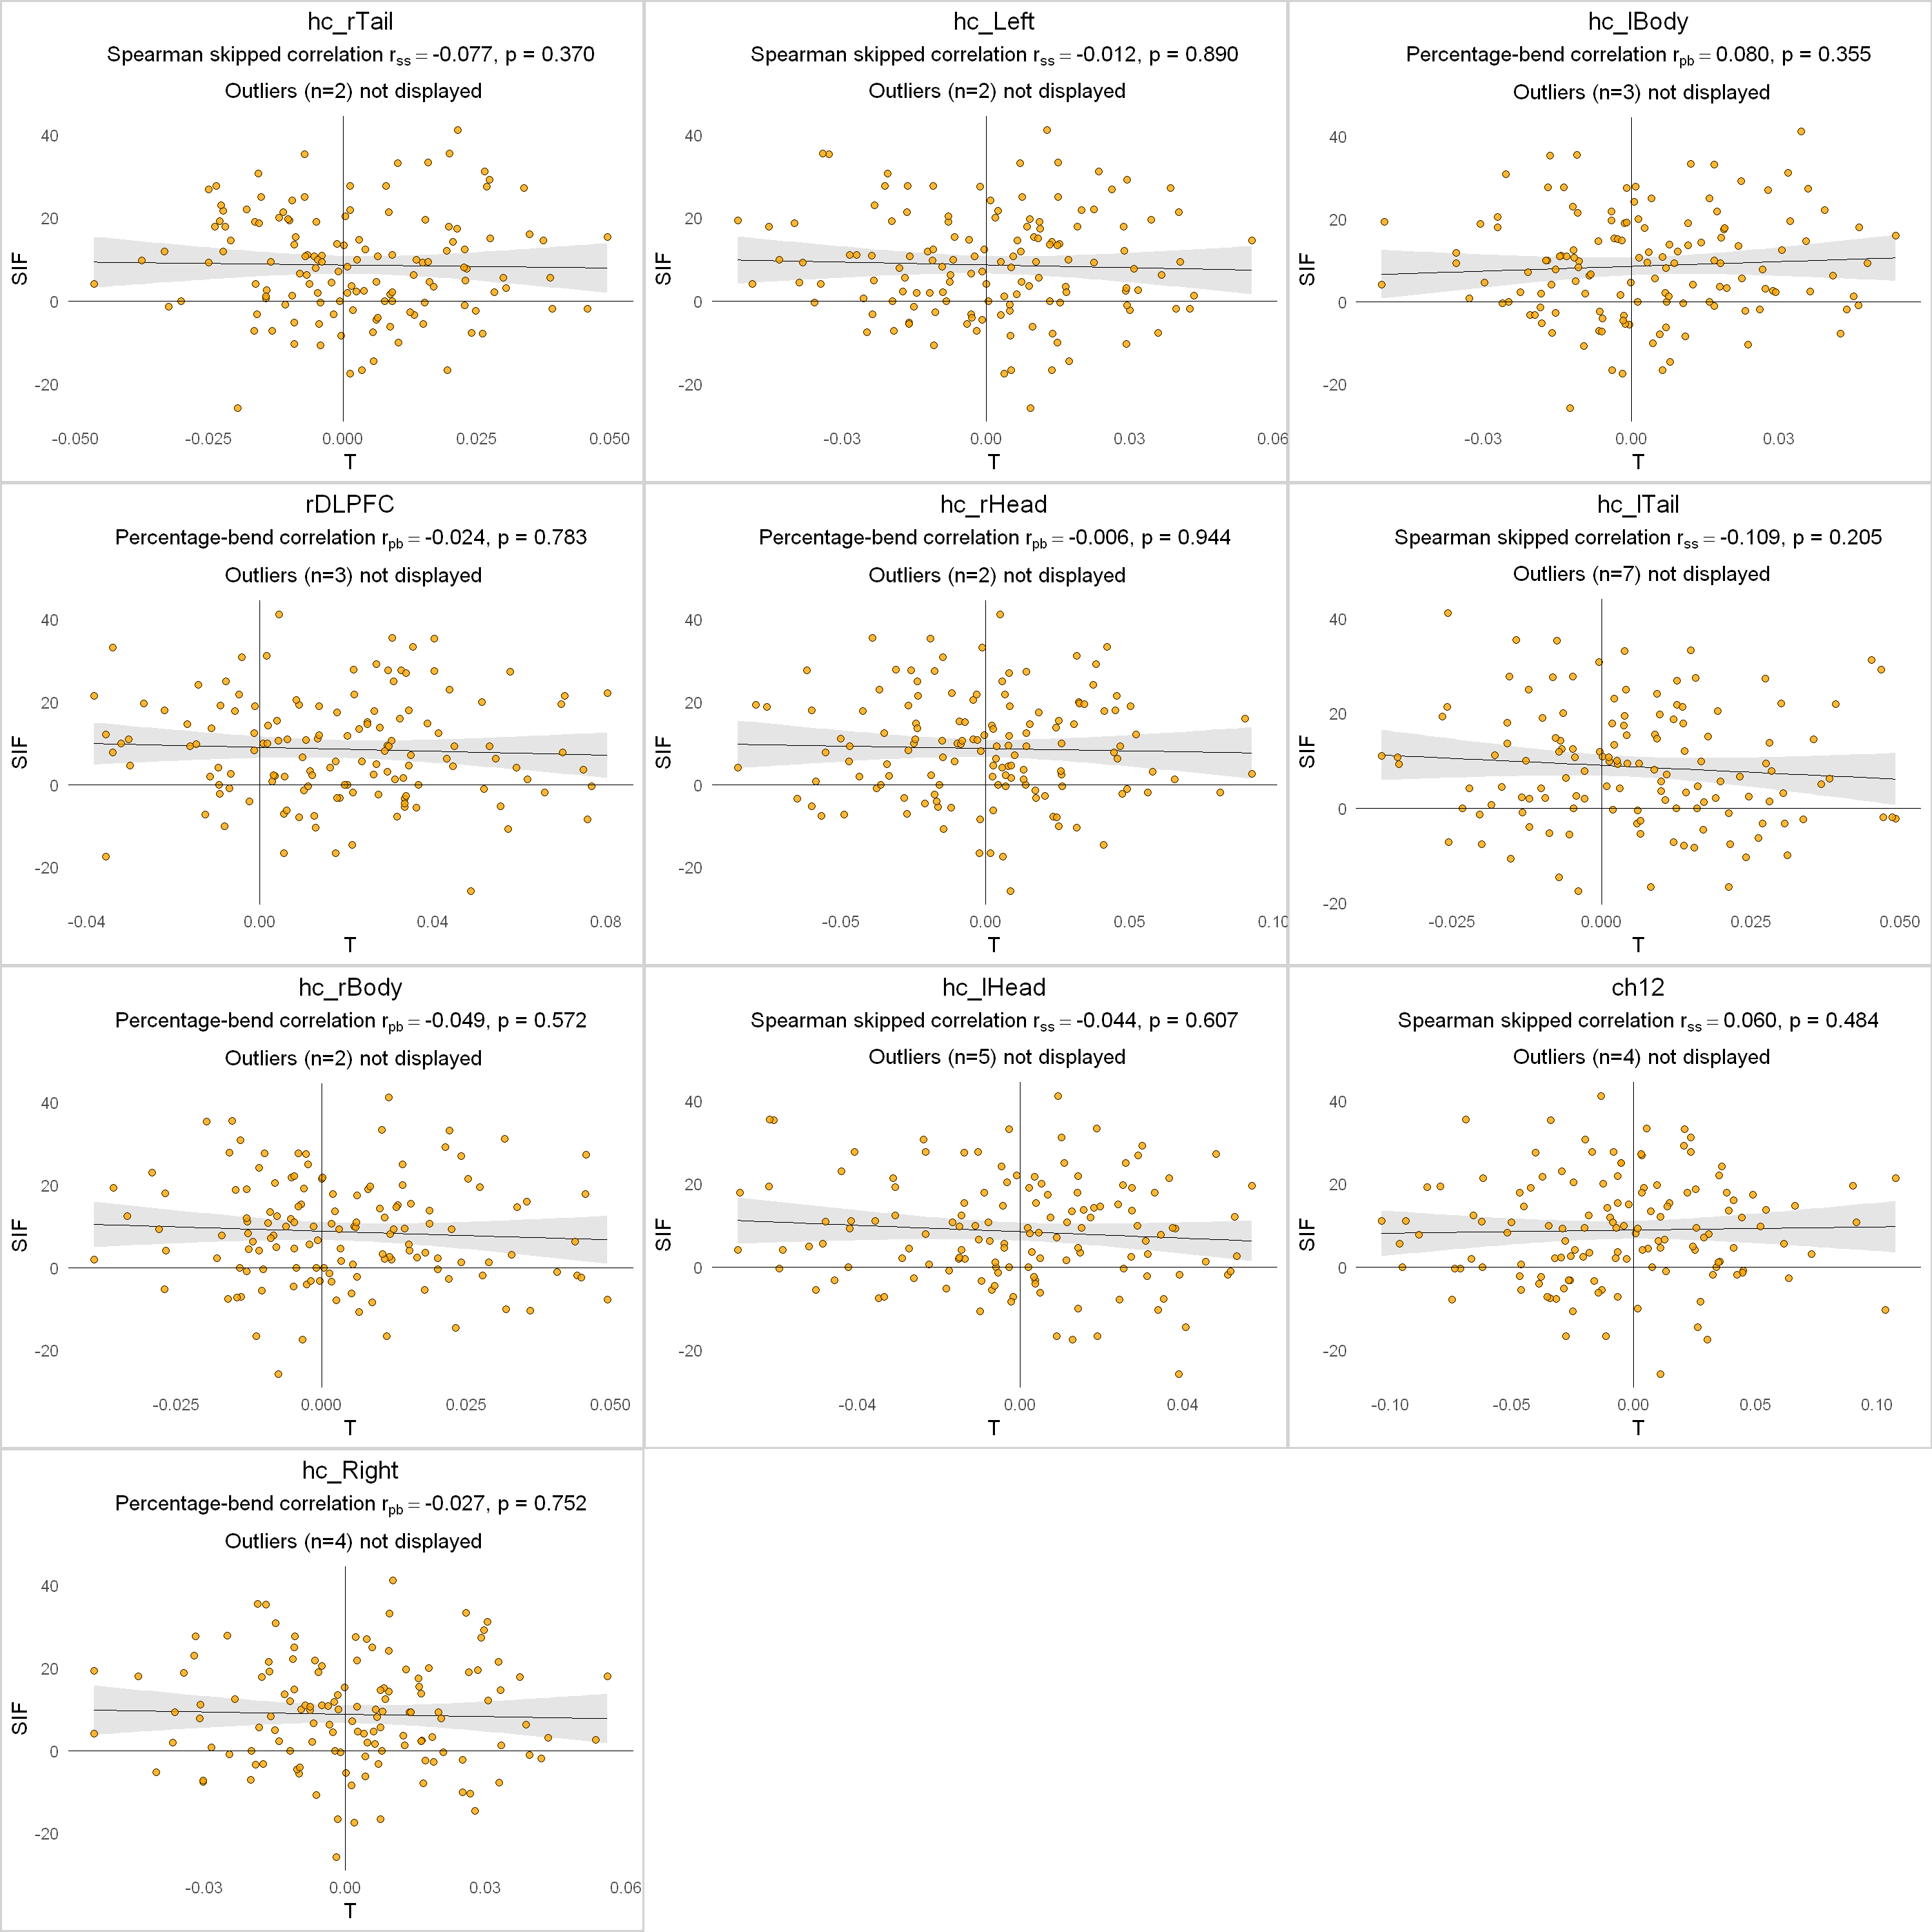

In [61]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

## Think-No-Think

[1] "01_Levy1"

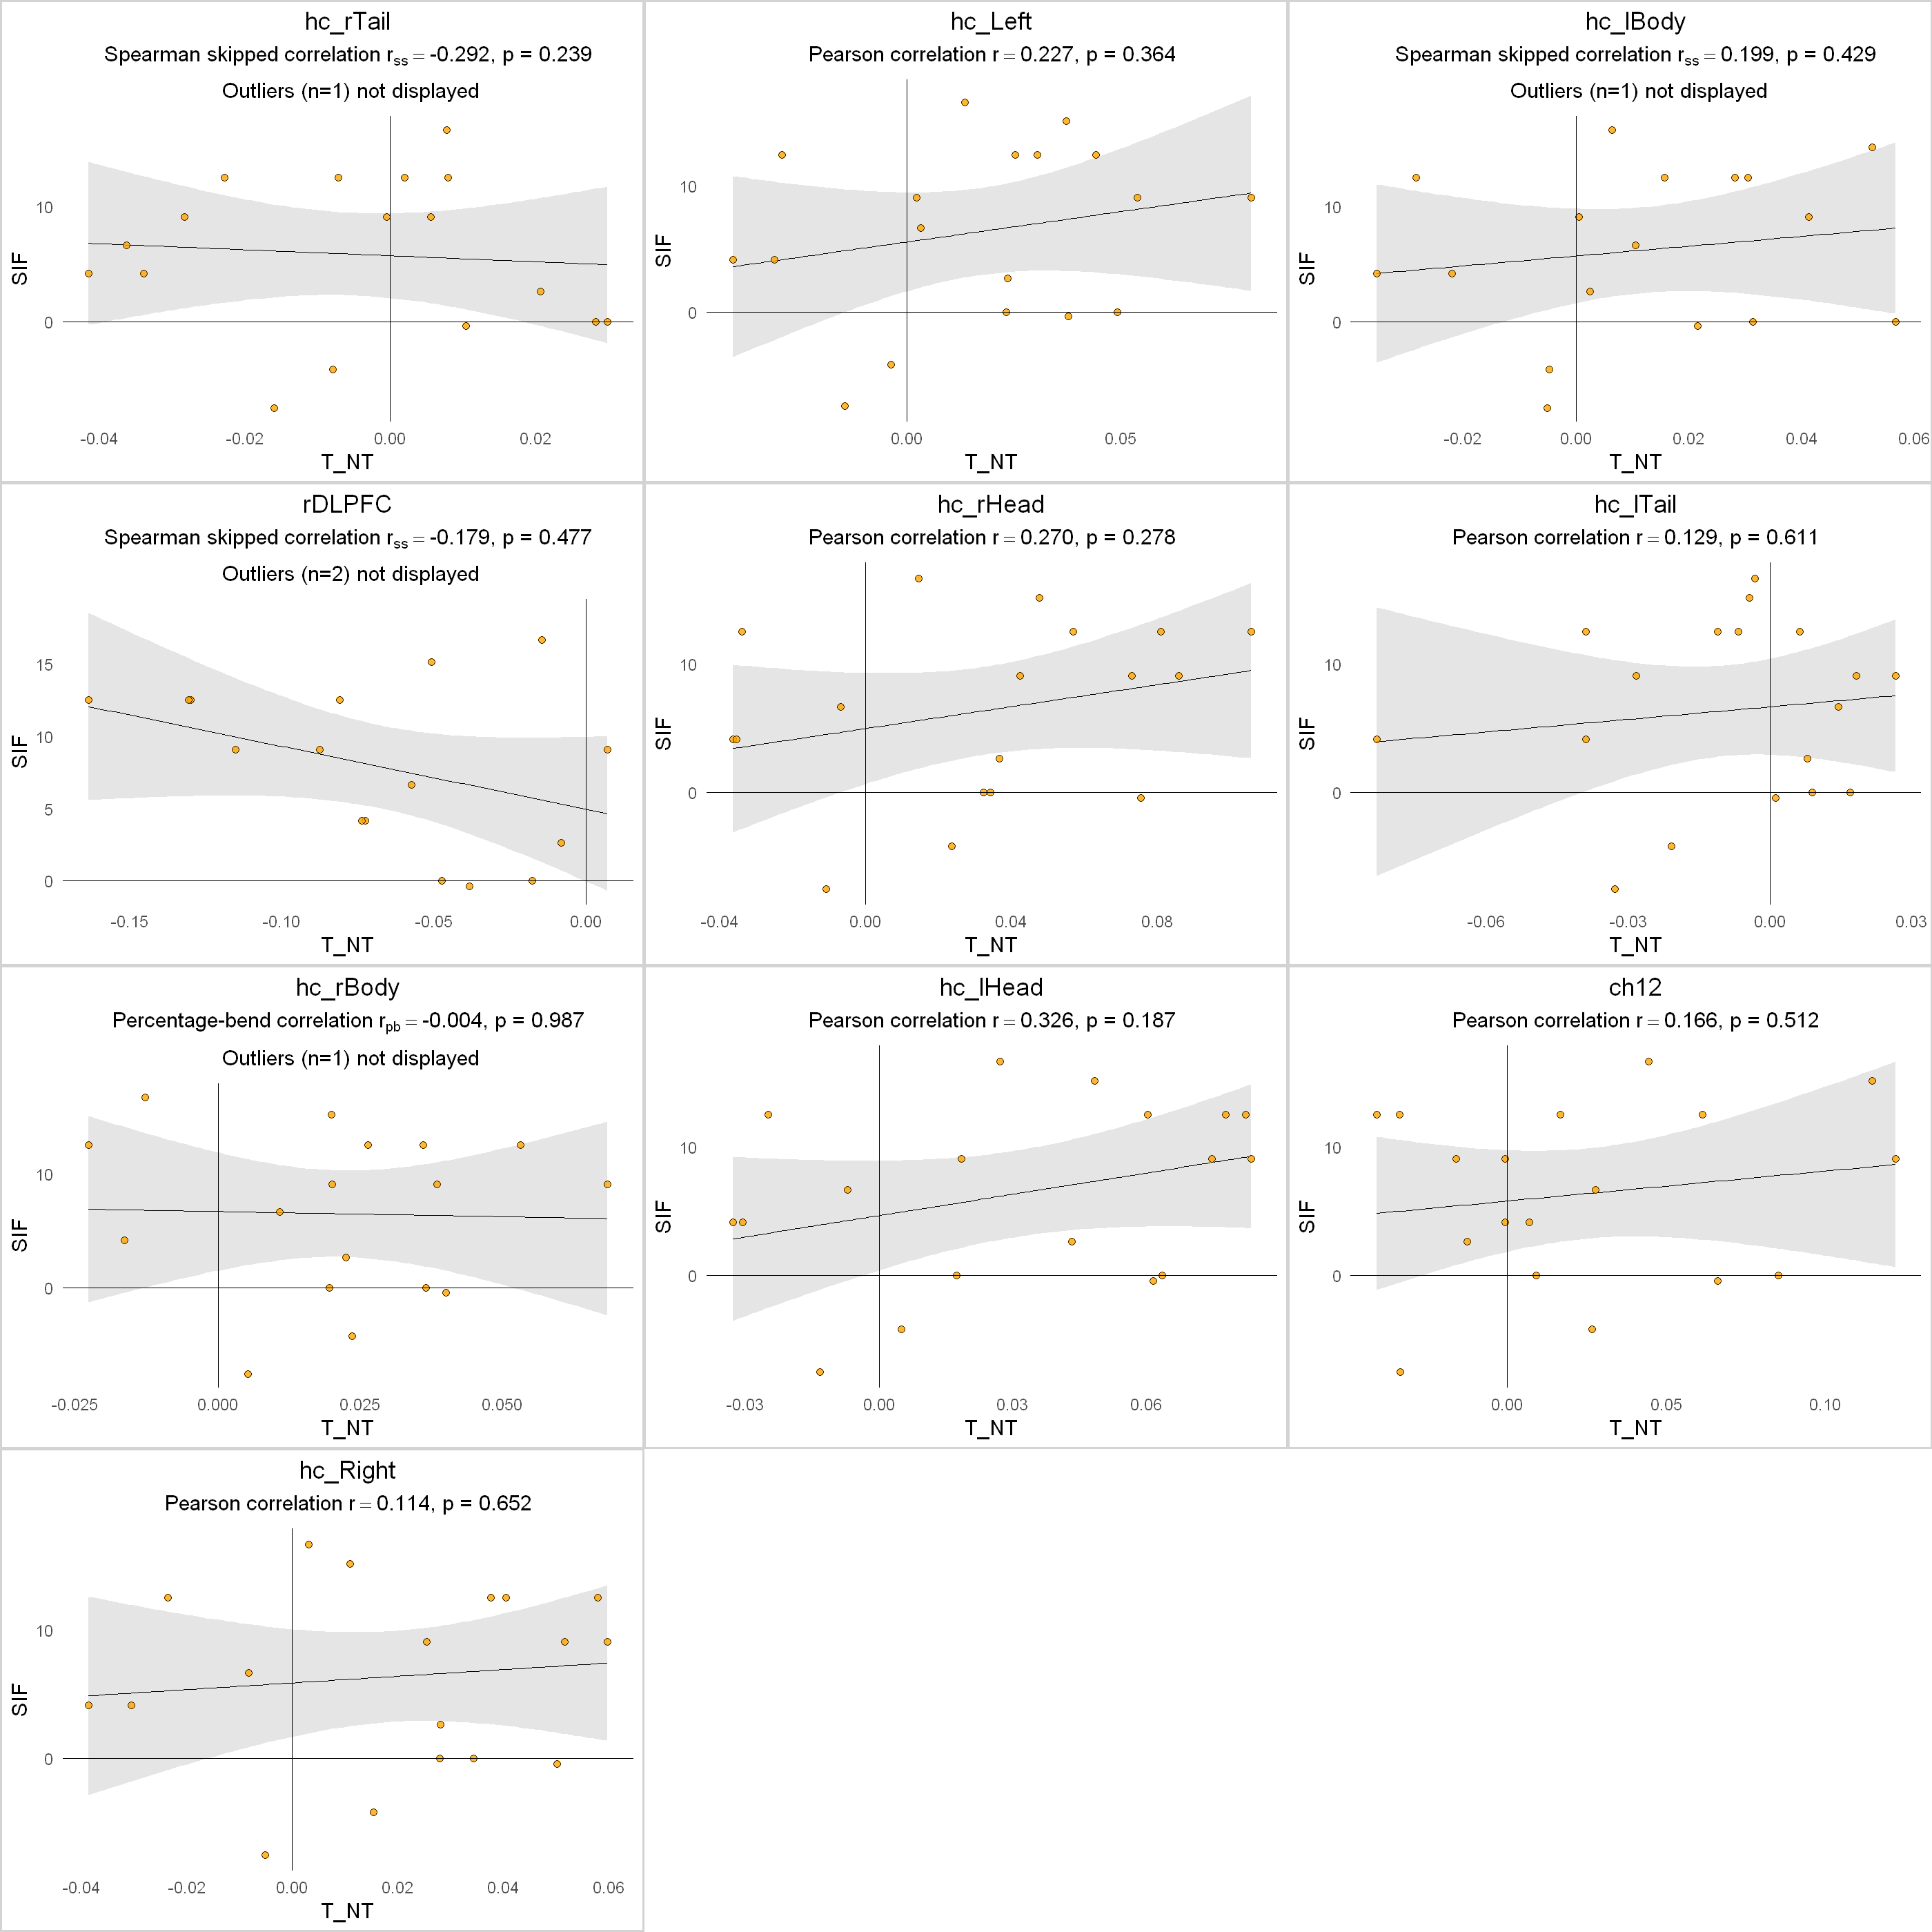

In [62]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "02_Levy2"

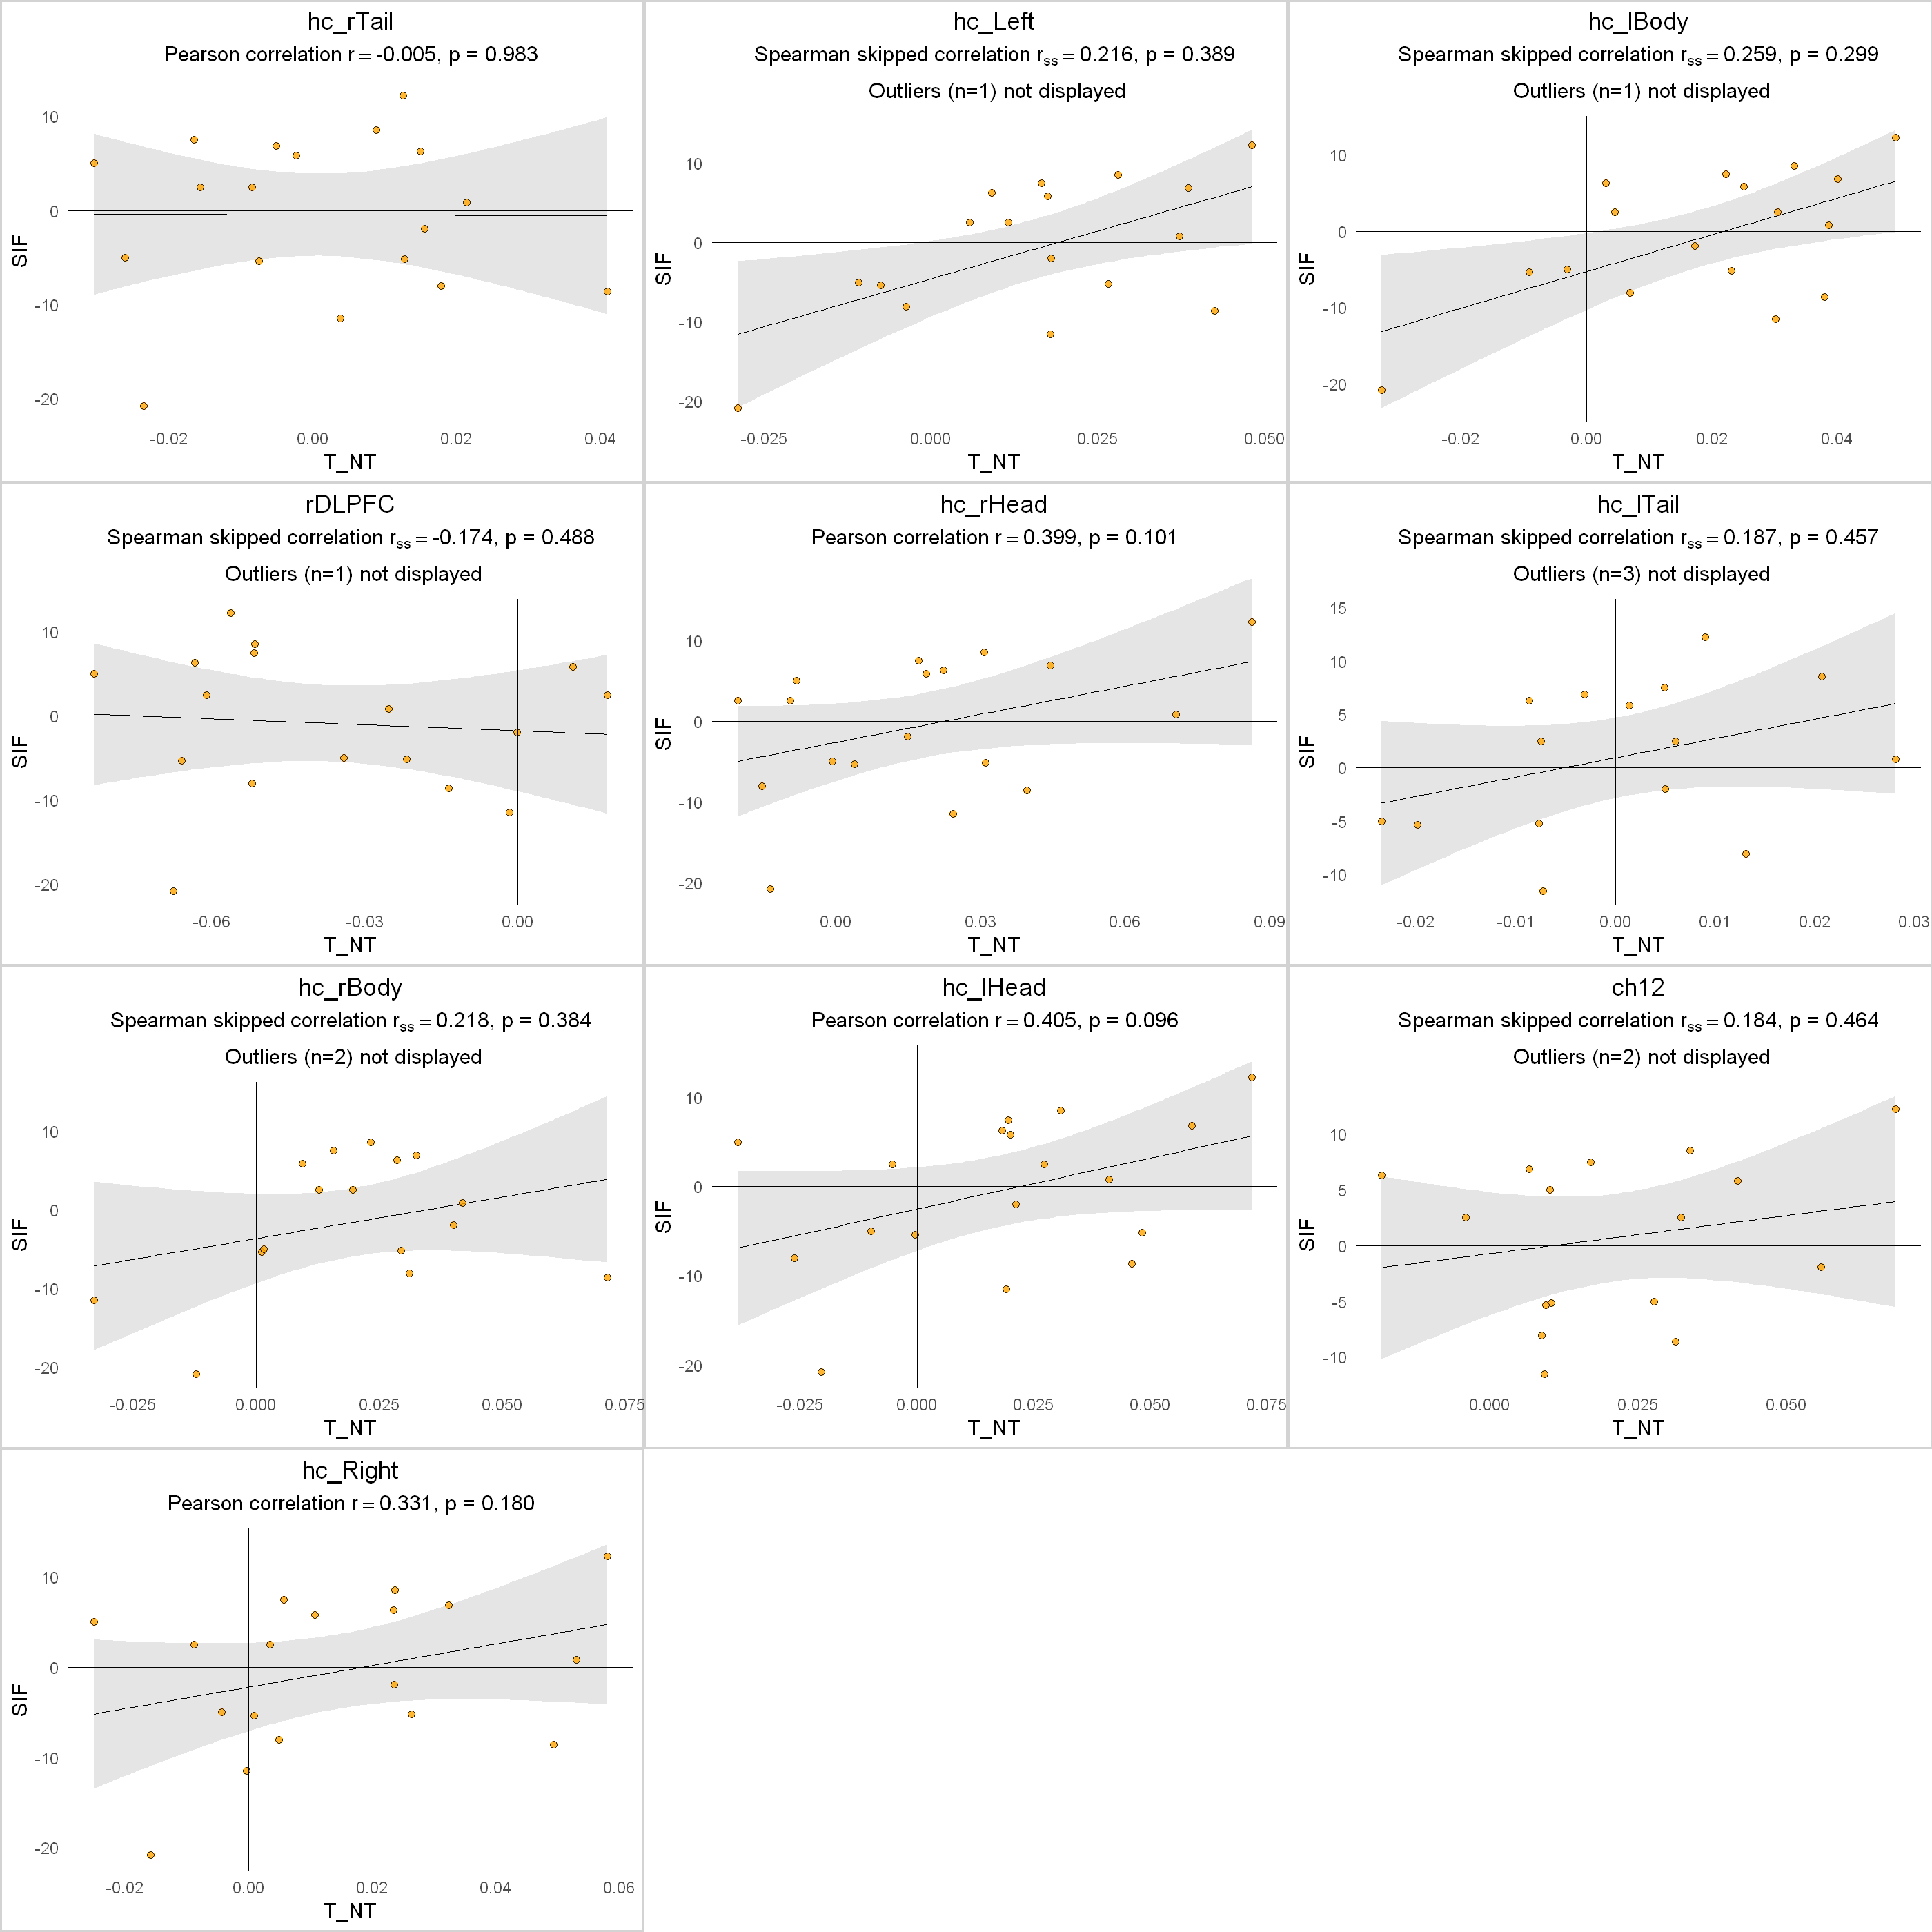

In [63]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "05_Yuhua"

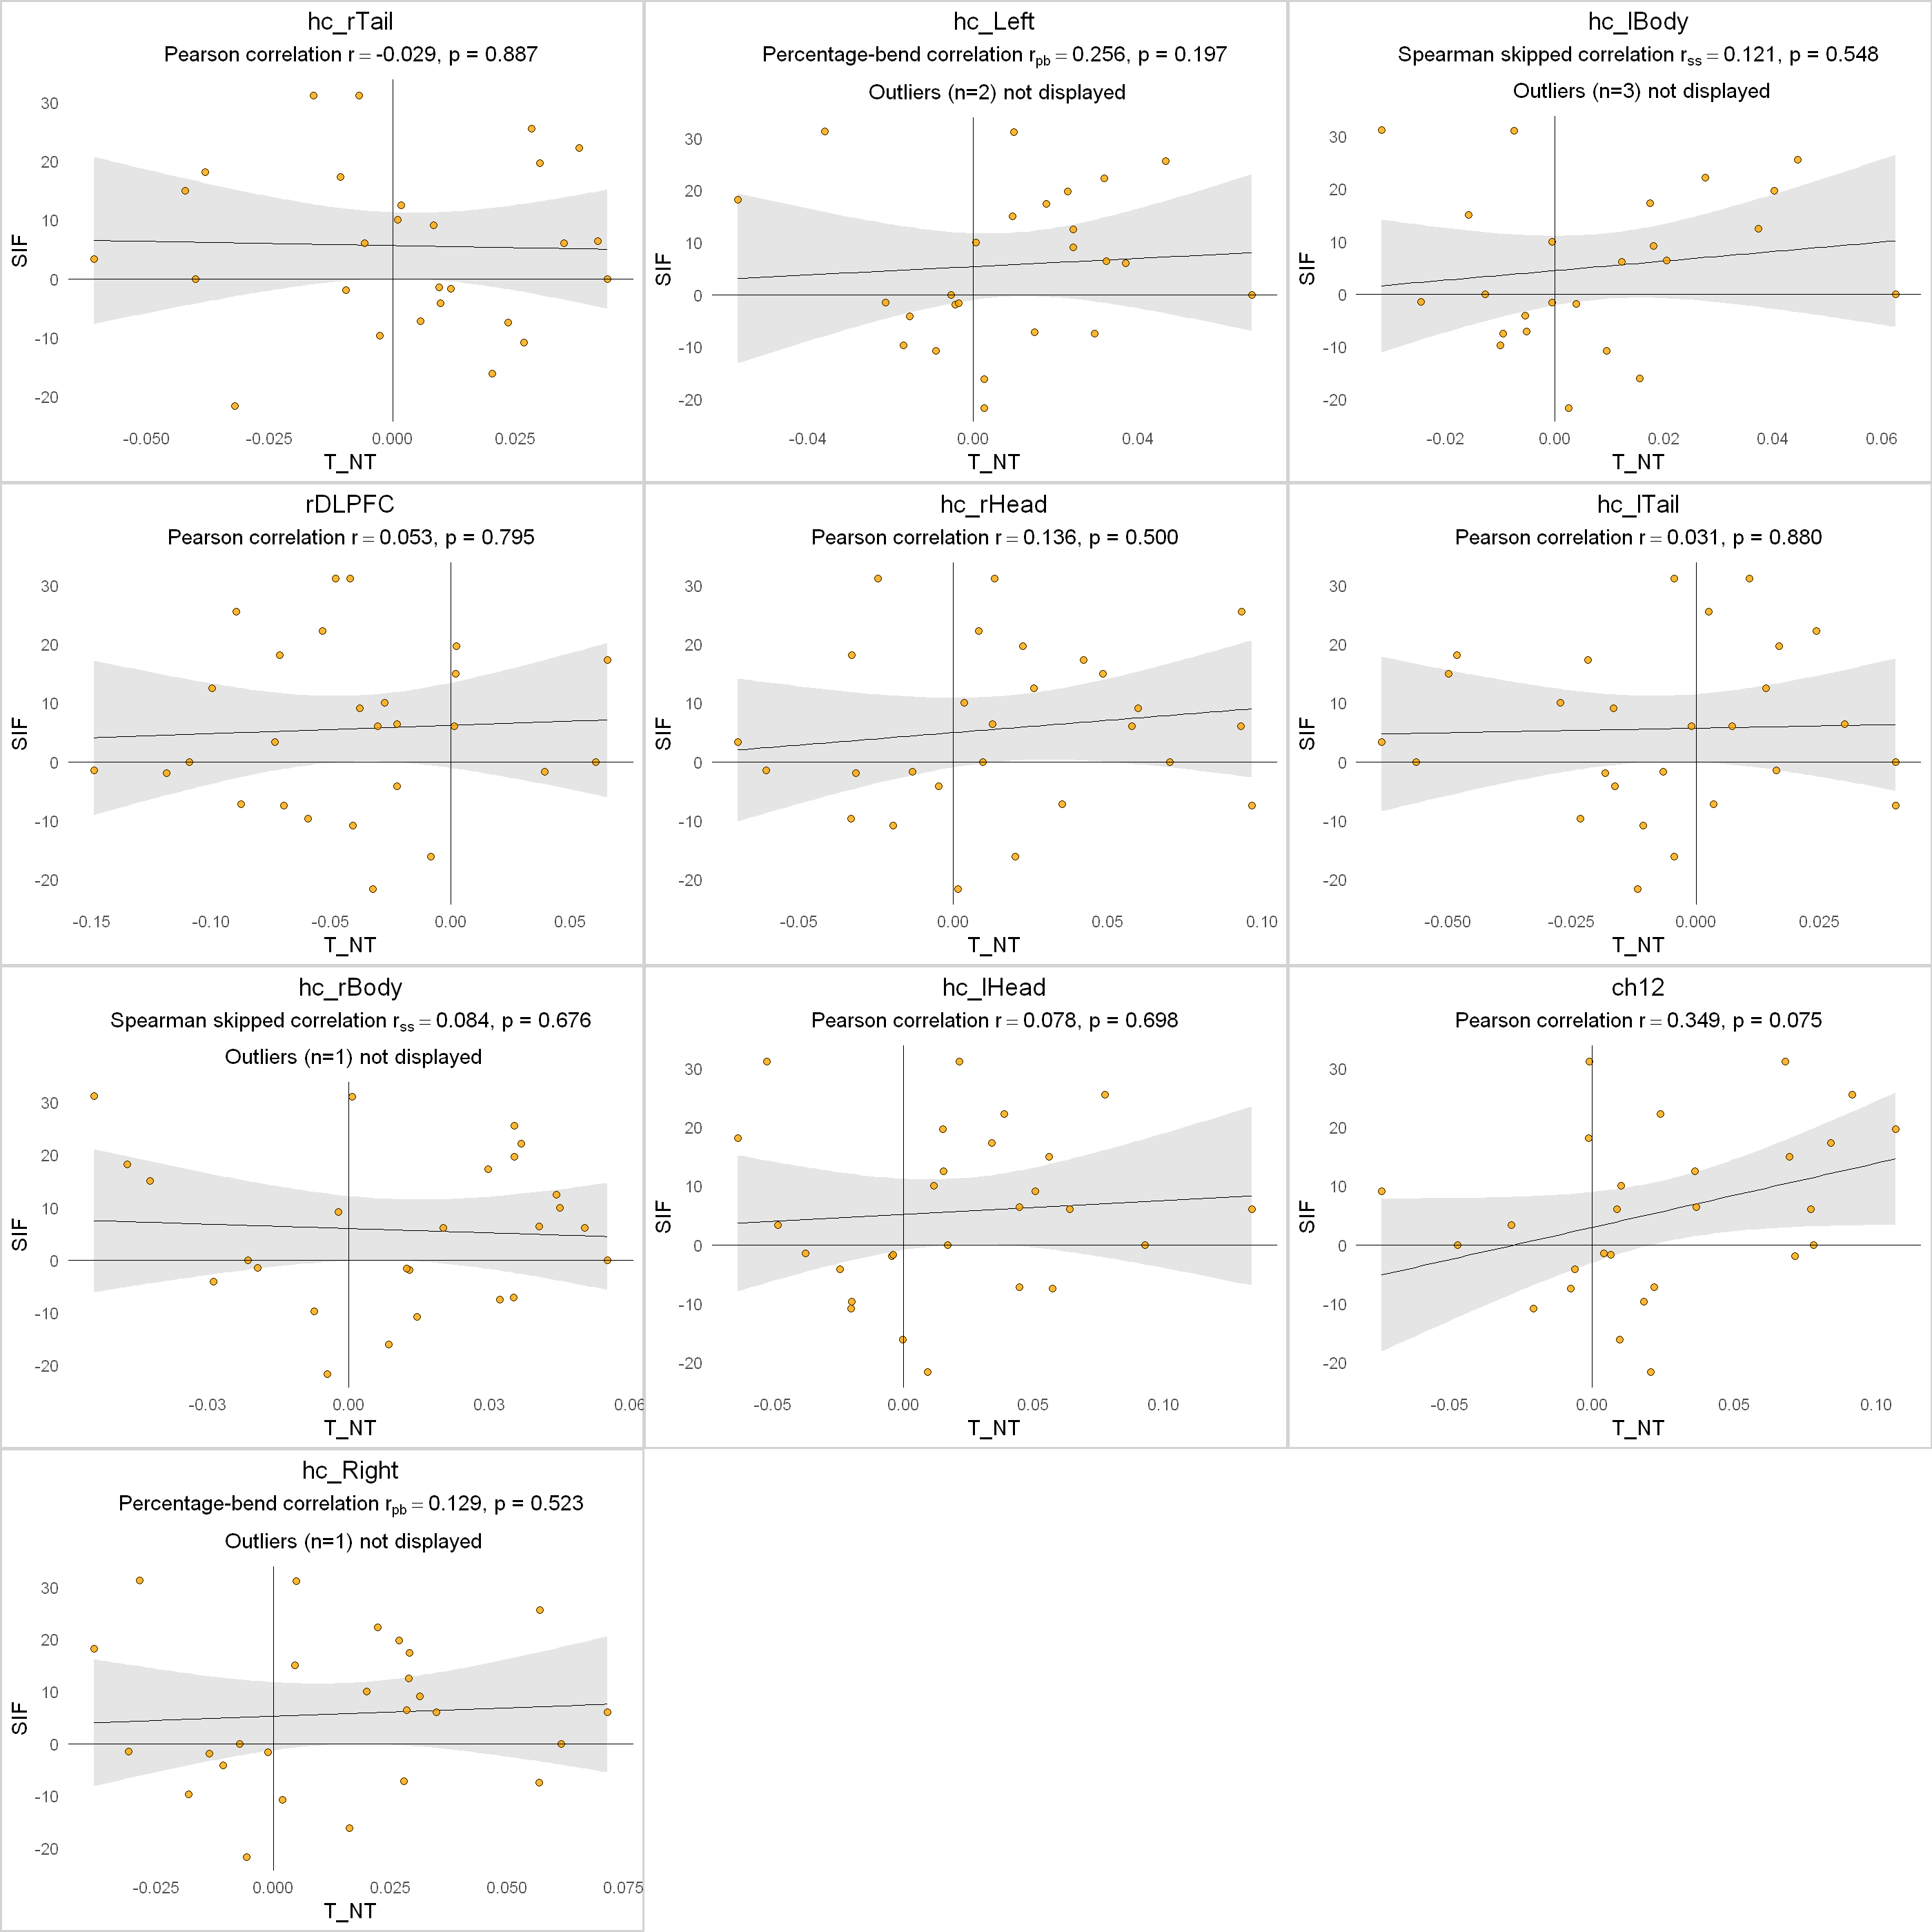

In [64]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "06_RolandNeuron"

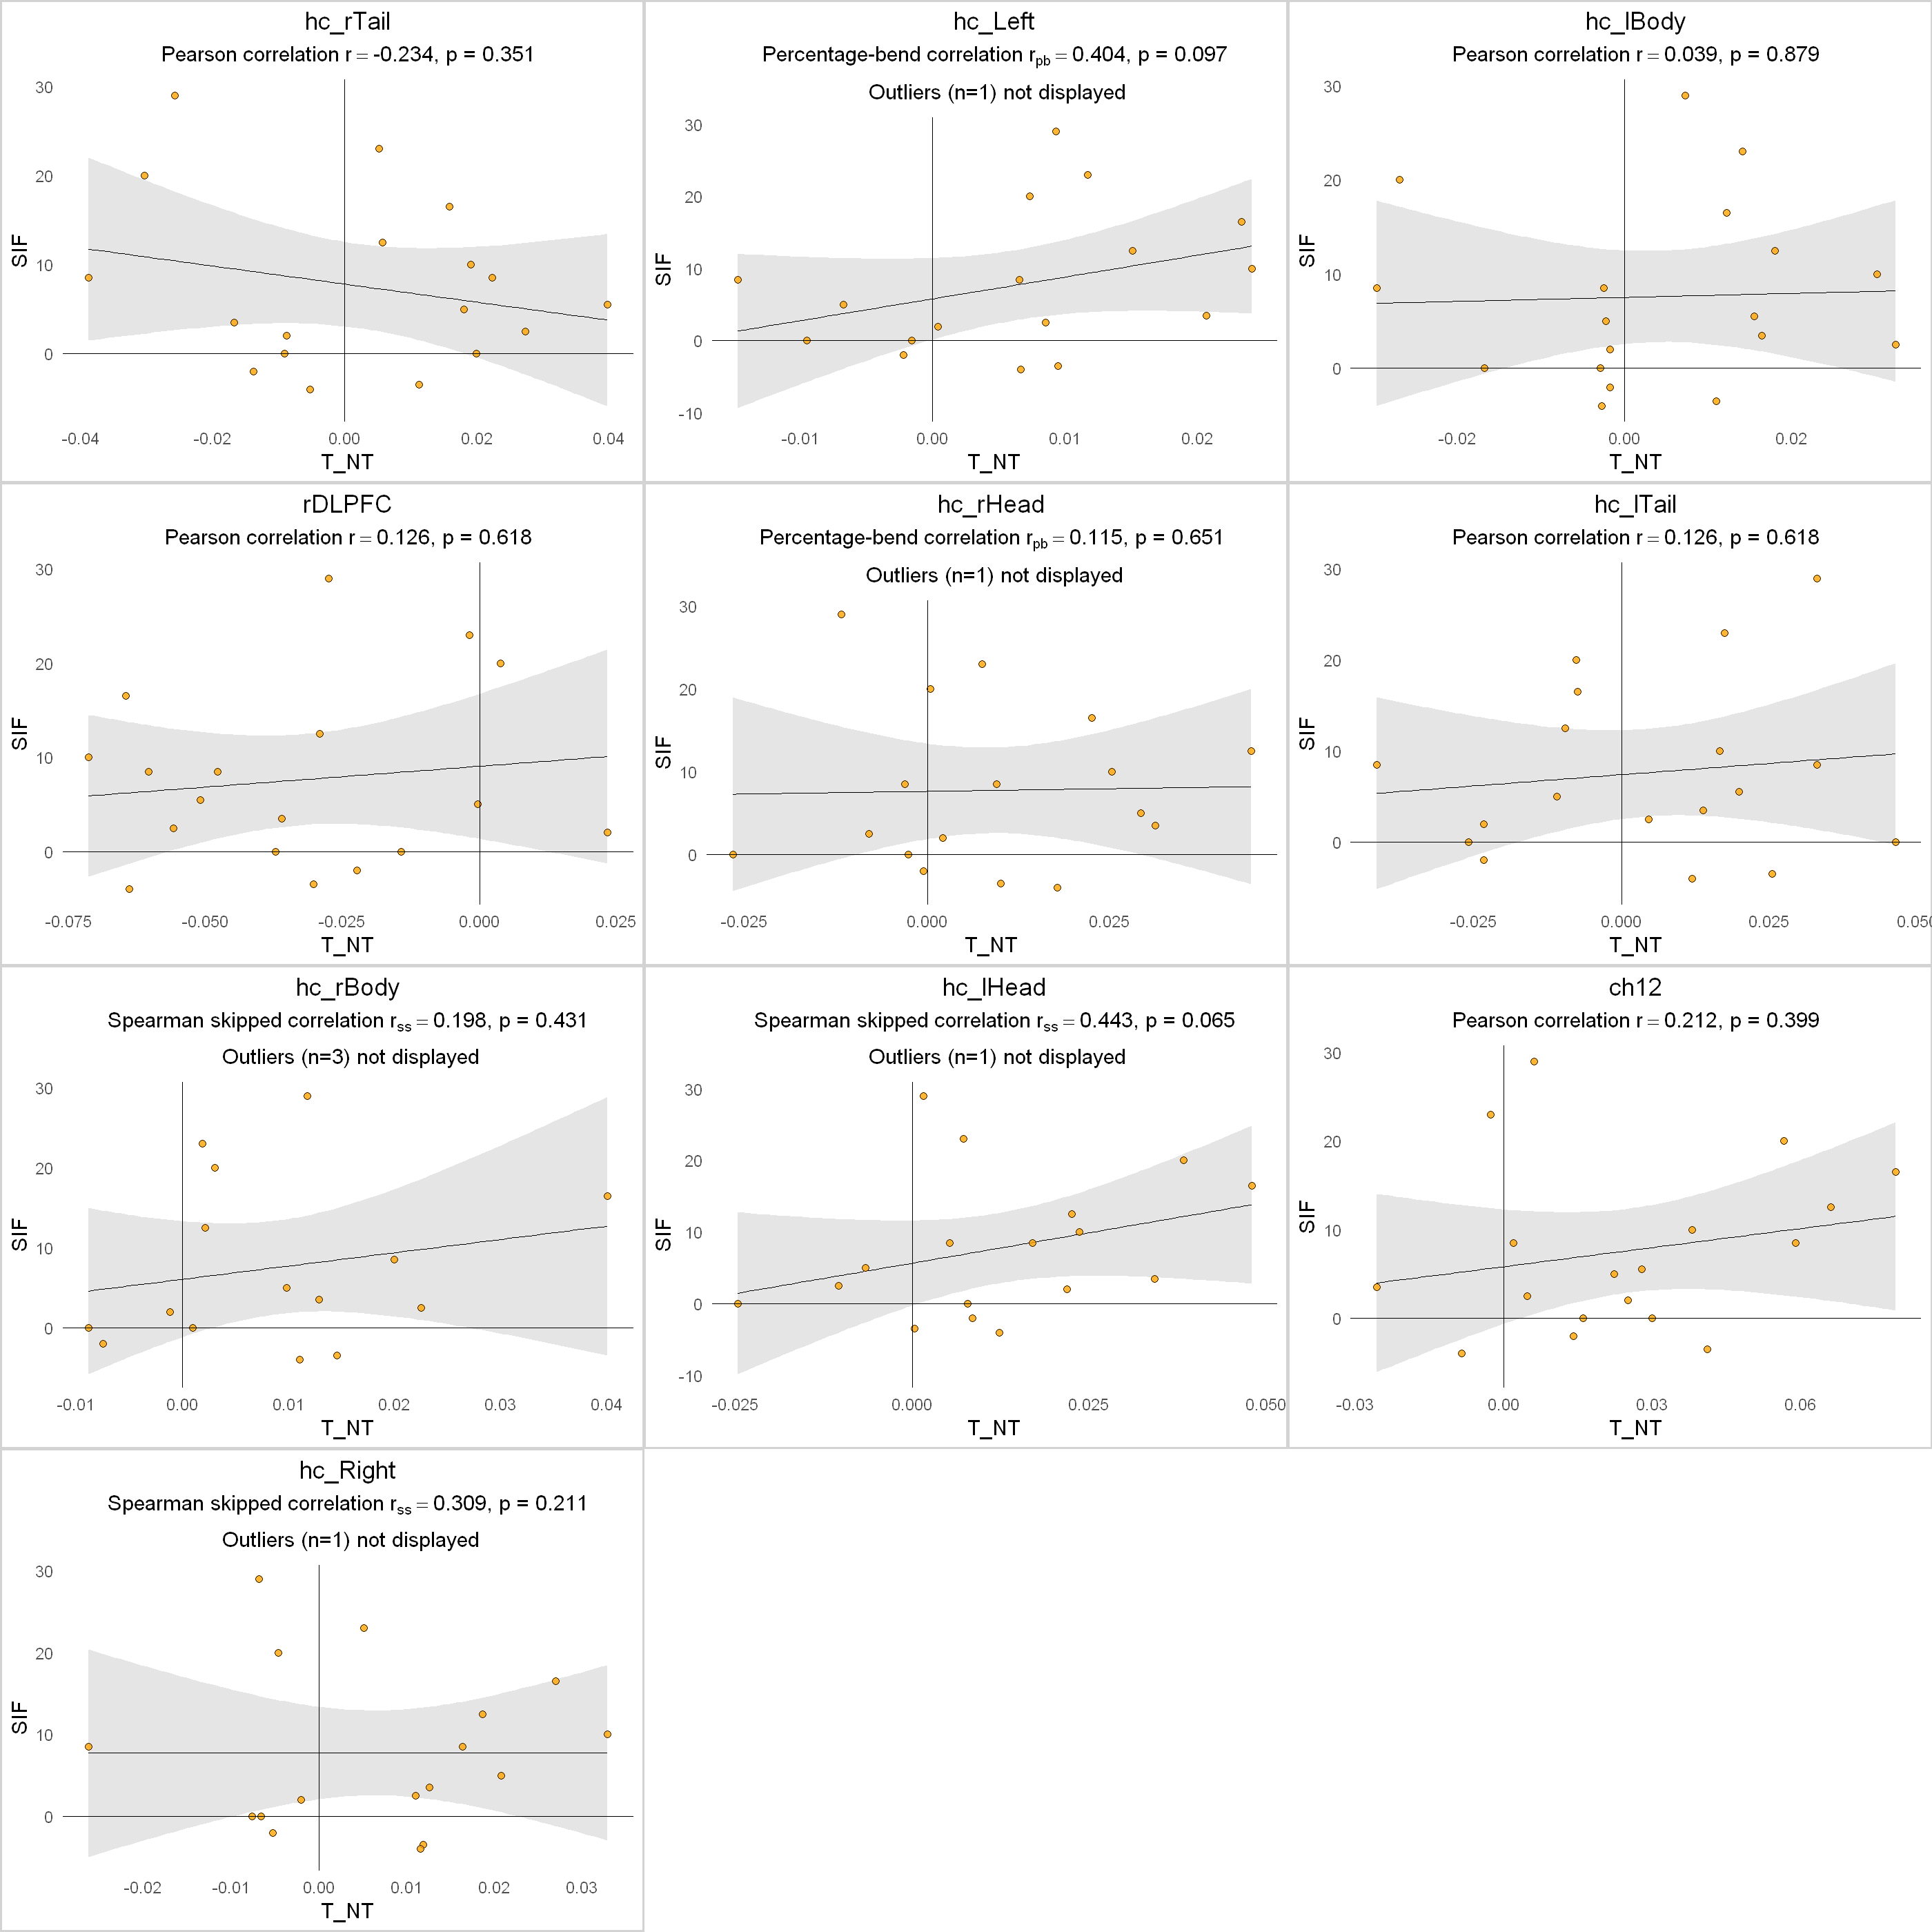

In [65]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "08_Taylor"

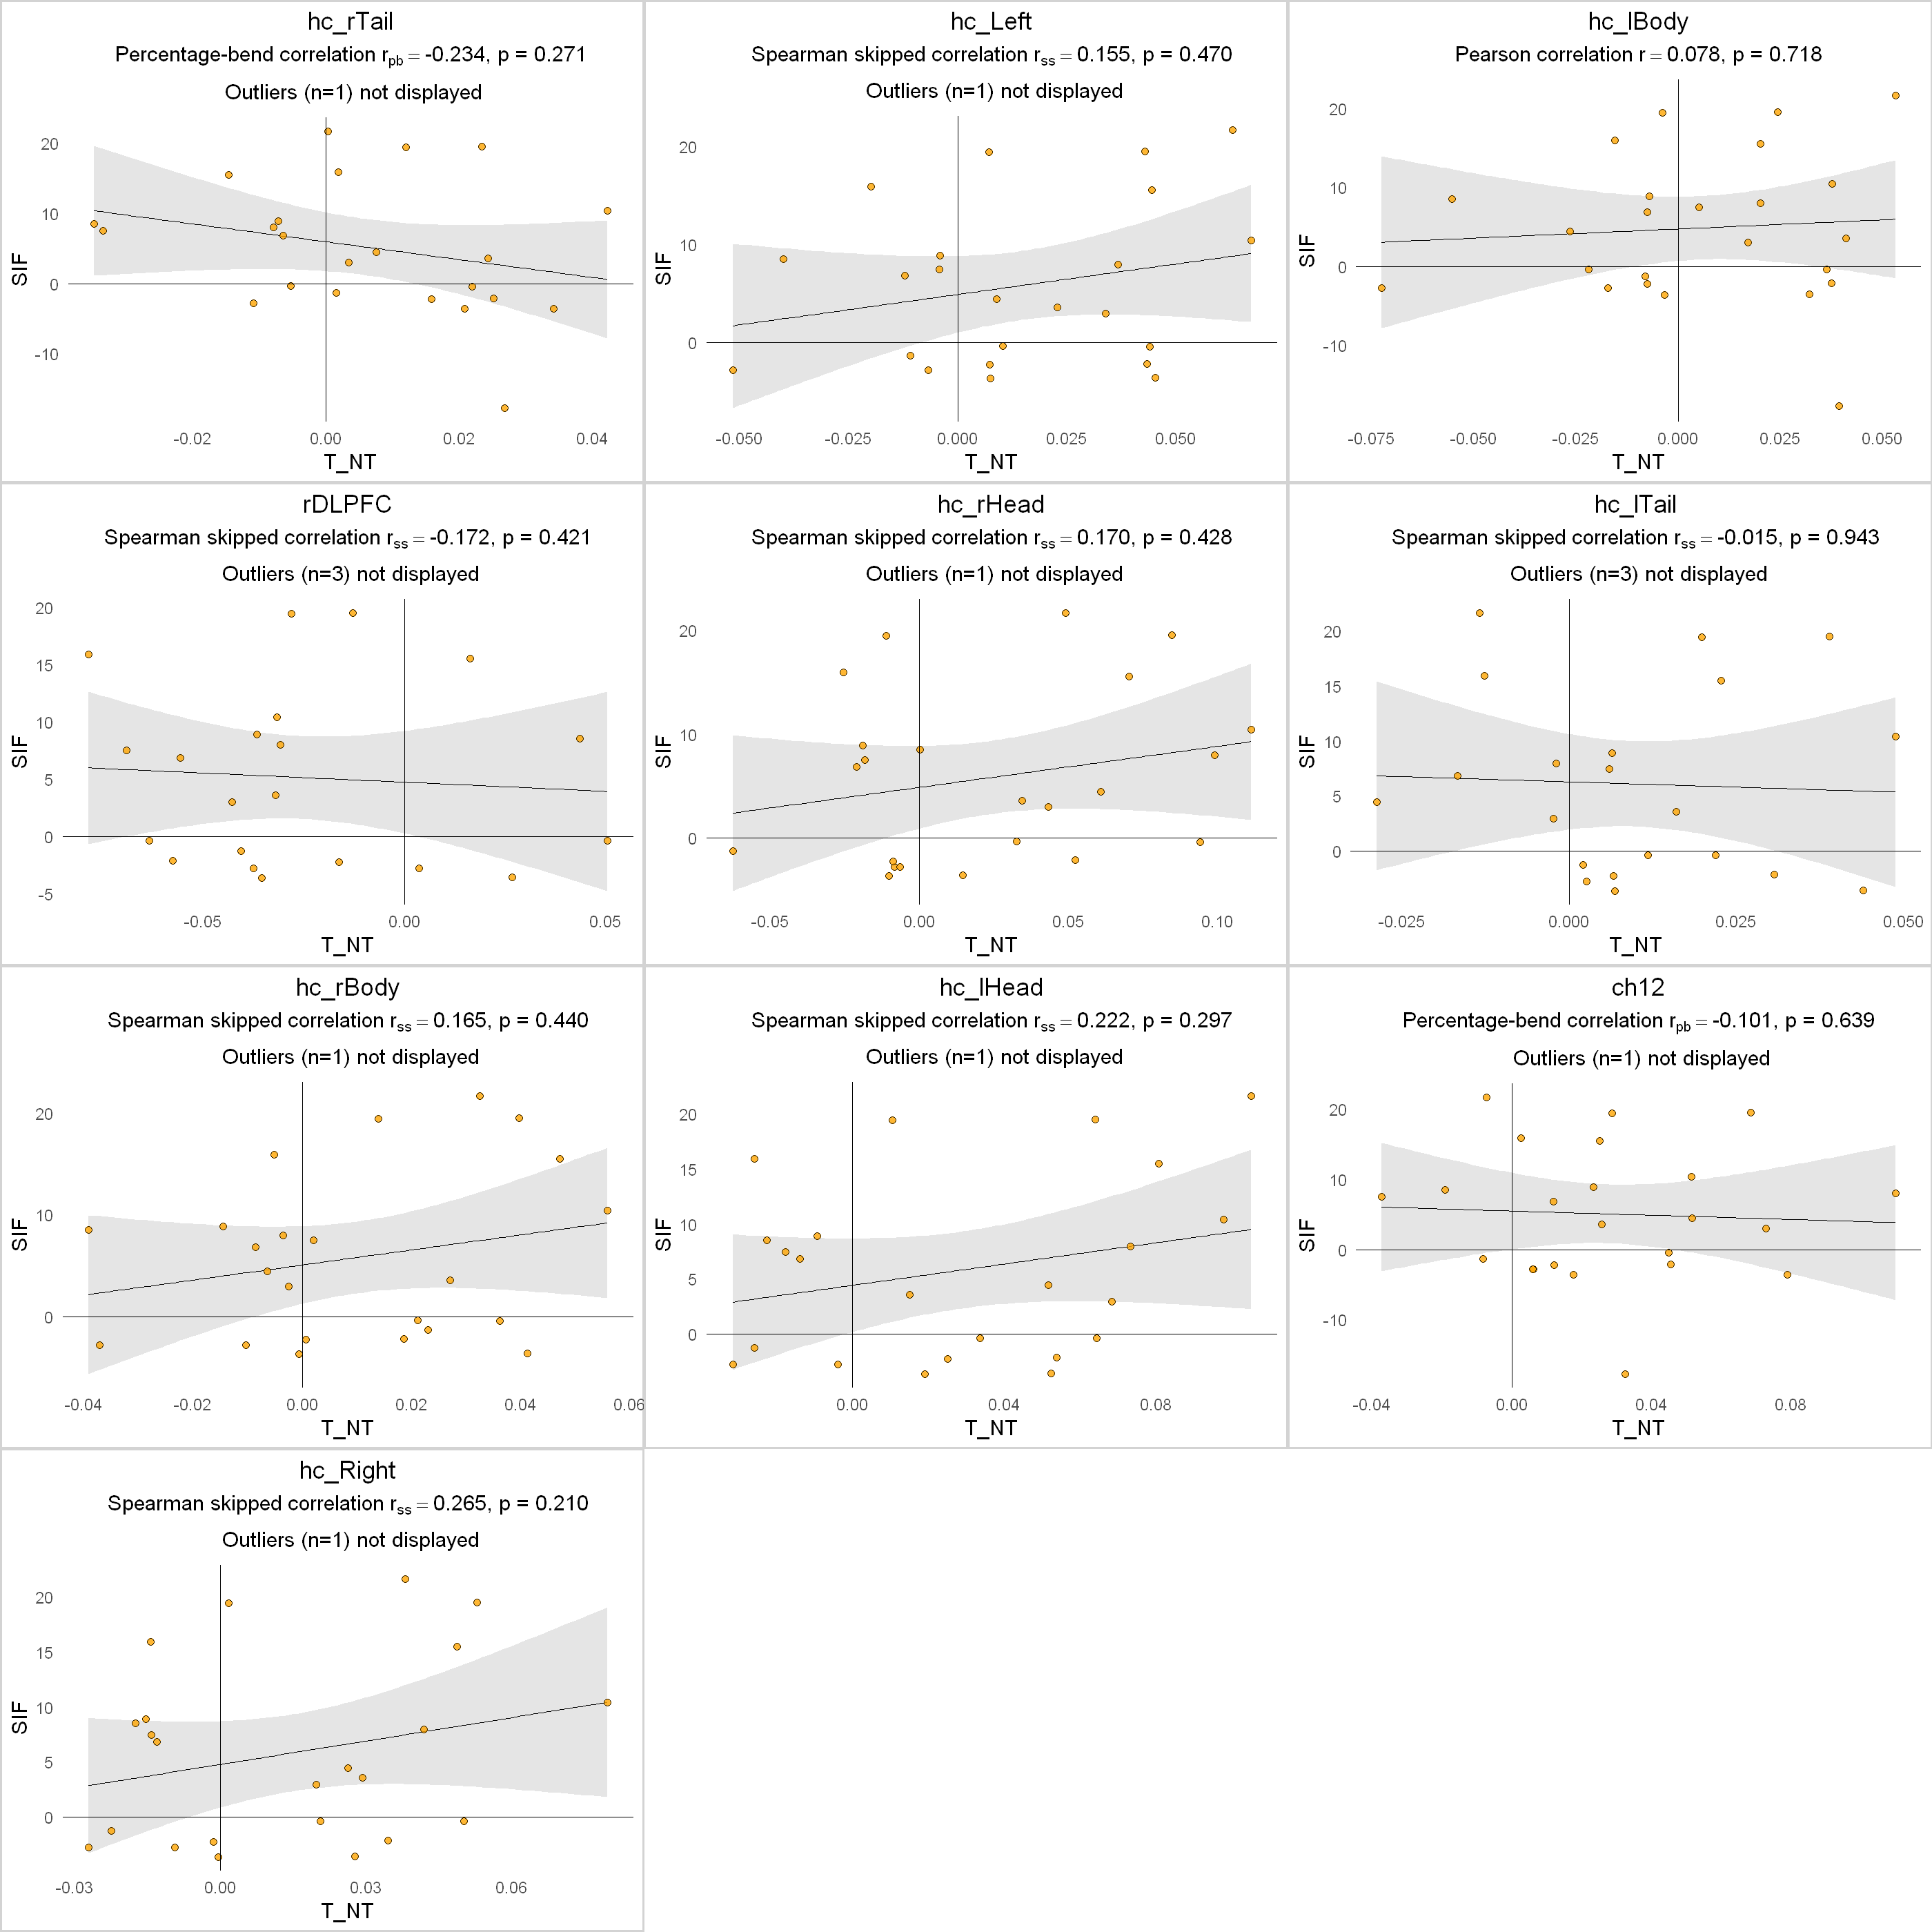

In [66]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "09_Xu"

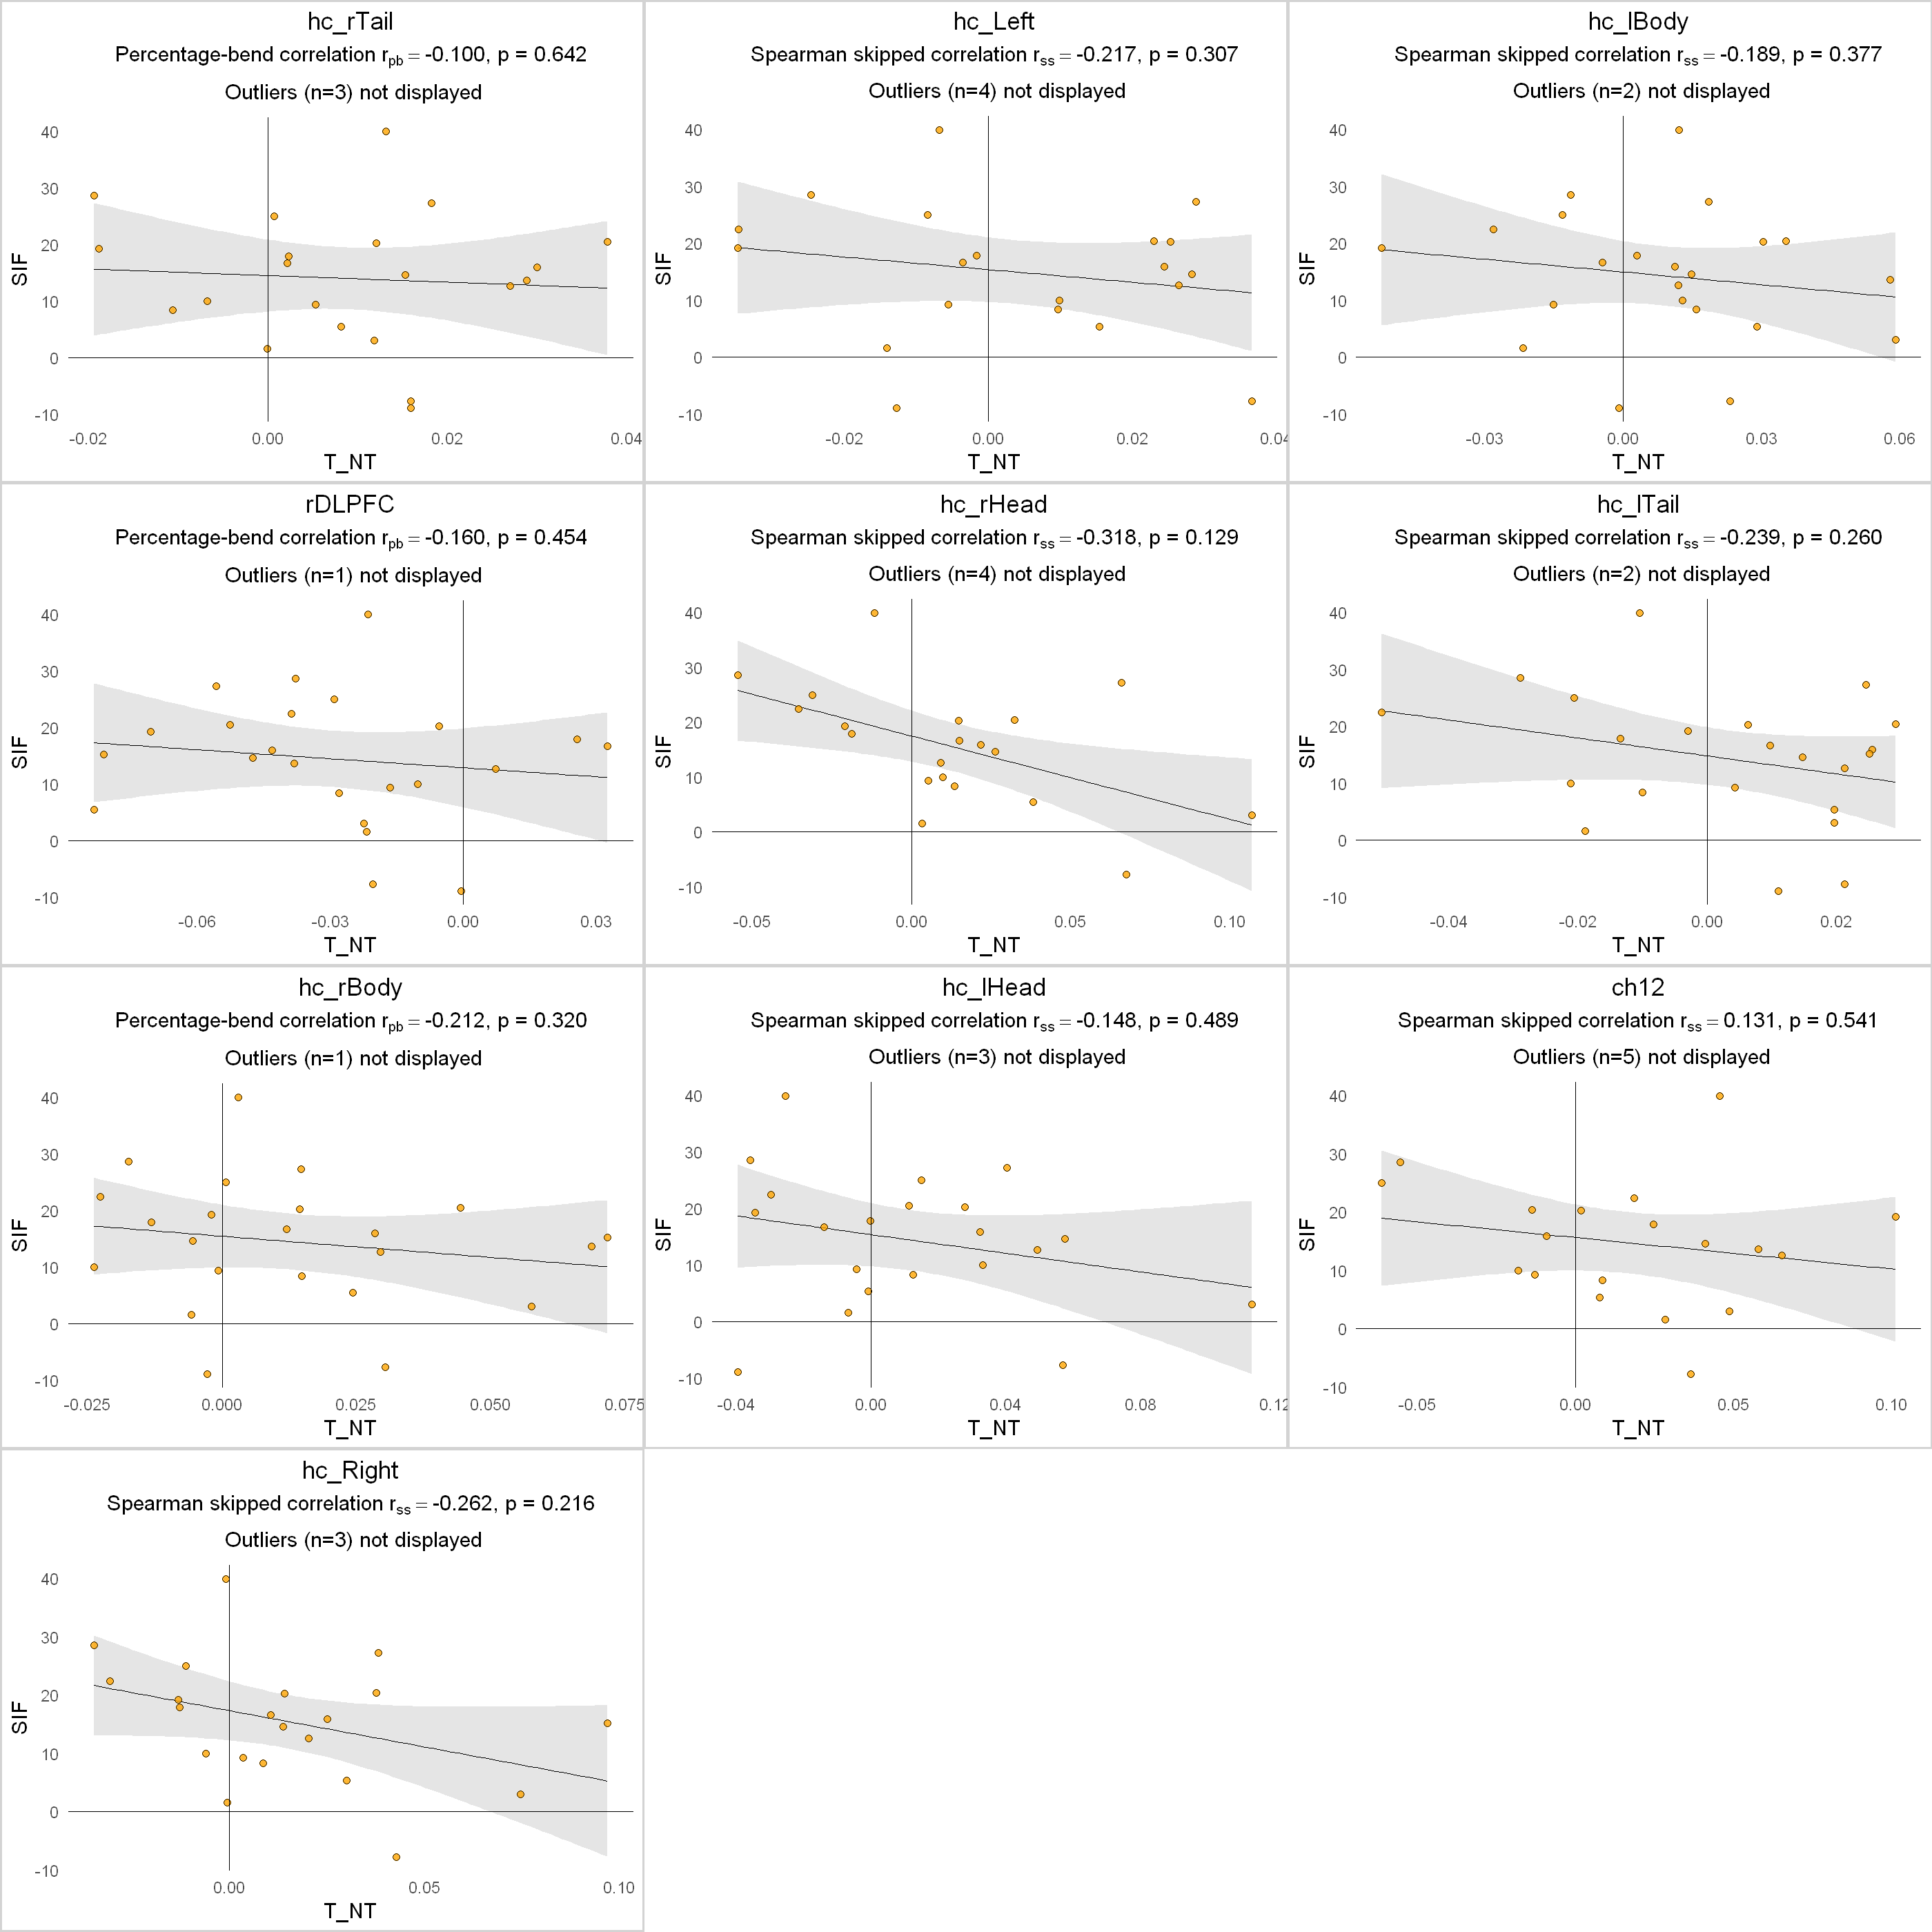

In [67]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "10_Big-TNT"

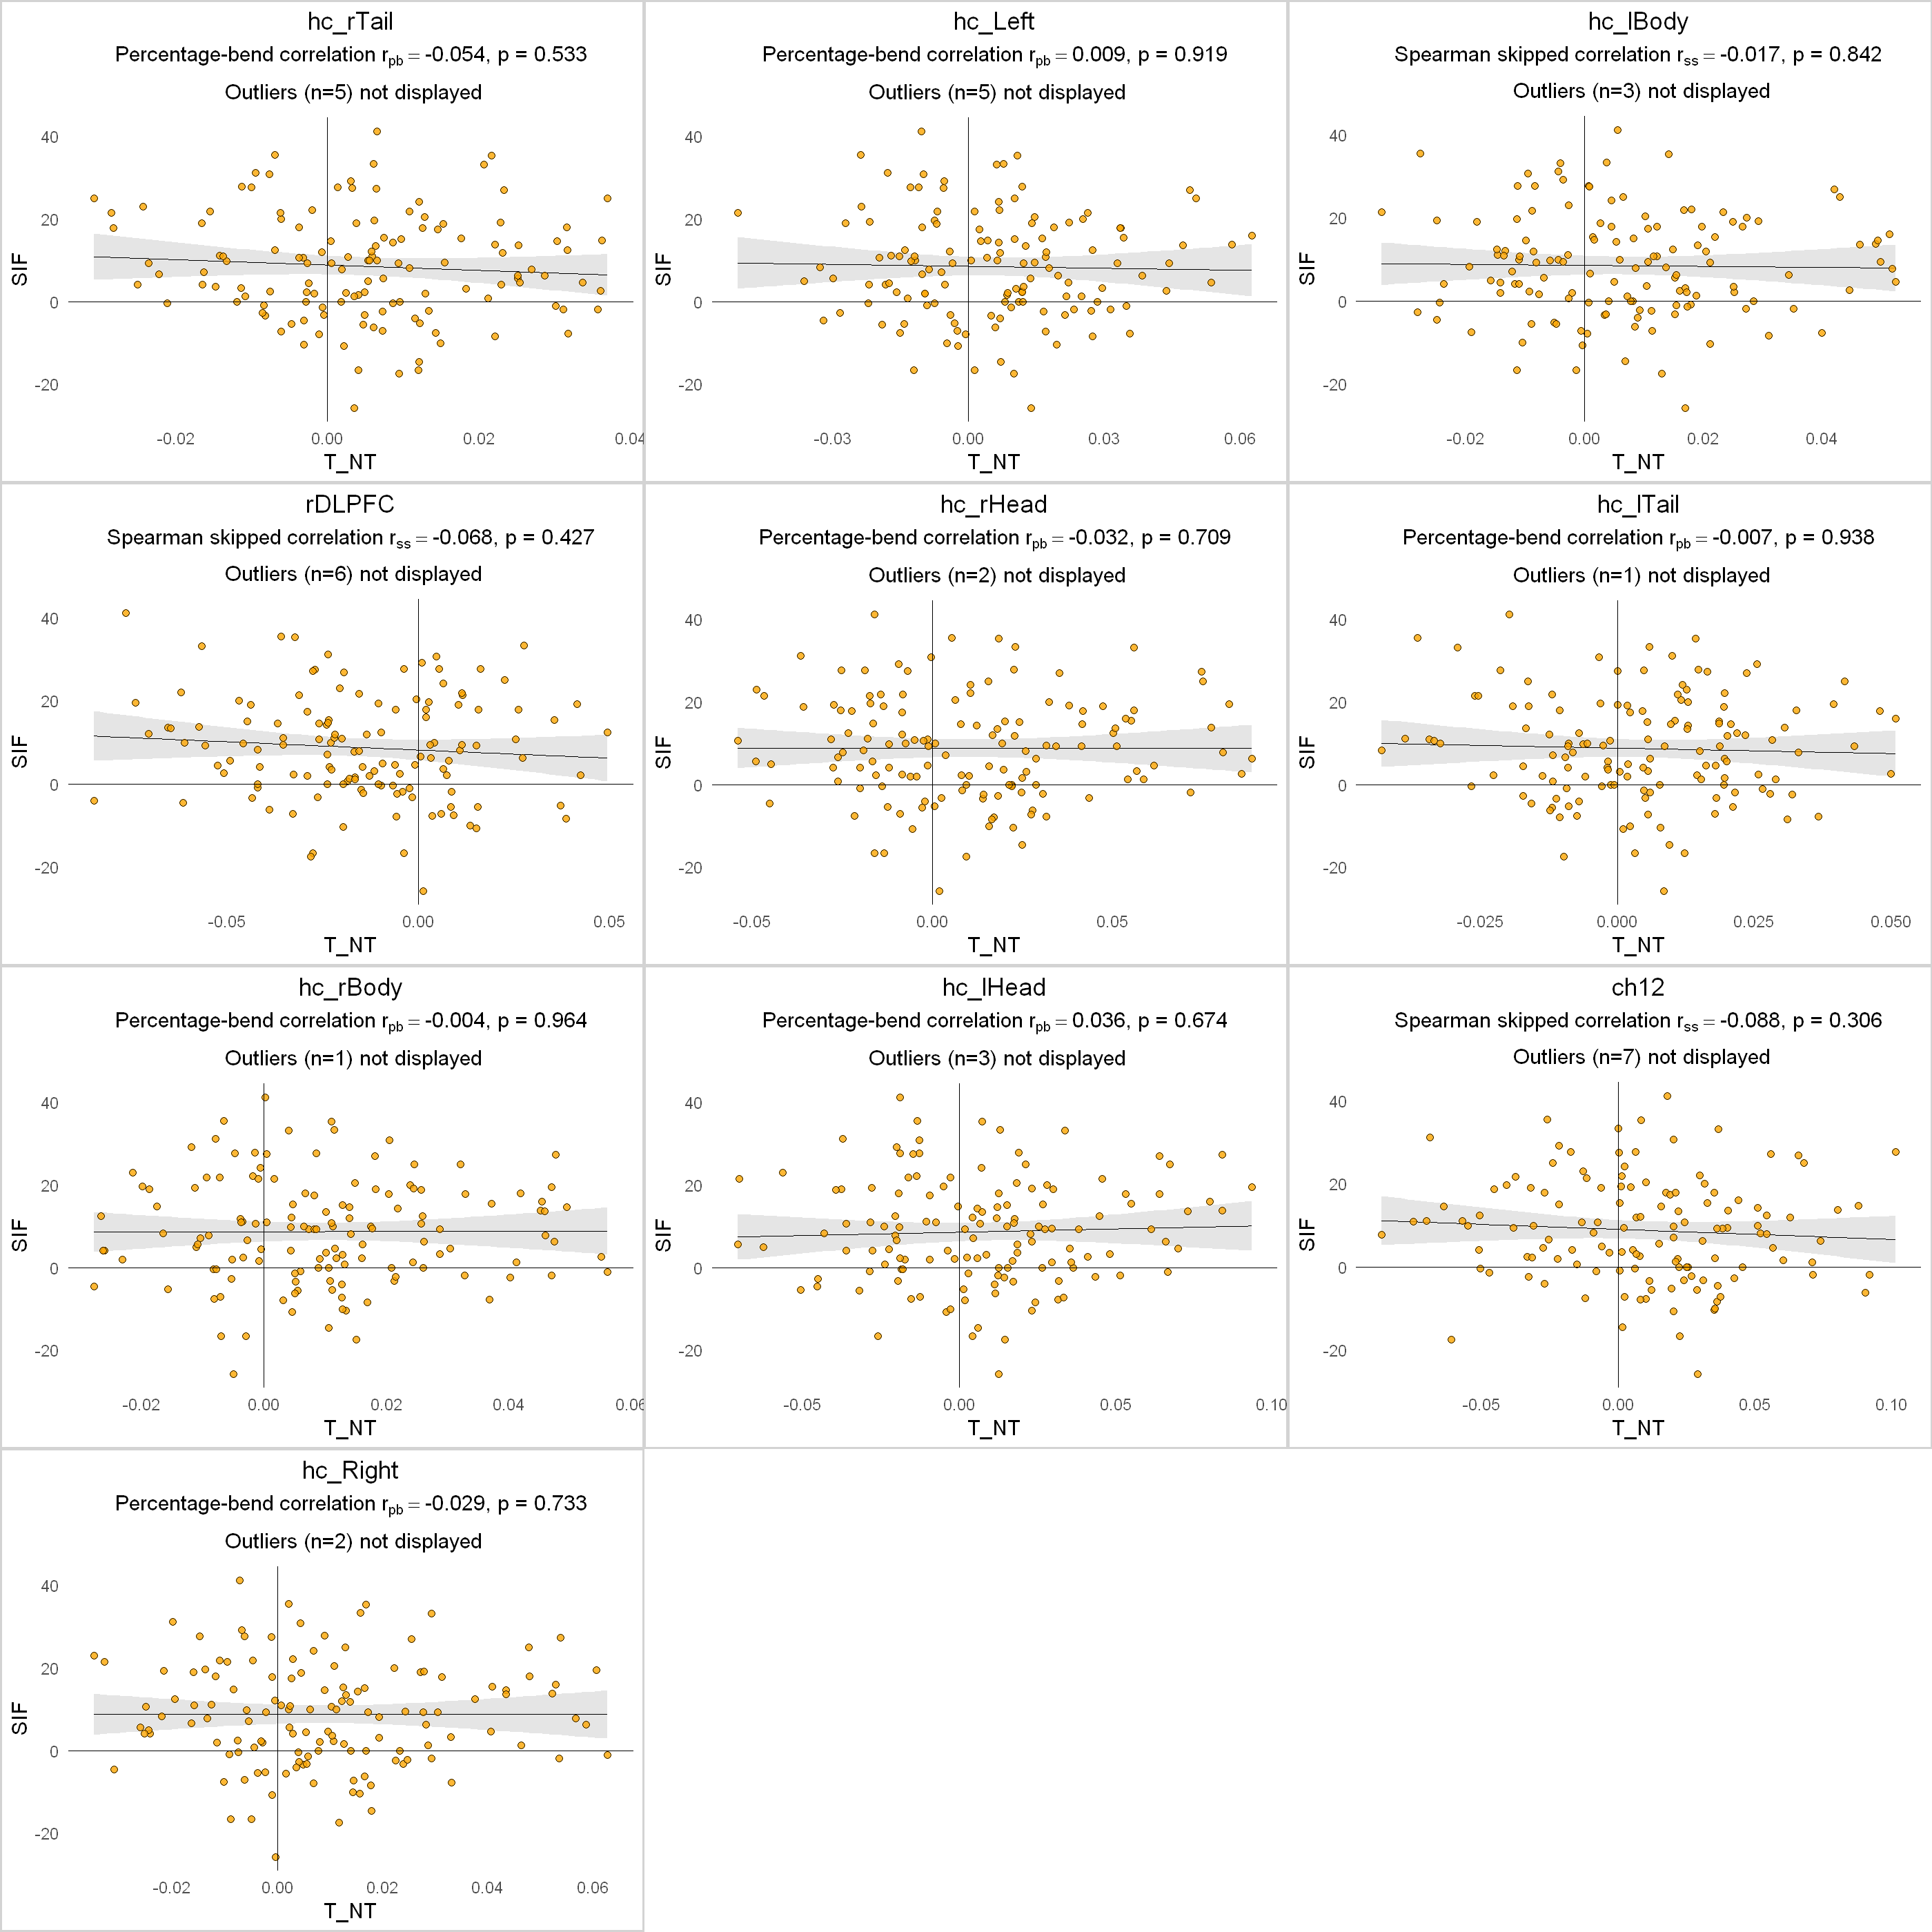

In [68]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")